In [1]:
package = ['boto3','es_lemmatizer','pyodbc','prince']
f= open("paquetes.txt","w+")

def install_txt(package):
  f= open("paquetes.txt","w+")
  for i in package:
    print(i)
    

    try:
        __import__(i)
        print('ya instalado {}'.format(i))
    except ImportError:
        # main(['install', package]) 
        f.write("{} \r\n".format(i))
        print('No instalado {}'.format(i))


install_txt(package)  

boto3
ya instalado boto3
es_lemmatizer
ya instalado es_lemmatizer
pyodbc
ya instalado pyodbc
prince
ya instalado prince


In [2]:
!pip install -r paquetes.txt

#**Librerias**

In [3]:
#Librerias
import re
import numpy as np
import pandas as pd
import pandas_profiling
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import unicodedata
from es_lemmatizer import lemmatize
import spacy
import re
import pyodbc
import prince
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


#**Rutas**

In [4]:
#RUTAS
#OF :Operaciones financieras
#P : Personal

# Campaña_OF = Path('C:/Users/estduclui/Documents/ECOPETROL- TA/Entendimiento del negocio/Modelo Analítico PCF - Cuentas por pagar.xlsx')
# Campaña_P = Path('C:/Users/estduclui/Documents/ECOPETROL- TA/Entendimiento del negocio/Modelo Analítico PCP - Beneficio Educativo.xlsx')


In [5]:
#Rutas en Drive colab
os.getcwd()

'/content'

In [6]:
Campaña_OF =  "/content/Modelo Analítico PCF - Cuentas por pagar.xlsx"
Campaña_P  = "/content/Modelo Analítico PCP - Beneficio Educativo.xlsx"

#**Funciones**

In [7]:
# CONEXION A SERVIDOR ###################################################################################
# def Conexion():
#     server = '172.27.48.148'
#     #database = 'bdcmp_NuevaEpsCrm' 
#     username = 'CienciaDatos' 
#     password = 'C13nc1aD47*5'  
#     cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';UID='+username+';PWD='+ password)
#     cursor = cnxn.cursor()
#     return cnxn


# DEFINICION DE PICOS Y FECHAS ##################################################################################
##Se definen fechas para realizar los respectivos filtros 
##cuando se extraiga la información correspondiente desde el servidor

def fechas(df_Tipo_OF):
    df_OF = df_Tipo_OF.astype(str).replace('NaT','20200101')
#######Operaciones financieras
    df_OF ['fecha_ini_1'] = df_OF['Picos de demanda  1'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_1'] = ['20210401','20210301','20210301','20210301', '20210301', '20210301', '20210401']
    df_OF ['fecha_ini_2'] = df_OF['Picos de demanda  2'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_2'] = ['20210501', '20210501', '20200101', '20210501', '20200101', '20210501', '20201001']
    df_OF ['fecha_ini_3'] = df_OF['Picos de demanda  3'].replace(regex=r'-', value = '').replace('0','20200101')
    df_OF ['fecha_fin_3'] = ['20210601', '20200101', '20200101', '20210601', '20200101', '20200101', '20210101']
    
    return df_OF  

## EXTRACCIÓN ########################################################################################################

def Extraccion(df_fechas, df_General, picos):
    #df_fechas : Nombre de la tabla con las tipologias seleccionadas y las fechas definidas correspondientes (con la función de fechas)
    #df_general : Nombre de tabla para cada campaña sin las fechas definidas 
    #picos : Número máximo de picos que se analizan [en OF son 2, en P son 3]
    
    query_base = "SELECT * FROM [172.27.90.50].[Ecopetrol_Reporting].[dbo].[Tbl_Ecopetrol_ResultadoBackOffice] "
    
    i = 0 
    cnxn = Conexion()
    query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas['fecha_ini_1'][i]+ "' AND '" + df_fechas['fecha_fin_1'][i] +"')"  
    query_completa = query_base + query
    df_inicial = pd.read_sql(query_completa, cnxn)

    for j in range(1,picos+1):
        df_General["Datos_Pico_"+str(j)] = 0
        for i in range(0,len(df_fechas['Campaña'])):
            cnxn = Conexion()
            query = "WHERE ([fgs_Nivel3] = '"+ df_fechas['Nivel 3'][i] + "') AND ([fgs_FechaInicio] BETWEEN '" + df_fechas["fecha_ini_"+str(j)][i]+ "' AND '" + df_fechas["fecha_fin_"+str(j)][i] +"')"  
            query_completa = query_base + query
            df = pd.read_sql(query_completa, cnxn)
            df_total = pd.concat([df_inicial,df]).drop_duplicates()
            df_inicial = df_total
            df_General["Datos_Pico_"+str(j)][i] = df.shape[0] 
    print('Total de registros:', df_inicial.shape[0])
    print('Total de columnas:', df_inicial.shape[1])
            
    return df_total,df_General                 

# VALORES FALTANTES ###############################################################################################################################################################################################

def Valores_Faltantes(df, porcentaje):
    Faltantes = df.isnull().sum()
    df_Faltantes = pd.DataFrame({'Nombre_Columnas':Faltantes.index, 'Total_Vacios':Faltantes.values})#[df_Faltantes['Total_Vacios'] != 0]
    df_Faltantes = df_Faltantes[df_Faltantes['Total_Vacios'] != 0]

    df_Faltantes['Porcentaje_vacio'] = ((df_Faltantes['Total_Vacios']/df.shape[0])*100).round(2)
    df_Faltantes['Columna_vacia'] = 'NO'
    df_Faltantes.loc[df_Faltantes['Total_Vacios'] == df.shape[0], 'Columna_vacia'] = 'SI'
    
    print('Total columnas con valores faltantes :', df_Faltantes.shape[0])
    print('Total columnas vacias :', df_Faltantes[df_Faltantes['Columna_vacia'] == 'SI'].Columna_vacia.count())
    print('Total columnas no vacias con mas del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    #print('Total columnas no vacias con menos del ' + str(porcentaje) + '% de valores faltantes :', df_Faltantes[(df_Faltantes['Porcentaje_vacio'] >= porcentaje) & (df_Faltantes['Columna_vacia'] == 'NO') ].Columna_vacia.count())
    
    return df_Faltantes

# ELIMINAR COLUMNAS##############################################################################################

#para eliminar columnas seleccionadas
def Eliminar_columnas(df, lista_columnas):
    df_drop = df.drop(columns = lista_columnas)
    print ('Cantidad de columnas iniciales : ', df.shape[1])
    print ('Cantidad despues de eliminar : ', df_drop.shape[1] )
    return df_drop
# columnas duplicadas
def columnas_dup(df):
    df_dup = df.T.duplicated().T
    return df_dup
#Para eliminar columnas duplicadas
def columnas_nodup(df):
    print ('Total de columnas antes de eliminar dup: ', df.shape[1])
    df_sindup = df.T.drop_duplicates().T
    print ('Total de columnas duplicadas : ', df.shape[1] - df_sindup.shape[1])
    print ('Total de columnas no duplicadas:', df_sindup.shape[1])
    return df_sindup    

def mytable(data):
    nulls = pd.DataFrame(data.isnull().sum()/data.shape[0]*100, columns=['% de datos nulos'])
    ceros = pd.DataFrame((data==0).sum()/data.shape[0]*100, columns=['% de ceros'])
    tipo = pd.DataFrame(data.dtypes,columns=['Tipo de datos'])
    val = pd.DataFrame(data.nunique(),columns=['# de valores diferentes'])
    valpor = pd.DataFrame(data.nunique()/data.shape[0]*100,columns=['% de valores diferentes'])
    mis_val_table = pd.concat([nulls, ceros,tipo, val, valpor], axis=1)
    return mis_val_table

**CAMPAÑA OPERACIONES FINACIERAS - CUENTAS POR PAGAR**

# **EXTRACCIÓN**

## **Definición de Tipologías y meses que se extraeran**

Se extrae tabla producto del entendimiento del negocio donde se encuentran definidas las tipologias y meses donde se presentaron los picos a estudiar

In [8]:
df_Tipo_P =  pd.read_excel(Campaña_P, sheet_name = '2. Esquema Tipologías de Servic', usecols = "B:H", skiprows= lambda x: x in [0, 1]).astype(str).replace('NaT','0') 

-- Campaña Operaciones financieras

In [9]:
df_Tipo_P

,Campaña,Nivel 1,Nivel 2,Nivel 3,Picos de demanda,Gráficos análisis exploratorio
0,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Febrero -2021 Agosto-2020,1. Legalización
1,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Legal / Reconocimiento Trabajadores (Incluye B...,Febrero -2021 Agosto-2020,1. Legalización
2,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Solicitud de educación inclusiva,Febrero-2021,2. Solicitud de educación inclusiva
3,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Anticipo Pensionados Educación Inclusiva,Abril-2021 Noviembre-2020,3. Anticipo
4,Personal,Gestión de beneficios,Beneficio Educativo - Inclusiva,Anticipo Trabajadores Educación Inclusiva,Abril-2021 Noviembre-2020,3. Anticipo
5,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Anticipo Pensionados (Incluye Sustitutos),Abril-2021 Noviembre-2020,3. Anticipo
6,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Anticipo Trabajadores (Incluye BXC),Abril-2021 Noviembre-2020,3. Anticipo
7,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta Bachiller Ecopetrol (Incapacidad médi...,Febrero-2021 Noviembre-2020,4. Consulta
8,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta de información relacionadas con reemb...,Febrero-2021 Noviembre-2020,4. Consulta
9,Personal,Gestión de beneficios,Beneficio Educativo - Regular,Consulta especialista beneficios atención PQRS,Febrero-2021 Noviembre-2020,4. Consulta


Se definen fechas de los picos en cada tipologia con el fin de realizar el posterior filtro 

In [10]:
# df_fechas_P = fechas(df_Tipo_P)

In [11]:
# df_fechas_P

## **Pefilamiento inicial P**

In [12]:
#Lectura
df_Registros_P = pd.read_csv('Base_general_extraida_P.csv')
df_Registros_P.head(2)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (51,156,160,161,162,163,165,167,197) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,fgs_IdCampana,fgs_IdGestion,fgs_IdGestionDetalle,fgs_NombreCampana,fgs_NombrePlataforma,fgs_SiglasDocumentoContacto,fgs_NombreDocumentoContacto,fgs_NumeroDocumContacto,fgs_NombreCompletoContacto,fgs_FechaNacimientoContacto,fgs_HabeasContacto,fgs_NombreGeneroContacto,fgs_RoutingPointOrVdn,fgs_Extension,fgs_CallId,fgs_Skill,fgs_Ani,fgs_Ip,fgs_OpcionesIVR,fgs_FechaInicio,fgs_FechaFin,fgs_IdTipificacionGestionDetalle,fgs_Tipificación,fgs_Nivel1,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Nivel5,fgs_Nivel6,fgs_Nivel7,fgs_Nivel8,fgs_Nivel9,fgs_Nivel10,fgs_Direccion_01,fgs_BarrioDireccion_01,fgs_LocalidadDireccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_PaisDireccion_01,fgs_Telefono_01,...,T_Objetivo_Total,T_Real_Total,Cumple_Objetivo_Total,fdp_IdHistoricoPqrGestionActual,fdp_IdGrupoGestionActual,fdp_NombreGrupoGestionActual,fdp_IdDetalleFlujoGestionActual,fdp_IdUsuarioGestionActual,fdp_UsuarioGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,CodigoGrupoRolGestionActual,GrupoRolGestionActual,fdp_MotivoGestionActual,fdp_NivelGestionActual,Ajustado,TipoAjuste,Valido,Pruebas,fdp_FechaVencimientoTotal,NoReprocesar,fdp_IdHistoricoPqrEscalamientoN4,fdp_IdGrupoEscalamientoN4,fdp_NombreGrupoEscalamientoN4,fdp_IdDetalleFlujoEscalamientoN4,fdp_IdUsuarioEscalamientoN4,fdp_UsuarioEscalamientoN4,fdp_NombreUsuarioEscalamientoN4,fgs_ObservacionEscalamientoN4,fdp_FechaEscalamientoN4,fdp_FechaVencimientoEscalamientoN4,CodigoGrupoRolEscalamientoN4,GrupoRolEscalamientoN4,fdp_MotivoEscalamientoN4,fdp_NivelEscalamientoN4,T_Objetivo_EnNivel4,T_Real_EnNivel4,Cumple_Objetivo_EnNivel4
0,3,13908445,1011368.0,Personal,Web,CC,NaN,19322865,SANCHEZ MORA JOAQUIN ERNESTO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.27.40.50,NaN,2021-02-01 06:40:30.150,2021-02-01 06:47:23.443,4859,Contacto,Gestión de beneficios,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,NaN,NaN,NaN,NaN,NaN,NaN,CL 170 53C 27,NaN,NaN,"BOGOTA, D.C.",BOGOTA,Colombia,12572213,...,NaN,NaN,NaN,4.0,0,Grupo Primer Nivel Personal,NaN,2901,52835092,AIDA ALEXANDRA RODRIGUEZ AMAYA,"""se informa que su caso no puede ser tramitado...",2021-02-01 06:47:23.443,2020-02-25 16:30:00.000,3,Asesor de Servicio Front Contact Center,NaN,Nivel1,True,Fecha Superior a la fecha de creación o Fecha ...,NaN,False,2021-02-01 09:45:00.000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No Aplica
1,3,13908527,1011422.0,Personal,Web,CC,NaN,1053843731,SANTA GAVIRIA MERY ANGELA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.168.73.74,NaN,2021-02-01 06:55:42.110,2021-02-01 07:01:31.857,4859,Contacto,Gestión de beneficios,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,NaN,NaN,NaN,NaN,NaN,NaN,MCCA 21 CONJ PORTAL DE LAS AVENIDAS,NaN,NaN,SANTA MARTA,MAGDALENA,Colombia,3124964423,...,NaN,NaN,NaN,4.0,0,Grupo Primer Nivel Personal,NaN,106,1013600392,DIANA MILENA GUERRERO MELLIZO,Se realizó el ajuste de semestre y se encuentr...,2021-02-01 07:01:31.857,2020-02-25 16:30:00.000,1,Asesor de Servicio Contact Center,NaN,Nivel1,True,Fecha Superior a la fecha de creación o Fecha ...,NaN,False,2021-02-01 09:45:00.000,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,No Aplica


In [13]:
tabla=mytable(df_Registros_P)
display(tabla,df_Registros_P.shape)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdCampana,0.000000,0.000000,int64,1,0.007274
fgs_IdGestion,0.000000,0.000000,int64,13748,100.000000
fgs_IdGestionDetalle,0.000000,0.000000,float64,13748,100.000000
fgs_NombreCampana,0.000000,0.000000,object,1,0.007274
fgs_NombrePlataforma,0.000000,0.000000,object,1,0.007274
...,...,...,...,...,...
fdp_MotivoEscalamientoN4,100.000000,0.000000,float64,0,0.000000
fdp_NivelEscalamientoN4,100.000000,0.000000,float64,0,0.000000
T_Objetivo_EnNivel4,100.000000,0.000000,float64,0,0.000000
T_Real_EnNivel4,22.956066,77.043934,float64,1,0.007274


(13748, 222)

In [14]:
tabla.describe(percentiles=[.05,0.25,0.5,.75,.95])

,% de datos nulos,% de ceros,# de valores diferentes,% de valores diferentes
count,222.000000,222.000000,222.000000,222.000000
mean,49.130717,4.435797,1058.720721,7.700907
std,47.506168,18.709198,3063.211801,22.281145
min,0.000000,0.000000,0.000000,0.000000
5%,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.250000,0.001818
50%,54.611580,0.000000,3.000000,0.021821
75%,99.998182,0.000000,61.500000,0.447338
95%,100.000000,22.890602,9551.450000,69.475196
max,100.000000,100.000000,13748.000000,100.000000


In [15]:
vacios = tabla[tabla['% de datos nulos']==100]
vacios

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_NombreDocumentoContacto,100.0,0.0,float64,0,0.0
fgs_FechaNacimientoContacto,100.0,0.0,float64,0,0.0
fgs_HabeasContacto,100.0,0.0,float64,0,0.0
fgs_NombreGeneroContacto,100.0,0.0,float64,0,0.0
fgs_RoutingPointOrVdn,100.0,0.0,float64,0,0.0
fgs_Extension,100.0,0.0,float64,0,0.0
fgs_CallId,100.0,0.0,float64,0,0.0
fgs_Skill,100.0,0.0,float64,0,0.0
fgs_Ani,100.0,0.0,float64,0,0.0
fgs_OpcionesIVR,100.0,0.0,float64,0,0.0


In [16]:
cardinalidad100 = tabla[tabla['% de valores diferentes']==100]
cardinalidad100

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdGestion,0.0,0.0,int64,13748,100.0
fgs_IdGestionDetalle,0.0,0.0,float64,13748,100.0


In [17]:
tabla

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdCampana,0.000000,0.000000,int64,1,0.007274
fgs_IdGestion,0.000000,0.000000,int64,13748,100.000000
fgs_IdGestionDetalle,0.000000,0.000000,float64,13748,100.000000
fgs_NombreCampana,0.000000,0.000000,object,1,0.007274
fgs_NombrePlataforma,0.000000,0.000000,object,1,0.007274
...,...,...,...,...,...
fdp_MotivoEscalamientoN4,100.000000,0.000000,float64,0,0.000000
fdp_NivelEscalamientoN4,100.000000,0.000000,float64,0,0.000000
T_Objetivo_EnNivel4,100.000000,0.000000,float64,0,0.000000
T_Real_EnNivel4,22.956066,77.043934,float64,1,0.007274


In [18]:
cardinalidad1 = tabla[tabla['# de valores diferentes']==1]
cardinalidad1

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_IdCampana,0.000000,0.000000,int64,1,0.007274
fgs_NombreCampana,0.000000,0.000000,object,1,0.007274
fgs_NombrePlataforma,0.000000,0.000000,object,1,0.007274
fgs_Nivel1,0.000000,0.000000,object,1,0.007274
fgs_PaisDireccion_01,0.101833,0.000000,object,1,0.007274
TipoTransacción,0.000000,0.000000,object,1,0.007274
TipoComplejidad,0.000000,0.000000,object,1,0.007274
Funcionalidad,0.000000,0.000000,object,1,0.007274
DependenciaLínea,0.000000,0.000000,object,1,0.007274
AreaServicio,0.000000,0.000000,object,1,0.007274


In [19]:
(tabla['# de valores diferentes']==1).loc['fgs_Nivel1']

True

In [20]:
tabla.loc['fgs_Nivel1']

% de datos nulos                    0
% de ceros                          0
Tipo de datos                  object
# de valores diferentes             1
% de valores diferentes    0.00727379
Name: fgs_Nivel1, dtype: object

In [21]:
tabla.loc['fgs_Nivel1']['# de valores diferentes']==1

True

In [22]:
(tabla['# de valores diferentes']==1).loc['fgs_Nivel1']

True

In [23]:
# tabla[tabla['# de valores diferentes']==1].loc['fgs_Nivel1']

In [24]:
# profile = df_Registros_OF.profile_report(title = 'Pandas Profiling Report', correlations={"cramers": {"calculate": False}})
# profile.to_file(output_file = 'Perfilamiento_BaseInicial_CuentasPorPagar.html')

In [25]:
df_Registros_P = df_Registros_P[df_Registros_P['fgs_Nivel1'] != 'Prestador de Servicios de Salud']
# se fue solo un dato y estefania lo borro.

In [26]:
variables_eliminar=vacios.index.tolist()+cardinalidad1.index.tolist()+cardinalidad100.index.tolist()# no aportan informacion
len(variables_eliminar)

97

In [27]:
mapa_columnas = [i not in variables_eliminar for i in df_Registros_P.columns]  

In [28]:
sum(mapa_columnas)

125

In [29]:
df_Registros_P.shape

(13748, 222)

In [30]:
125+97

222

In [31]:
nuevas_columnas = df_Registros_P.columns[mapa_columnas]

In [32]:
df_Registros_P = df_Registros_P[nuevas_columnas]

In [33]:
df_Registros_P.shape

(13748, 125)

In [34]:
tabla = mytable(df_Registros_P)

In [35]:
tabla

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.101833,0.000000,object,5,0.036369
fgs_NumeroDocumContacto,0.000000,0.000000,int64,4453,32.390166
fgs_NombreCompletoContacto,0.000000,0.000000,object,4463,32.462904
fgs_Ip,0.101833,0.000000,object,235,1.709340
fgs_FechaInicio,0.000000,0.000000,object,13727,99.847251
...,...,...,...,...,...
fdp_MotivoGestionActual,99.985452,0.000000,object,2,0.014548
fdp_NivelGestionActual,0.000000,0.000000,object,2,0.014548
TipoAjuste,50.640093,0.000000,object,2,0.014548
fdp_FechaVencimientoTotal,0.000000,0.000000,object,10419,75.785569


In [36]:
tabla['Tipo de datos'].value_counts()

object     76
float64    37
int64      11
bool        1
Name: Tipo de datos, dtype: int64

In [37]:
df_Registros_P.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13748 entries, 0 to 13747
Columns: 125 entries, fgs_SiglasDocumentoContacto to NoReprocesar
dtypes: bool(1), float64(37), int64(11), object(76)
memory usage: 13.1+ MB


In [38]:
objetos = df_Registros_P.select_dtypes(['object'])
numeros = df_Registros_P.select_dtypes(['int64','float64'])

In [39]:
objetos.describe()

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,fgs_Ip,fgs_FechaInicio,fgs_FechaFin,fgs_Tipificación,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Direccion_01,fgs_BarrioDireccion_01,fgs_LocalidadDireccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_Email_01,fgs_Email_02,fgs_Email_03,fmf_Canal,ude_Regional,ude_CiudadCliente,ude_DepartamentoCliente,ude_PaisCliente,ude_CodUni,ude_UnidadOrganizativa,ude_CECO,ude_CentroDeCostos,ude_EmailCliente,SistemaPago,ServicioPortafolio,fmf_FechaSolicitud,fdp_NombreEstado,fdp_NivelEstado,fdp_NombreUsuarioCreacion,fgs_ObservacionCreacion,fdp_FechaCreacion,GrupoRolCreacion,Cumple_Objetivo_SolicitadoRegistrado,Cumple_Objetivo_RegistradoEscalado,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fgs_ObservacionEscalamientoN2,fdp_FechaEscalamientoN2,fdp_FechaVencimientoEscalamientoN2,GrupoRolEscalamientoN2,Cumple_Objetivo_EnNivel2,fdp_NombreUsuarioDevolucion,fgs_ObservacionDevolucion,fdp_FechaDevolucion,fdp_FechaVencimientoDevolucion,GrupoRolDevolucion,fdp_MotivoDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fgs_ObservacionSolucion,fdp_FechaSolucion,fdp_FechaVencimientoSolucion,GrupoRolSolucion,fdp_NivelSolucion,Cumple_Objetivo_SolucionadoCerrado,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fgs_ObservacionCierre,fdp_FechaCierre,fdp_FechaVencimientoCierre,GrupoRolCierre,fdp_NivelCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,GrupoRolGestionActual,fdp_MotivoGestionActual,fdp_NivelGestionActual,TipoAjuste,fdp_FechaVencimientoTotal
count,13734,13748,13734,13748,13748,13748,13748,13748,13748,13748,49,53,13734,13734,13748,66,17,13748,12880,12962,12962,13748,12815.0,7838,12815,12804,12886,13748,13748,6240,13748,13748,13748,13748,13748,13748,13748,13748,2996,2972,2996,2996,2996,2972,13748,221,221,221,221,221,179,13719,13719,13719,13719,13708,13719,13719,13748,13718,13718,13718,13718,13707,13718,13718,13748,13748,13748,13748,13737,13748,2,13748,6786,13748
unique,5,4463,235,13727,13737,2,3,20,20,4669,6,4,185,28,4642,51,13,5,6,119,23,2,847.0,640,690,771,4197,3,20,5731,4,2,60,11953,13740,3,3,3,6,13,2890,2996,1995,2,3,40,214,221,184,3,6,7,67,11654,13711,2072,4,2,3,7,66,9541,13710,2072,4,2,7,66,9552,13740,2087,4,2,2,2,10419
top,CC,CLIENTE ANONIMO,172.27.40.50,2020-08-11 14:13:22.000,2020-08-19 11:02:40.000,Contacto,Beneficio Educativo - Regular,Legal / Reconocimiento Trabajadores (Incluye B...,Legal / Reconocimiento Trabajadores (Incluye B...,no registra,ACACIAS USAQUEN,Usaquén,BARRANCABERMEJA,SANTANDER,noregistra@ecopetrol.com.co,PILARES02@HOTMAIL.COM,adeco_nacional@yahoo.com,Email BackOffice,CENTRO ORIENTE,BARRANCABERMEJA,SANTANDER,COLOMBIA,0.0,Coordinación de Mantenimiento Correctivo,SO0388,GASTOS DE JUBILADOS,MANDOVALLE12@HOTMAIL.COM,Transacciones,Legal / Reconocimiento Trabajadores (Incluye B...,2020-09-22 21:28:00,Cerrado,Nivel1,LEIDY TATIANA CARREÑO PEREZ,solicita información de plan educacional.,2020-08-25 11:13:18.000,Asesor de Servicio Contact Center,No Aplica,Cumple,Equipo Plan Educacional,CLAUDIA CONSUELO OSTOS RUIZ,Sin Observaciones,2021-02-21 14:27:26.777000,2021-03-08 07:30:00,Asesor solucionador Ecopetrol,No Aplica,JIMMY SEBASTIAN GORDILLO GAMBOA,"Cordial saludo, el caso se devuelve porque deb...",2021-02-16 22:11:41.203000,2020-12-31 07:30:00,Asesor de Servicio Contact Center,Escalado al responsable de solución equivocado,Grupo Primer Nivel Personal,LEIDY TATIANA CARREÑO PEREZ,se procede a dar cierre según correo adjunto.,2021-04-22 14:37:04.000,2020-02-25 16:30:00.000,Asesor de Servicio Contact Center,Nivel1,Cumple,Grupo Primer Nivel Personal,LEIDY TATIANA CARREÑO PEREZ,Sin Observaciones,2020-08-13 14:29:03.000,2020-02-25 16:30:00.000,Asesor de Servicio Contact Center,Nivel1,Grupo Primer Nivel Personal,LEIDY TATIANA CARREÑO PEREZ,Sin Observaciones,2020-08-05 10:40:18.000,2020-02-25 16:30:00.000,Asesor de Servicio Contact Center,Escalado al responsabl

In [40]:
objetos.describe().T['unique'].astype('int').describe(percentiles=[0.25,0.5,0.75,0.85,0.90,0.95])

count       76.000000
mean      2342.210526
std       4372.155161
min          2.000000
25%          4.000000
50%         34.000000
75%       2075.750000
85%       5465.500000
90%      11036.500000
95%      13715.000000
max      13740.000000
Name: unique, dtype: float64

In [41]:
# objetos['fgs_Nivel1'].value_counts()

CC     13664
TI        26
NIT       24
CE        19
RC         1
Name: fgs_SiglasDocumentoContacto, dtype: int64

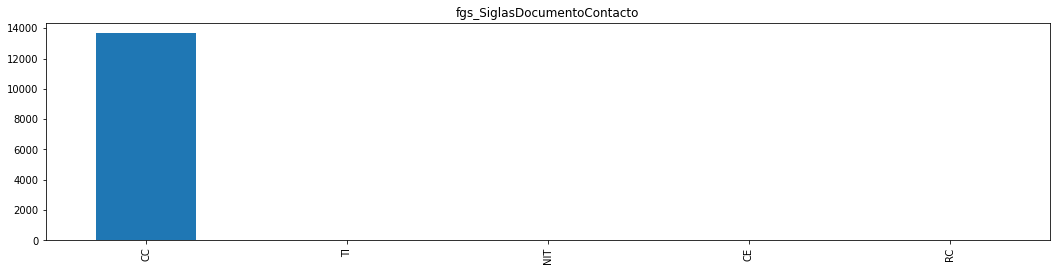

Contacto    10750
Atención     2998
Name: fgs_Tipificación, dtype: int64

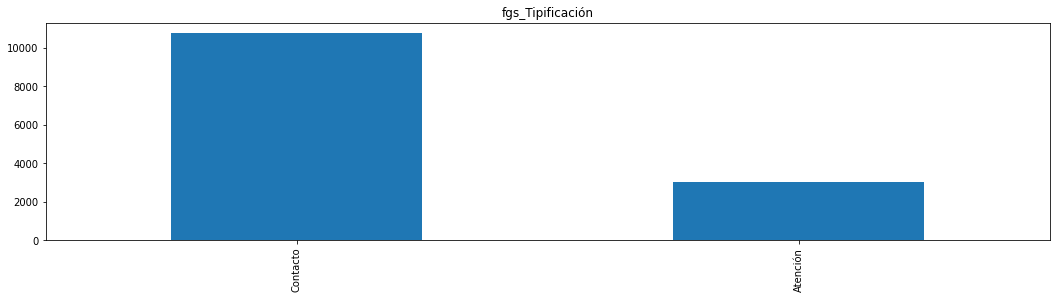

Beneficio Educativo - Regular               13254
Beneficio Educativo - Inclusiva               449
Beneficio Educativo - Colegios Ecopetrol       45
Name: fgs_Nivel2, dtype: int64

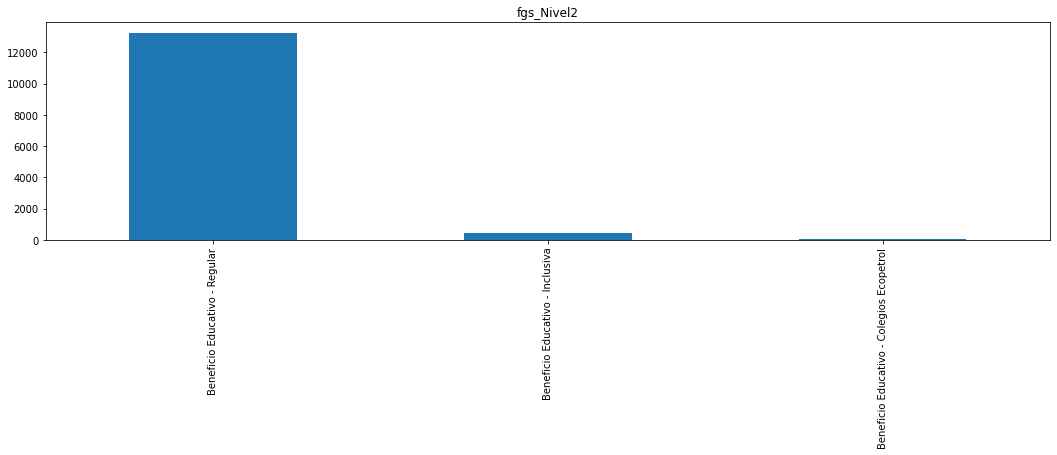

Legal / Reconocimiento Trabajadores (Incluye Bachiller ECP)                   4195
Legal / Reconocimiento Pensionados (Incluye Sustitutos)                       2415
Anticipo Trabajadores (Incluye BXC)                                           1807
Anticipo Pensionados (Incluye Sustitutos)                                     1586
Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)            1225
Soporte Plataforma para Instituciones Educativas vía TIB                      1121
Solicitud de educación inclusiva                                               414
Inscripción solicitud becas Comité de Educación Convencional Activos           353
Reintegro de dinero trabajadores Educación (Incluye Bachiller ECP)             303
Inscripción casos especiales comité de educación convencional activos           99
Reintegro de dinero Pensionados Educación (Incluye sustitutos y Auto)           58
Consulta Titulares Beneficio Eductivo - Desvinculados                           52
Soli

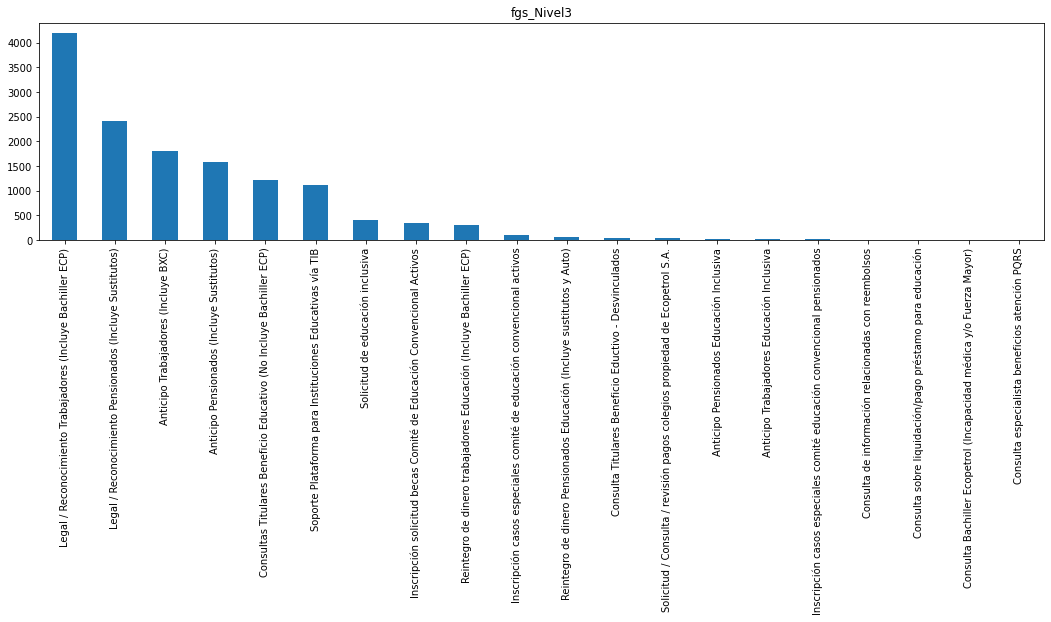

Legal / Reconocimiento Trabajadores (Incluye Bachiller ECP)                   4195
Legal / Reconocimiento Pensionados (Incluye Sustitutos)                       2415
Anticipo Trabajadores (Incluye BXC)                                           1807
Anticipo Pensionados (Incluye Sustitutos)                                     1586
Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)            1225
Soporte Plataforma para Instituciones Educativas vía TIB                      1121
Solicitud de educación inclusiva                                               414
Inscripción solicitud becas Comité de Educación Convencional Activos           353
Reintegro de dinero trabajadores Educación (Incluye Bachiller ECP)             303
Inscripción casos especiales comité de educación convencional activos           99
Reintegro de dinero Pensionados Educación (Incluye sustitutos y Auto)           58
Consulta Titulares Beneficio Eductivo - Desvinculados                           52
Soli

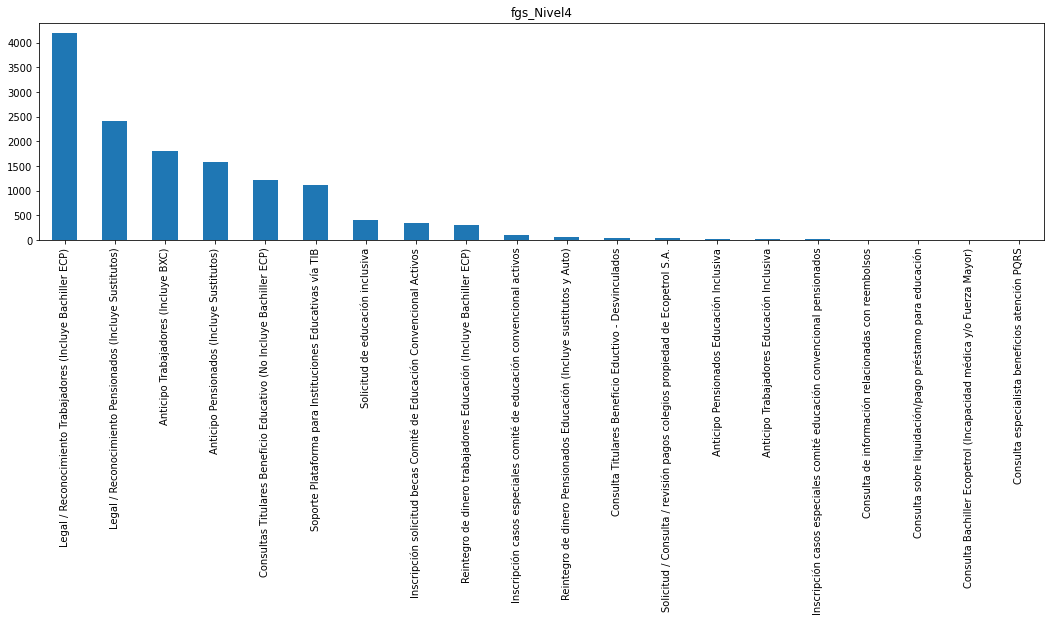

ACACIAS USAQUEN    26
BARRANCAS          17
COUNTRY CLUB        2
CHICO               2
CAOBOS SALAZAR      1
B. EL CALLEJON      1
Name: fgs_BarrioDireccion_01, dtype: int64

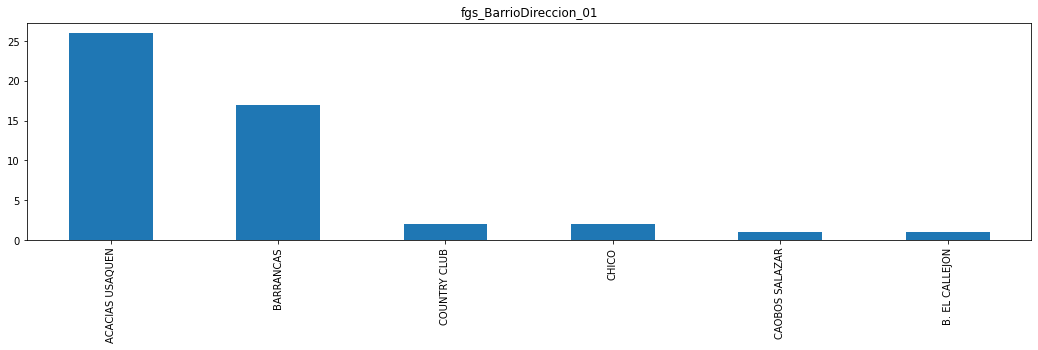

Usaquén      46
Chapinero     5
Kennedy       1
Comuna 01     1
Name: fgs_LocalidadDireccion_01, dtype: int64

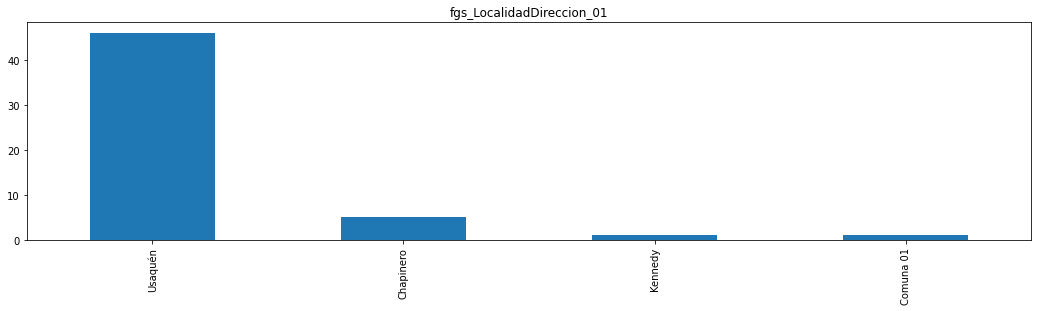

SANTANDER          5175
BOGOTA             3424
BOLIVAR            1294
ANTIOQUIA           883
META                641
CUNDINAMARCA        420
N. DE SANTANDER     399
HUILA               220
MAGDALENA           174
VALLE DEL CAUCA     160
ATLANTICO           138
CASANARE            121
CESAR               112
CALDAS              103
PUTUMAYO             86
BOYACA               79
TOLIMA               79
SUCRE                66
RISARALDA            43
CORDOBA              33
NARIÑO               24
QUINDIO              20
ARAUCA               12
SAN ANDRES           11
CAUCA                 9
CHOCO                 4
CAQUETA               3
VICHADA               1
Name: fgs_DepartamentoDireccion_01, dtype: int64

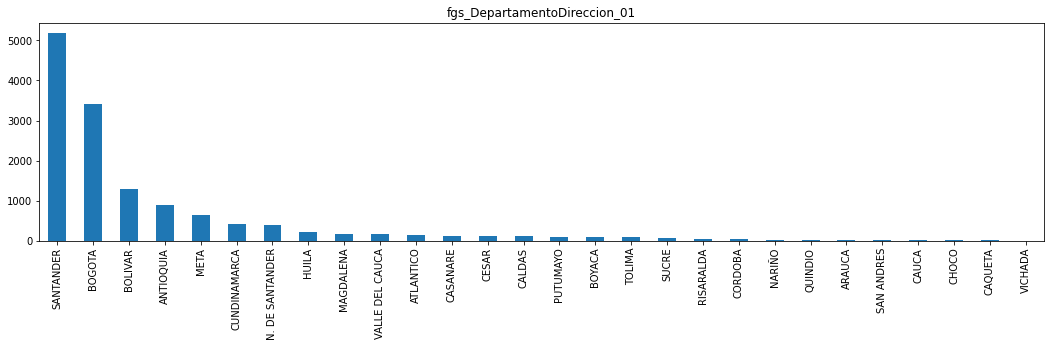

PILARES02@HOTMAIL.COM                       6
secretaria.academica@uan.edu.co             3
a.londono@losportales.edu.co                3
PACHITOANTONIO2015@HOTMAIL.COM              3
OSCEAM@HOTMAIL.COM                          2
carlosuriberangel@hotmail.comHOTMAIL.COM    2
katerinrosas@gmail.com                      2
IPC7989@HOTMAIL.COM                         2
mjarabaarevalo@gmail.com                    1
ORLANDOVARGAS18@HOTMAIL.COM                 1
CARLOSMARIOGOMEZN@HTMAIL.COM                1
FAURE.EDGAR@GMAIL.COM                       1
santhygrajales1999@gmail.com                1
NONE                                        1
WILLIAMR.VARGAS@ECOPETROL.COM.CO            1
ongelogios@gmail.com                        1
CARLOSANTIAGO7540@GMAIL.COM                 1
NAJUA28@HOTMAIL.COM                         1
MAPACO2001@GMAIL.COM                        1
dinoralunaquintero@gmail.com                1
JONNATHAN.PATINO@ECOPETROL.COM.CO           1
luis.amortegui@hotmail.com        

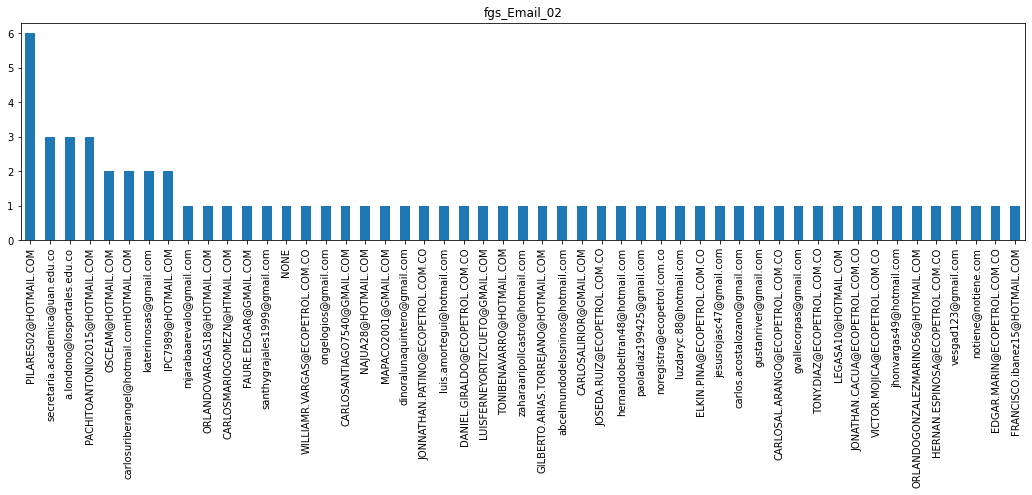

adeco_nacional@yahoo.com             3
noregistra@ecopetrol.com.co          2
sinmail@hotmail.com                  2
yolandavesga@gmail.com               1
luis.renato.amortegui@hotmail.com    1
GILBERTOARIAS2020@HOTMAIL.COM        1
PIPE51098@GMAIL.COM                  1
CARLOSED.ACOSTA@ECOPETROL.COM.CO     1
adm.certificados@eafit.edu.co        1
doraricoabogada@gmail.com            1
luz.angarita@ecopetrol.com.co        1
WRVARGAS16@HOTMAIL.COM               1
noregistra@noregistra.com            1
Name: fgs_Email_03, dtype: int64

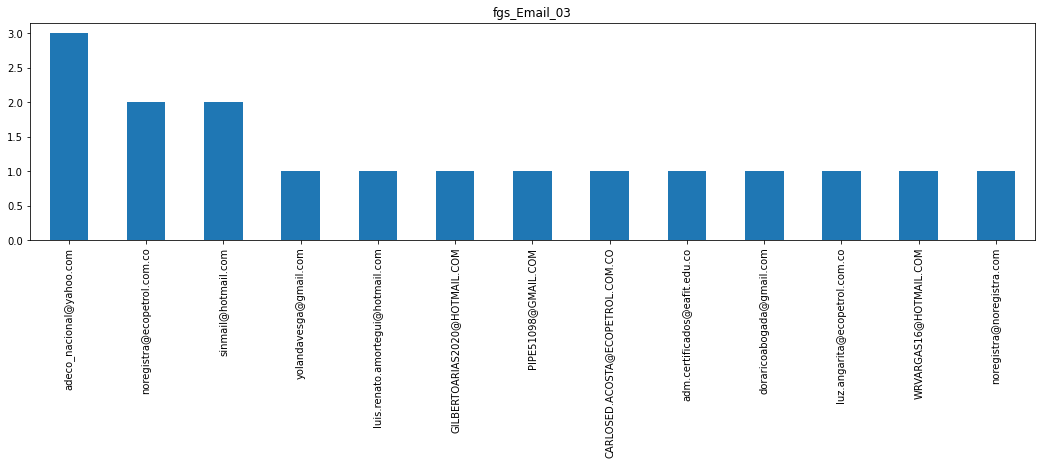

Email BackOffice           6220
Telefónico                 5981
Oficina De Atención CAL    1403
Chat                        124
Escrito Radicado             20
Name: fmf_Canal, dtype: int64

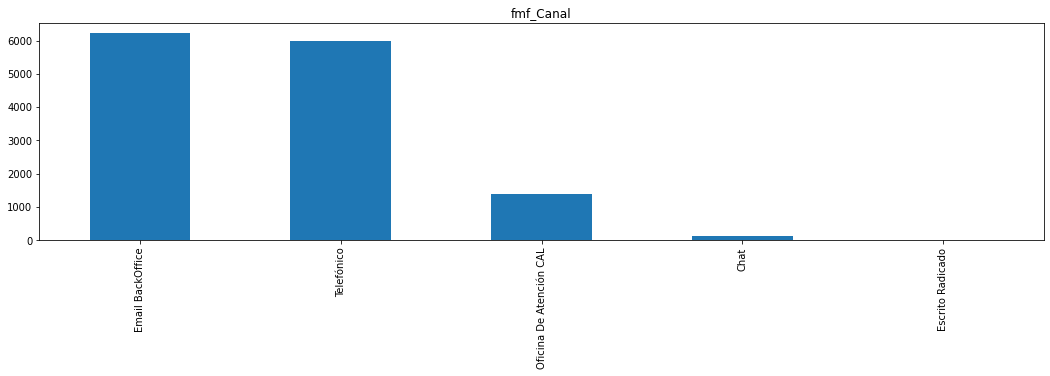

CENTRO ORIENTE       5309
MAGDALENA MEDIO      3863
NORTE                1859
LLANOS ORIENTALES     864
OCCIDENTE             615
SUR                   370
Name: ude_Regional, dtype: int64

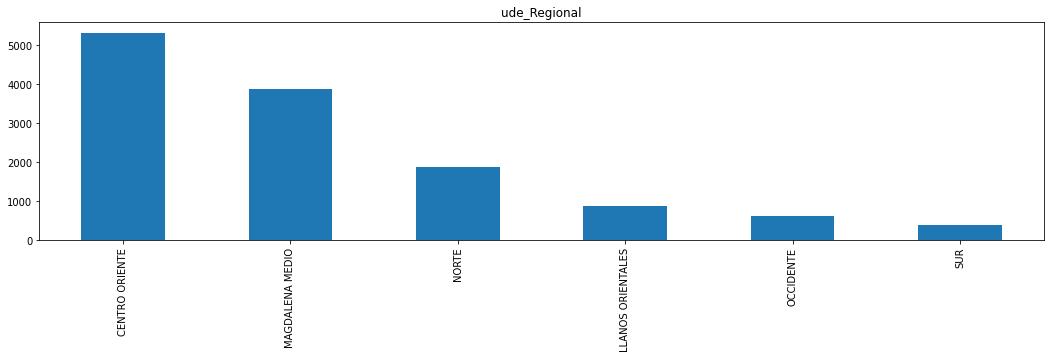

SANTANDER          5146
BOGOTA             3049
BOLIVAR            1390
META                712
N. DE SANTANDER     437
CUNDINAMARCA        402
ANTIOQUIA           284
HUILA               250
MAGDALENA           213
VALLE DEL CAUCA     184
CASANARE            132
CESAR               125
CALDAS              109
PUTUMAYO             90
ATLANTICO            88
TOLIMA               88
SUCRE                80
BOYACA               63
RISARALDA            42
CORDOBA              31
QUINDIO              21
NARIÑO               17
ARAUCA                9
Name: ude_DepartamentoCliente, dtype: int64

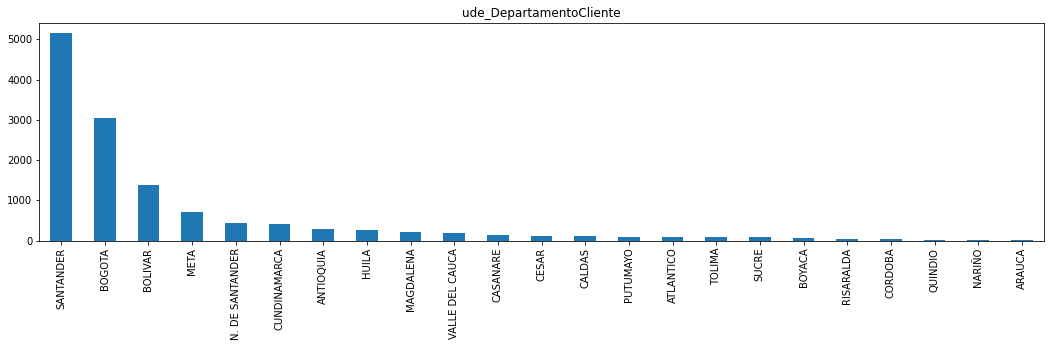

COLOMBIA    12962
Colombia      786
Name: ude_PaisCliente, dtype: int64

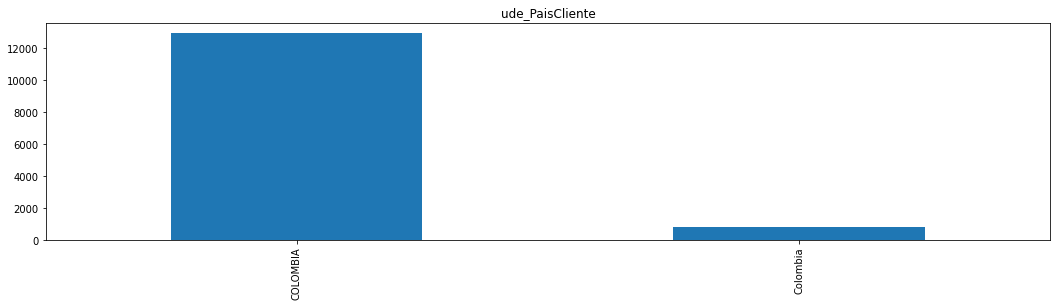

Transacciones        10135
No Aplica             2896
Puesto de Trabajo      717
Name: SistemaPago, dtype: int64

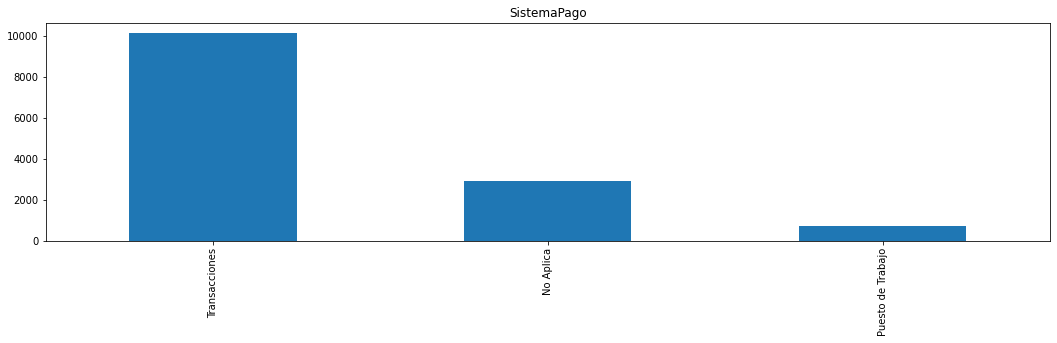

Legal / Reconocimiento Trabajadores (Incluye Bachiller ECP)                   4195
Legal / Reconocimiento Pensionados (Incluye Sustitutos)                       2415
Anticipo Trabajadores (Incluye BXC)                                           1807
Anticipo Pensionados (Incluye Sustitutos)                                     1586
Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)            1225
Soporte Plataforma para Instituciones Educativas vía TIB                      1121
Solicitud de educación inclusiva                                               414
Inscripción solicitud becas Comité de Educación Convencional Activos           353
Reintegro de dinero trabajadores Educación (Incluye Bachiller ECP)             303
Inscripción casos especiales comité de educación convencional activos           99
Reintegro de dinero Pensionados Educación (Incluye sustitutos y Auto)           58
Consulta Titulares Beneficio Eductivo - Desvinculados                           52
Soli

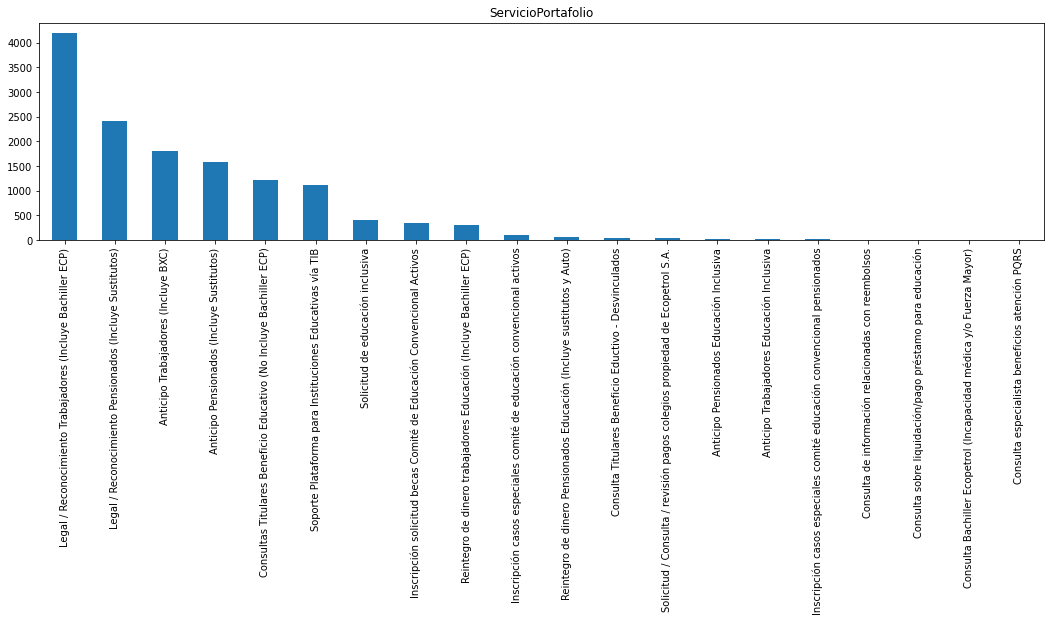

Cerrado        13718
Escalado          27
Devuelto           2
Solucionado        1
Name: fdp_NombreEstado, dtype: int64

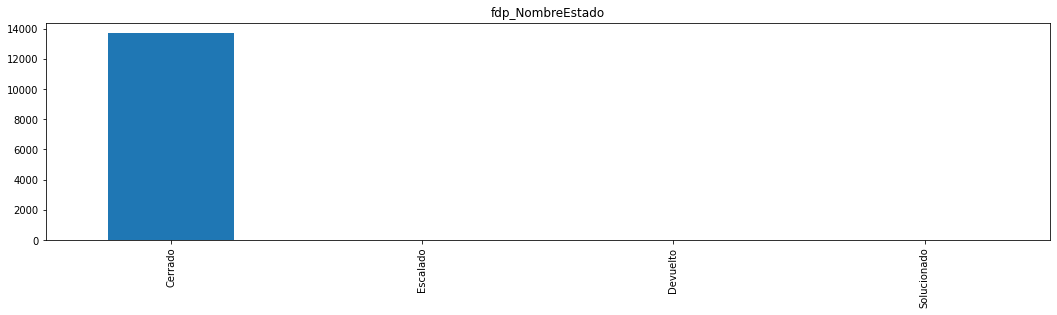

Nivel1    10752
Nivel2     2996
Name: fdp_NivelEstado, dtype: int64

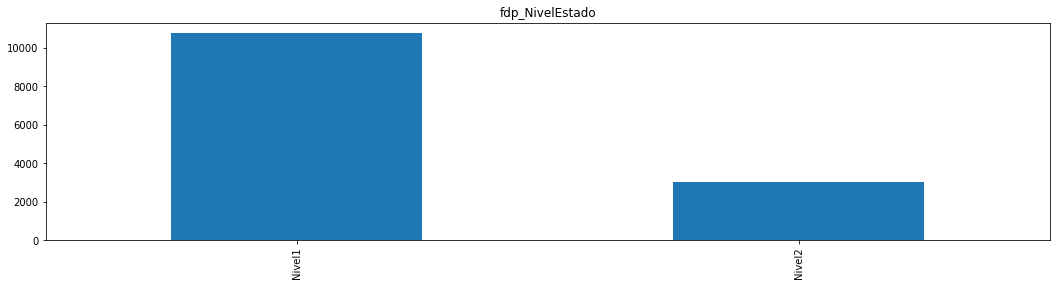

LEIDY TATIANA CARREÑO PEREZ              621
ALVARO MARIACA LEAL                      618
LEYDA ROCIO MORENO YARA                  541
DIANA MILENA GUERRERO MELLIZO            537
GILBERTO SUÁREZ                          536
LEYDI YASMIN CASTRO MORANTES             529
WILLIAM GUILLERMO FERRUCHO FERRUCHO      511
JIMMY SEBASTIAN GORDILLO GAMBOA          502
MIRYAM NATALIA MORENO BAYONA             438
INGRID GERALDIN OBANDO PEÑA              435
YEIMY PATRICIA LOZADA ALFONSO            428
ANDRES FELIPE BELTRAN URIBE              427
ANGIE PAOLA LUENGAS TUNJANO              427
EDWAR MAURICIO CRUZ                      419
SAYAN MONIQUE ESPINOSA CIFUENTES         389
MARIA FERNANDA DURAN HERRERA             385
JUSTINE MARUETH EBRAT PEÑA               367
ANDREA ANGELICA SABOGAL RODRIGUEZ        365
JHON JAIRO GOMEZ SALAZAR                 350
ANGELICA VALENTINA CAMARGO MURCIA        331
JONATHAN DARIO DORIA DIAZ                329
LIGIA OSORIO HERNÁNDEZ                   321
REINALDO  

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


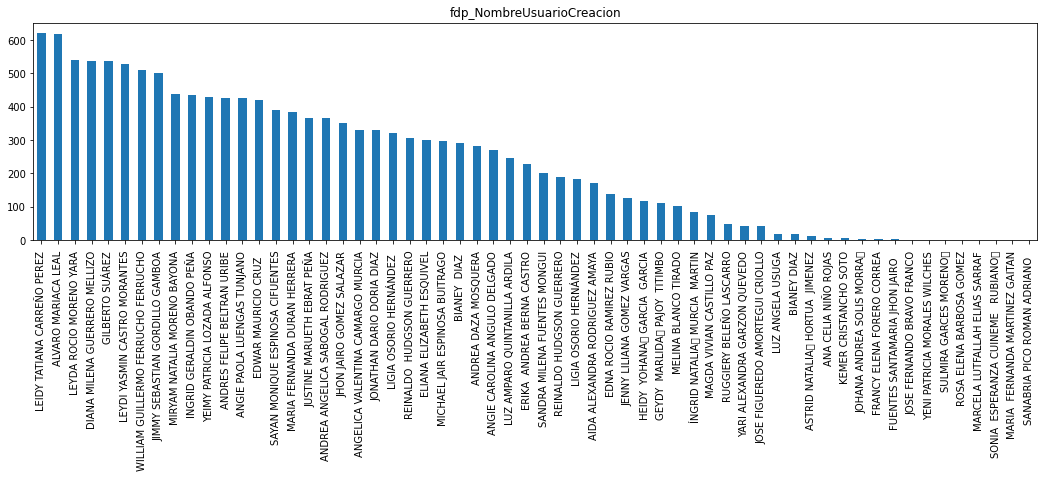

Asesor de Servicio Contact Center          10189
Asesor de Servicio Front Ecopetrol          2842
Asesor de Servicio Front Contact Center      717
Name: GrupoRolCreacion, dtype: int64

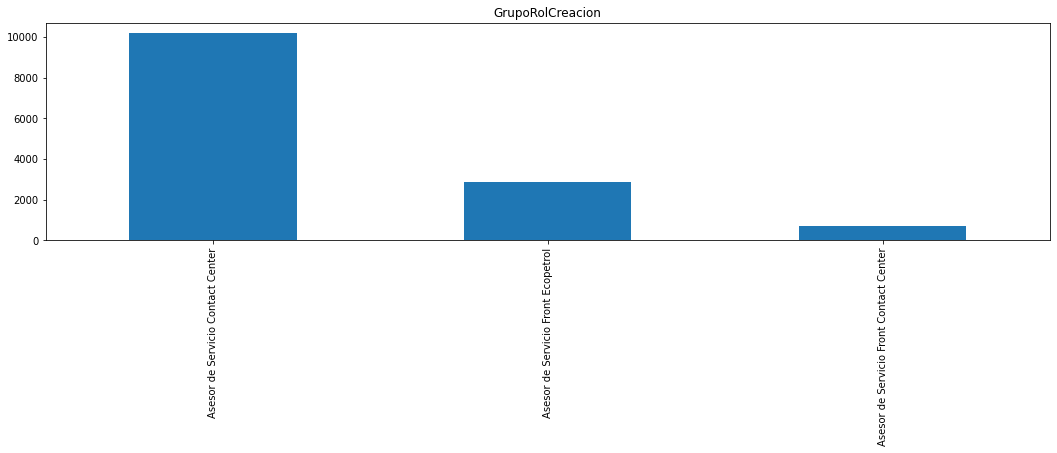

No Aplica    7508
Cumple       3639
No Cumple    2601
Name: Cumple_Objetivo_SolicitadoRegistrado, dtype: int64

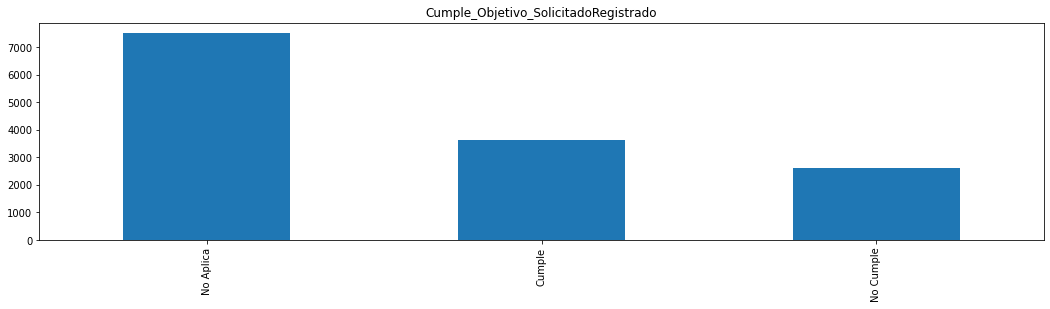

Cumple       13252
No Cumple      494
No Aplica        2
Name: Cumple_Objetivo_RegistradoEscalado, dtype: int64

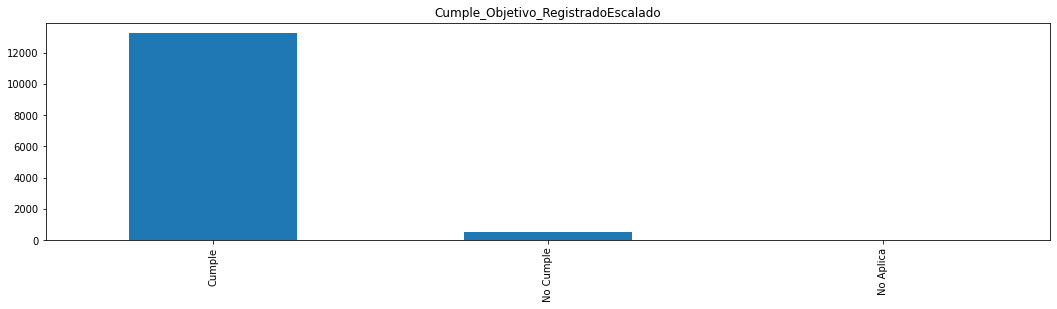

Equipo Plan Educacional                       1760
Profesional Transferencia de Información       681
Anticipos – Equipo Plan Educacional            269
Profesional Educación Inclusiva                253
Profdecolegios propiedad de Ecopetrol S.A.      28
Equipo Beneficio Educativo - Desvinculados       5
Name: fdp_NombreGrupoEscalamientoN2, dtype: int64

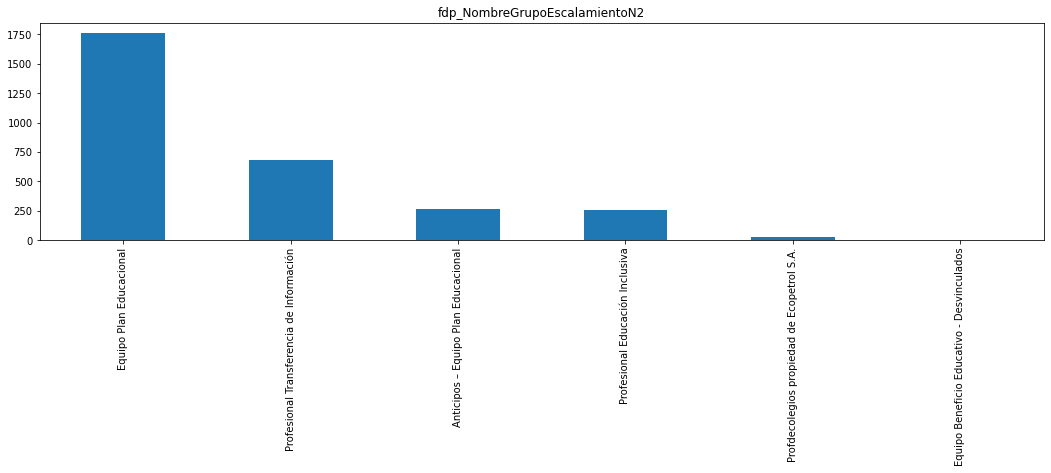

CLAUDIA CONSUELO OSTOS RUIZ       846
JENNIFERCARDOZO CARDOZO DUQUE     578
NANCY CAICEDO SALINAS             407
ASTRID GARZON RUIDIAZ             360
MARTHA IRENE QUINTERO PABON       251
LUCY STELLA CABRERA PÉREZ         206
YULI SANDOVAL                     158
LUZ ANGELA USUGA                  127
MARIA FERNANDA ROJAS               28
BIANEY DIAZ                         8
BIANEY  DIAZ                        1
Lady Lorena Coy Rozo                1
ALVARO MARIACA LEAL                 1
Name: fdp_NombreUsuarioEscalamientoN2, dtype: int64

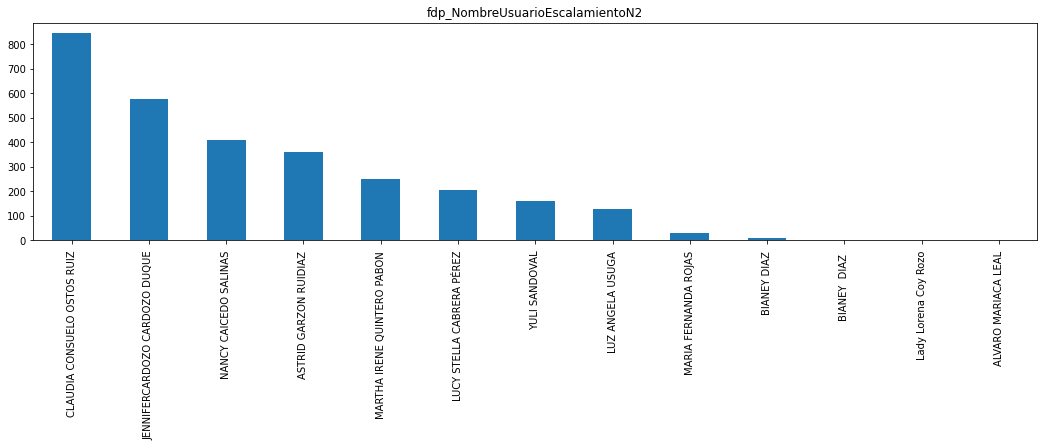

Asesor solucionador Ecopetrol         2265
Asesor de Servicio Front Ecopetrol     707
Name: GrupoRolEscalamientoN2, dtype: int64

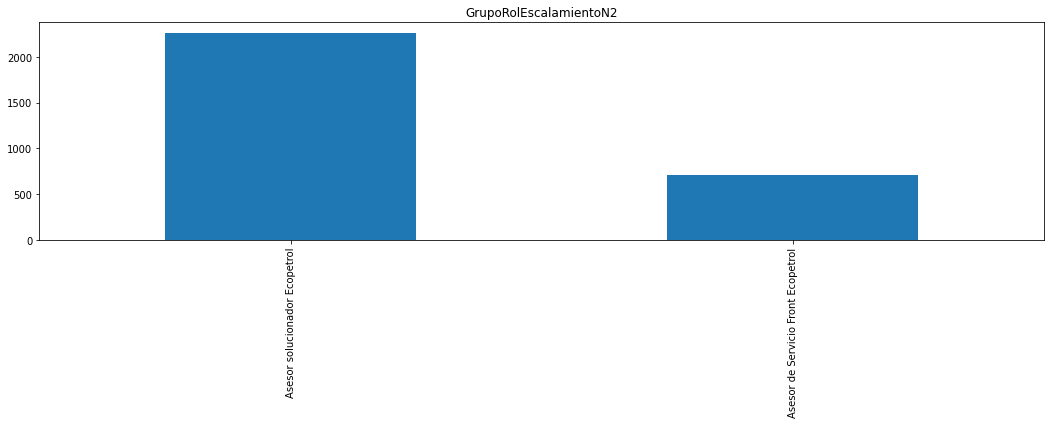

No Aplica    10779
Cumple        2856
No Cumple      113
Name: Cumple_Objetivo_EnNivel2, dtype: int64

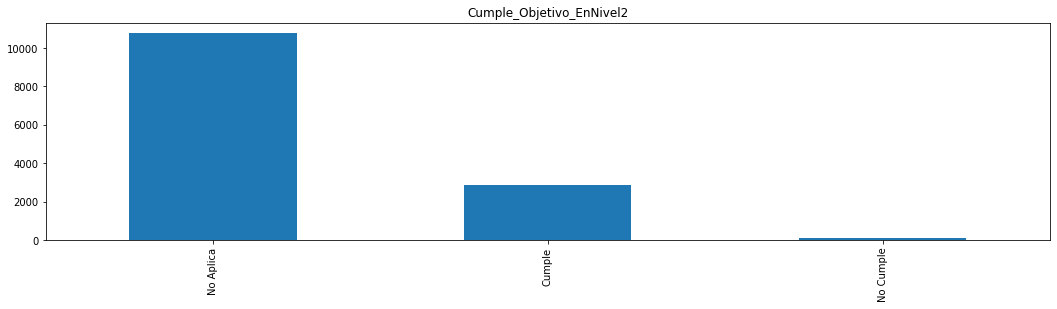

JIMMY SEBASTIAN GORDILLO GAMBOA       18
SANDRA MILENA FUENTES MONGUI          16
MARIA FERNANDA DURAN HERRERA          13
ALVARO MARIACA LEAL                   12
LIGIA OSORIO HERNÁNDEZ                12
REINALDO  HUDGSON GUERRERO            11
DIANA MILENA GUERRERO MELLIZO         10
GILBERTO SUÁREZ                        9
LEYDI YASMIN CASTRO MORANTES           9
LEIDY TATIANA CARREÑO PEREZ            8
ANDRES FELIPE BELTRAN URIBE            7
REINALDO HUDGSON GUERRERO              7
EDNA ROCIO RAMIREZ RUBIO               6
LIGIA OSORIO HERNÁNDEZ                 6
INGRID GERALDIN OBANDO PEÑA            6
MAGDA VIVIAN CASTILLO PAZ              6
AIDA ALEXANDRA RODRIGUEZ AMAYA         5
SAYAN MONIQUE ESPINOSA CIFUENTES       5
BIANEY  DIAZ                           5
ANDREA DAZA MOSQUERA                   5
MIRYAM NATALIA MORENO BAYONA           5
ELIANA ELIZABETH ESQUIVEL              4
EDWAR MAURICIO CRUZ                    4
LUZ AMPARO QUINTANILLA ARDILA          3
JHON JAIRO GOMEZ

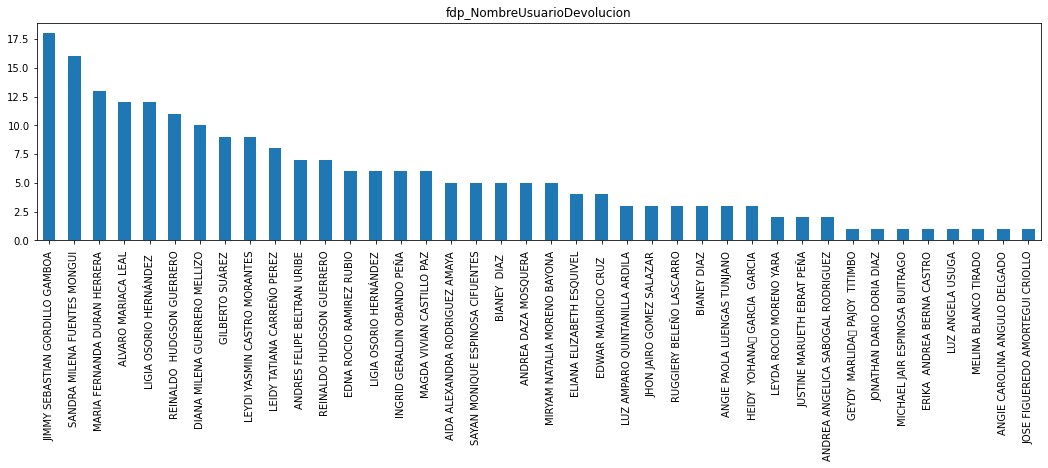

Asesor de Servicio Contact Center          124
Asesor de Servicio Front Ecopetrol          70
Asesor de Servicio Front Contact Center     27
Name: GrupoRolDevolucion, dtype: int64

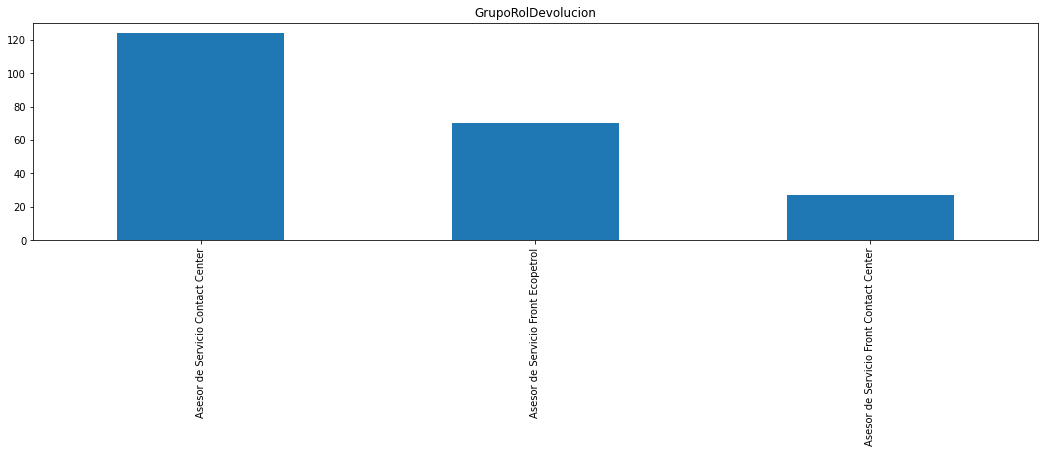

Escalado al responsable de solución equivocado                                     73
No se encuentra formato de soporte o no es legible                                 41
Recepción de solicitud incompleta  no se validaron correctamente los requisitos    38
La solución depende de otro nivel de soporte                                       15
Escalado al responsable equivocado                                                 10
No adjunto soportes                                                                 2
Name: fdp_MotivoDevolucion, dtype: int64

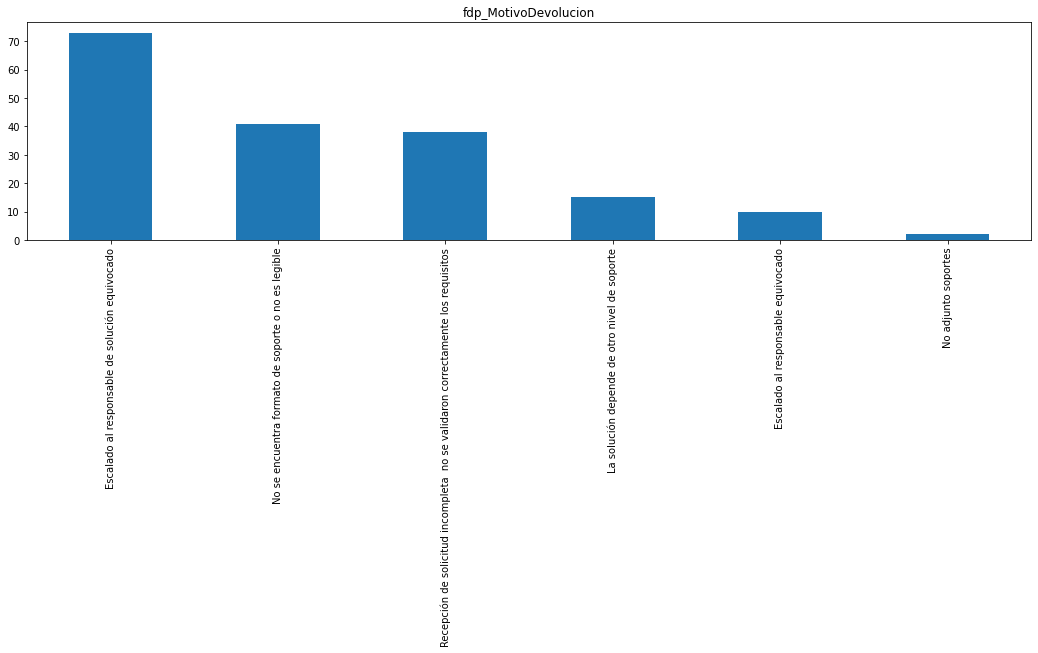

Grupo Primer Nivel Personal                   10750
Equipo Plan Educacional                        1734
Profesional Transferencia de Información        681
Anticipos – Equipo Plan Educacional             268
Profesional Educación Inclusiva                 253
Profdecolegios propiedad de Ecopetrol S.A.       28
Equipo Beneficio Educativo - Desvinculados        5
Name: fdp_NombreGrupoSolucion, dtype: int64

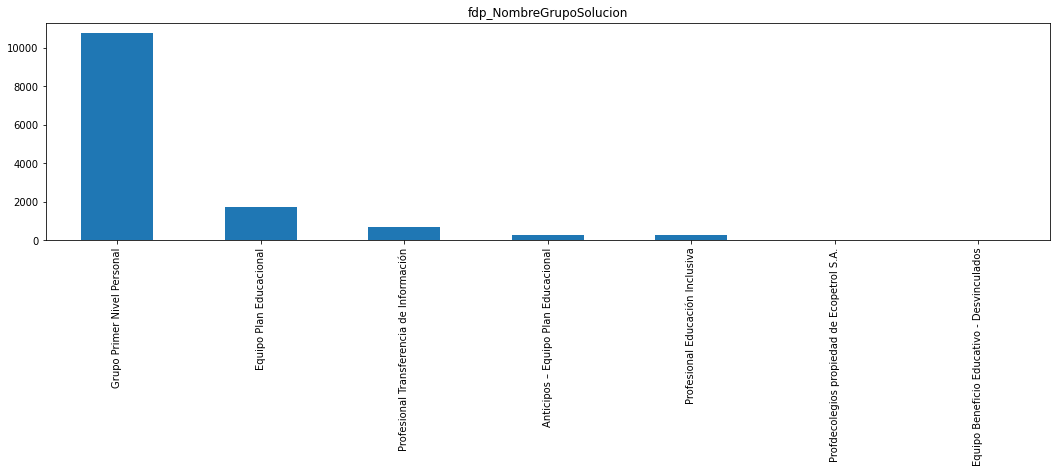

LEIDY TATIANA CARREÑO PEREZ             579
JENNIFERCARDOZO CARDOZO DUQUE           543
LEYDA ROCIO MORENO YARA                 525
CLAUDIA CONSUELO OSTOS RUIZ             477
WILLIAM GUILLERMO FERRUCHO FERRUCHO     471
                                       ... 
LEIDY TATIANA CARREÑO PEREZ               1
MARCELA LUTFALLAH ELIAS SARRAF            1
ROSA ELENA BARBOSA GOMEZ                  1
MARIA  FERNANDA MARTINEZ GAITAN           1
FRANCY ELENA FORERO CORREA                1
Name: fdp_NombreUsuarioSolucion, Length: 67, dtype: int64

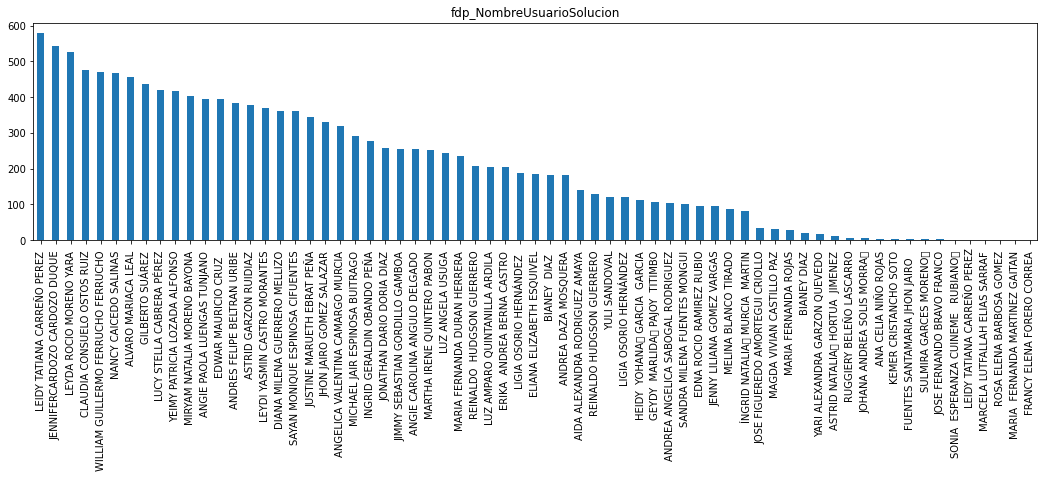

Asesor de Servicio Contact Center          8286
Asesor de Servicio Front Ecopetrol         2704
Asesor solucionador Ecopetrol              2274
Asesor de Servicio Front Contact Center     455
Name: GrupoRolSolucion, dtype: int64

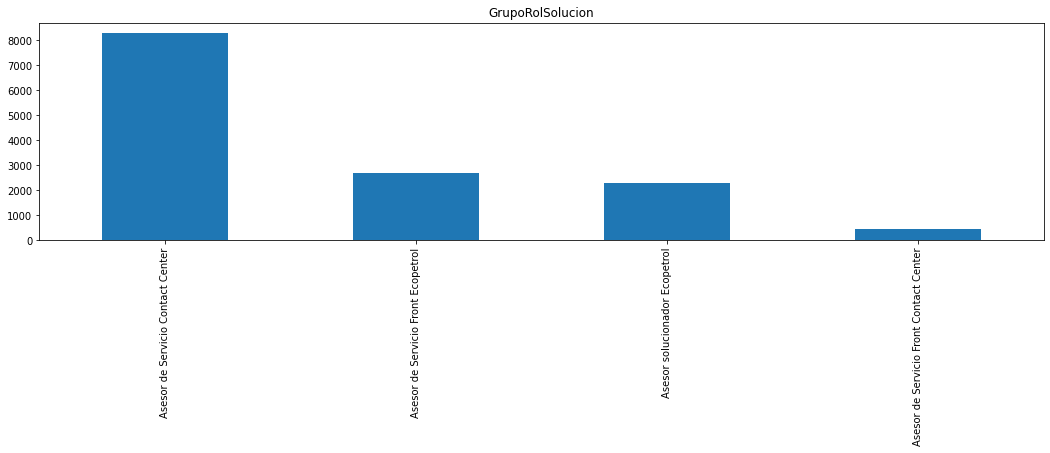

Nivel1    10750
Nivel2     2969
Name: fdp_NivelSolucion, dtype: int64

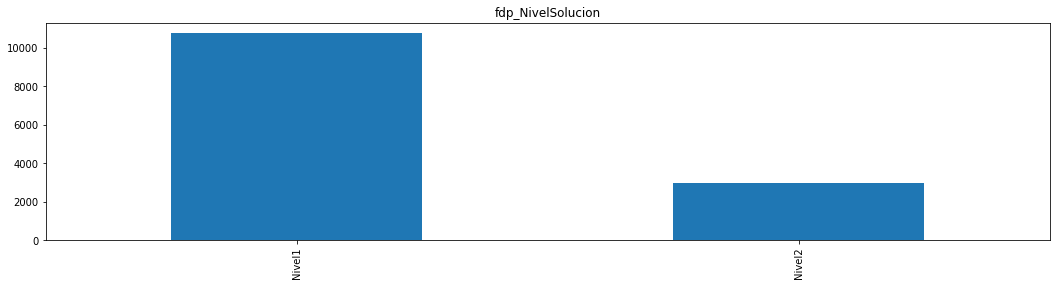

Cumple       13717
No Aplica       30
No Cumple        1
Name: Cumple_Objetivo_SolucionadoCerrado, dtype: int64

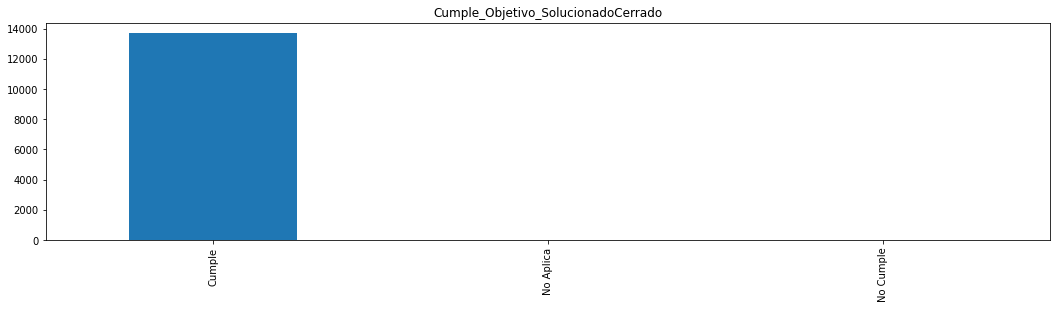

Grupo Primer Nivel Personal                   10750
Equipo Plan Educacional                        1733
Profesional Transferencia de Información        681
Anticipos – Equipo Plan Educacional             268
Profesional Educación Inclusiva                 253
Profdecolegios propiedad de Ecopetrol S.A.       28
Equipo Beneficio Educativo - Desvinculados        5
Name: fdp_NombreGrupoCierre, dtype: int64

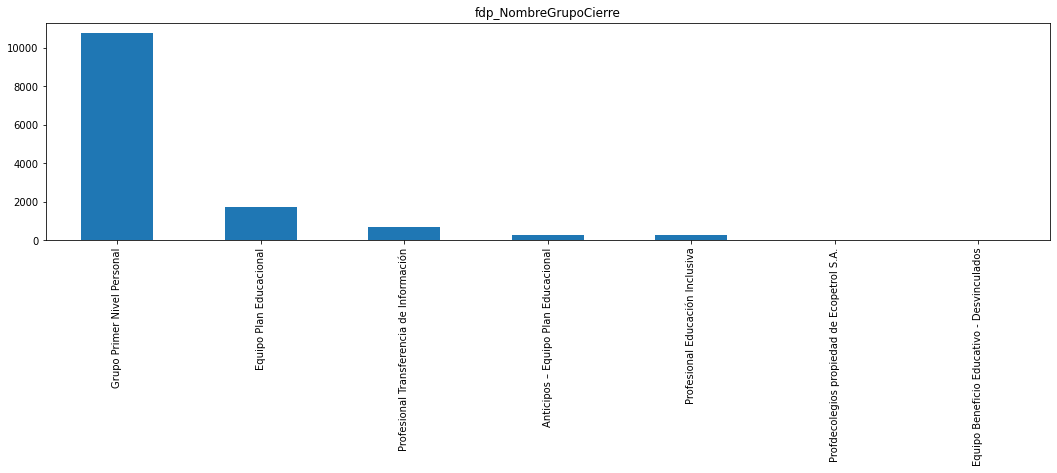

LEIDY TATIANA CARREÑO PEREZ              579
JENNIFERCARDOZO CARDOZO DUQUE            543
LEYDA ROCIO MORENO YARA                  525
CLAUDIA CONSUELO OSTOS RUIZ              477
WILLIAM GUILLERMO FERRUCHO FERRUCHO      471
                                        ... 
SONIA  ESPERANZA CUINEME   RUBIANO\t       1
LEIDY TATIANA CARREÑO PEREZ                1
MARCELA LUTFALLAH ELIAS SARRAF             1
MARIA  FERNANDA MARTINEZ GAITAN            1
FRANCY ELENA FORERO CORREA                 1
Name: fdp_NombreUsuarioCierre, Length: 66, dtype: int64

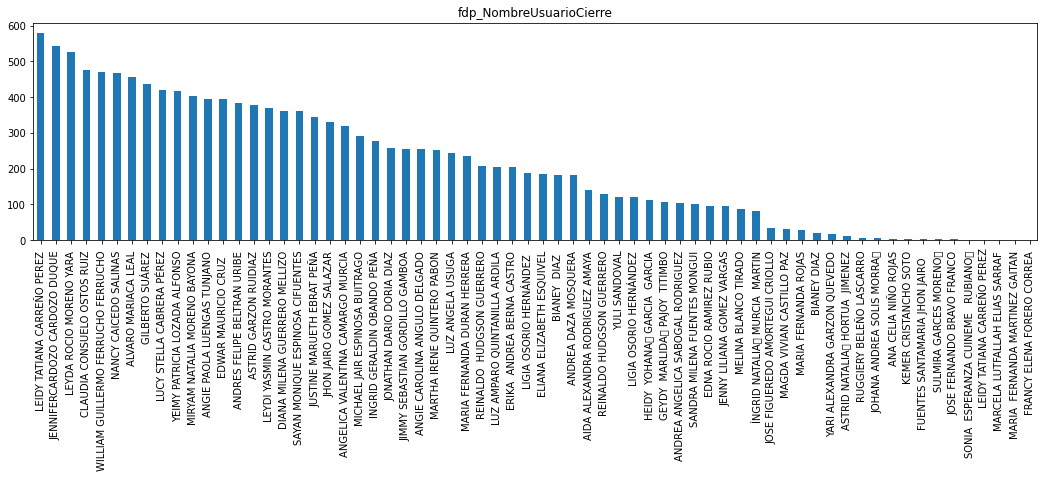

Asesor de Servicio Contact Center          8254
Asesor de Servicio Front Ecopetrol         2703
Asesor solucionador Ecopetrol              2306
Asesor de Servicio Front Contact Center     455
Name: GrupoRolCierre, dtype: int64

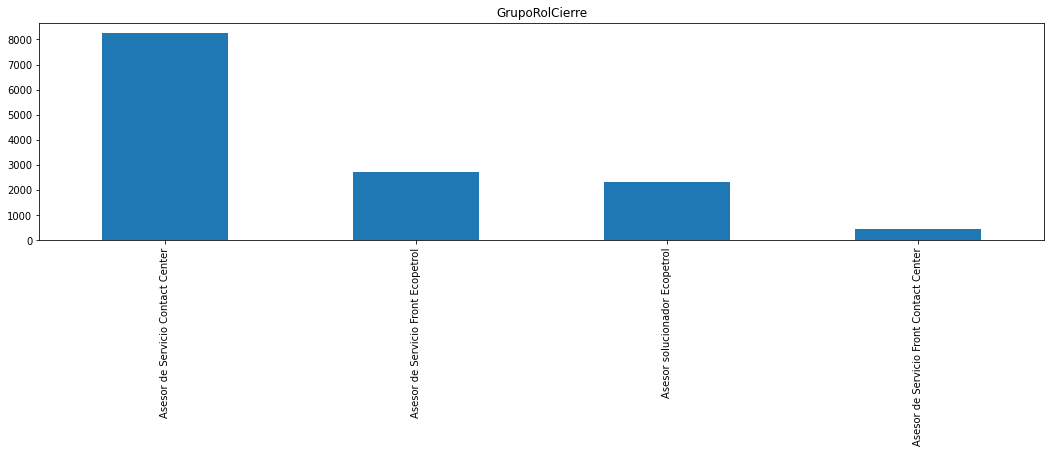

Nivel1    10750
Nivel2     2968
Name: fdp_NivelCierre, dtype: int64

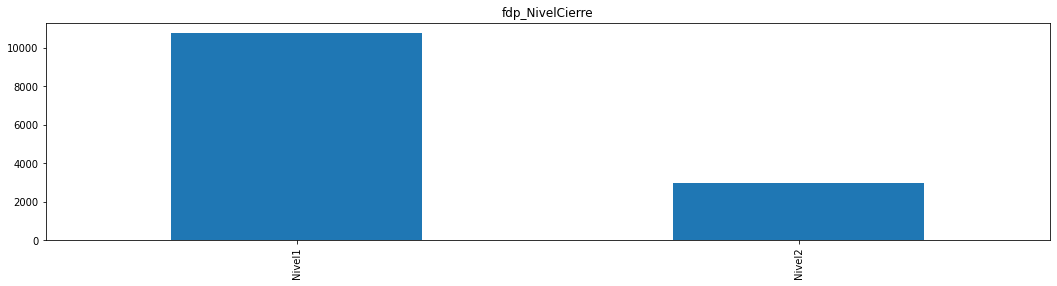

Grupo Primer Nivel Personal                   10752
Equipo Plan Educacional                        1760
Profesional Transferencia de Información        681
Anticipos – Equipo Plan Educacional             269
Profesional Educación Inclusiva                 253
Profdecolegios propiedad de Ecopetrol S.A.       28
Equipo Beneficio Educativo - Desvinculados        5
Name: fdp_NombreGrupoGestionActual, dtype: int64

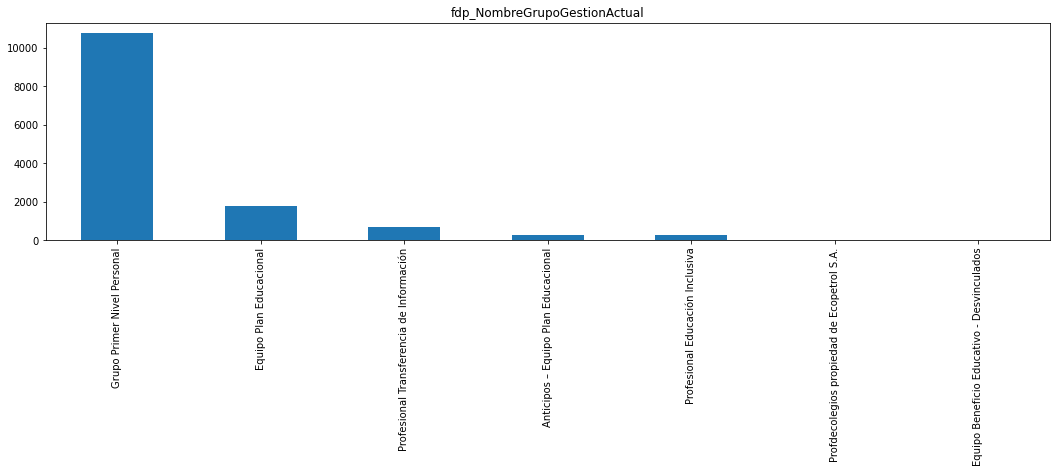

LEIDY TATIANA CARREÑO PEREZ              579
JENNIFERCARDOZO CARDOZO DUQUE            543
LEYDA ROCIO MORENO YARA                  525
CLAUDIA CONSUELO OSTOS RUIZ              477
WILLIAM GUILLERMO FERRUCHO FERRUCHO      471
                                        ... 
SONIA  ESPERANZA CUINEME   RUBIANO\t       1
LEIDY TATIANA CARREÑO PEREZ                1
MARCELA LUTFALLAH ELIAS SARRAF             1
MARIA  FERNANDA MARTINEZ GAITAN            1
FRANCY ELENA FORERO CORREA                 1
Name: fdp_NombreUsuarioGestionActual, Length: 66, dtype: int64

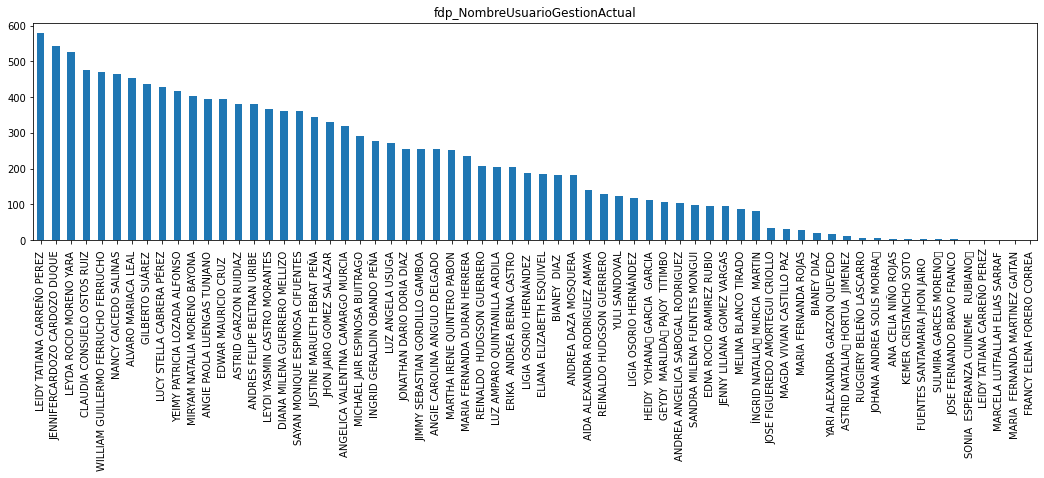

Asesor de Servicio Contact Center          8255
Asesor de Servicio Front Ecopetrol         2732
Asesor solucionador Ecopetrol              2306
Asesor de Servicio Front Contact Center     455
Name: GrupoRolGestionActual, dtype: int64

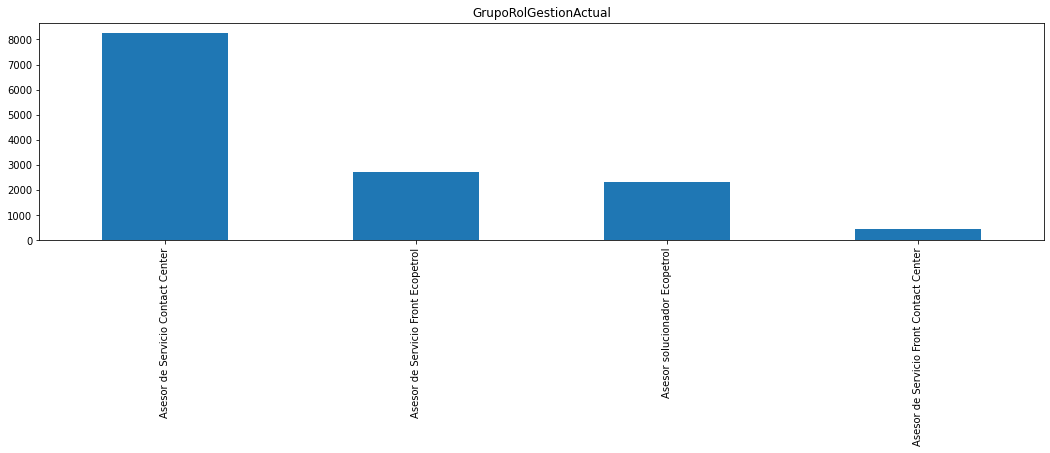

Escalado al responsable de solución equivocado    1
La solución depende de otro nivel de soporte      1
Name: fdp_MotivoGestionActual, dtype: int64

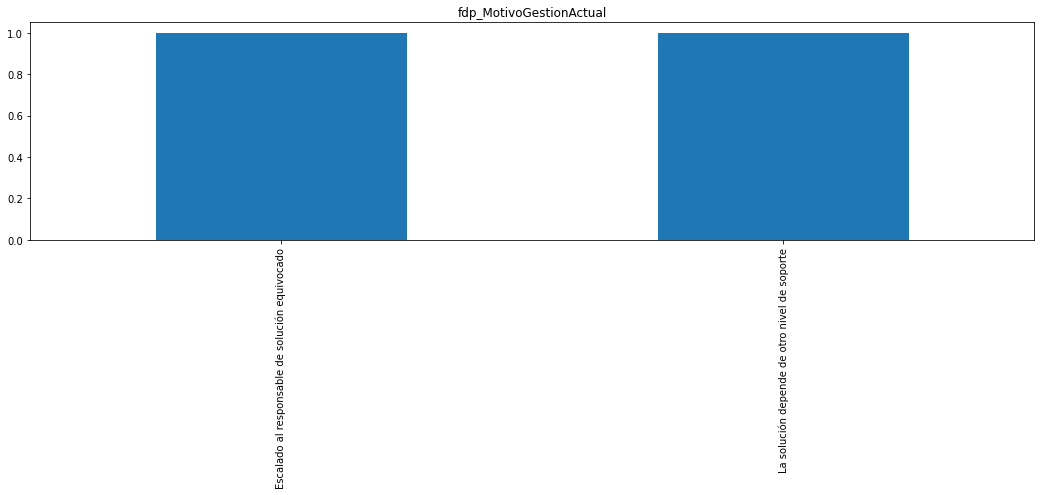

Nivel1    10752
Nivel2     2996
Name: fdp_NivelGestionActual, dtype: int64

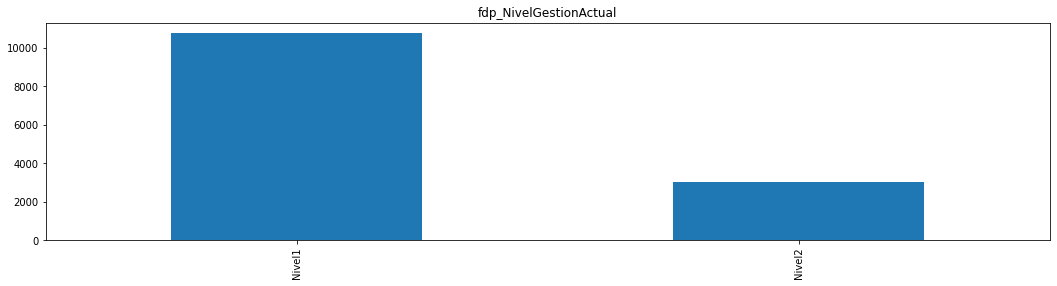

Fecha Superior a la fecha de creación o Fecha Nula      4107
Fecha de Modificación Menor a la del estado anterior    2679
Name: TipoAjuste, dtype: int64

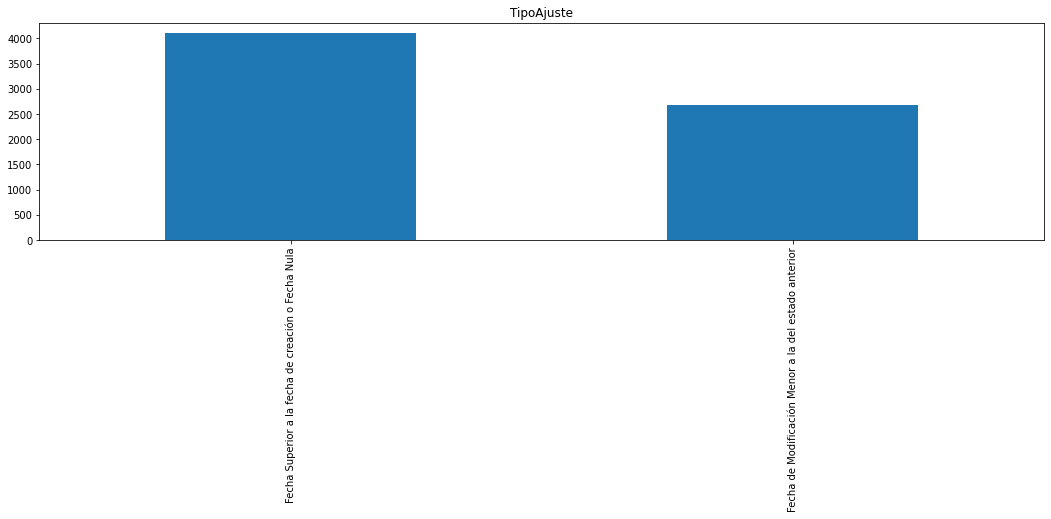

In [42]:
lista_menores = []
lista_mayores = []
for i in objetos.columns:
  
  if objetos[i].nunique()<=100:
    display(objetos[i].value_counts())
    objetos[i].value_counts().plot.bar(title=i,figsize=(18,4))
    plt.show()
    lista_menores.append(i)
  else:
    lista_mayores.append(i)
# nota aparece un valor con un valor pero se deve a que despues de la limpieza se elimino 'Prestador de Servicios de Salud'

count    1.374800e+04
mean     1.912853e+08
std      4.412214e+08
min      1.000000e+03
5%       5.579628e+06
25%      1.388002e+07
50%      7.200537e+07
75%      9.134069e+07
95%      1.096238e+09
99%      1.142720e+09
max      9.010660e+09
Name: fgs_NumeroDocumContacto, dtype: float64

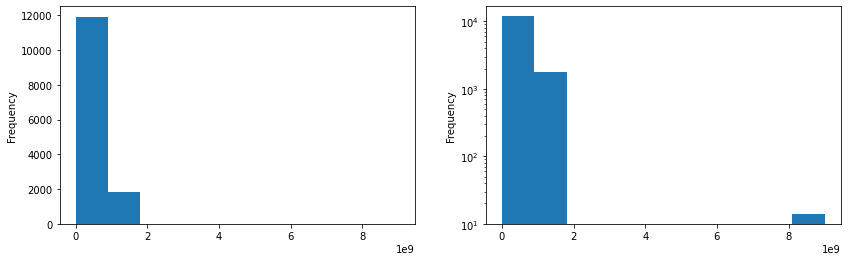

count    13748.000000
mean      4854.114926
std         11.461088
min       4831.000000
5%        4837.000000
25%       4839.000000
50%       4859.000000
75%       4861.000000
95%       4872.000000
99%       4872.000000
max       4874.000000
Name: fgs_IdTipificacionGestionDetalle, dtype: float64

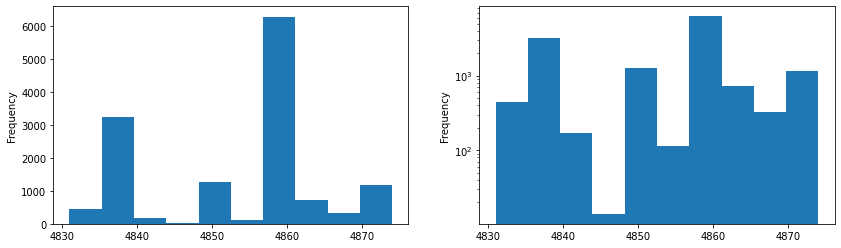

count    1.374800e+04
mean     1.050014e+09
std      1.446716e+09
min      2.000000e+06
5%       2.345000e+06
25%      1.846617e+07
50%      7.620365e+07
75%      3.105888e+09
95%      3.202252e+09
99%      3.222417e+09
max      3.512344e+09
Name: fgs_Telefono_01, dtype: float64

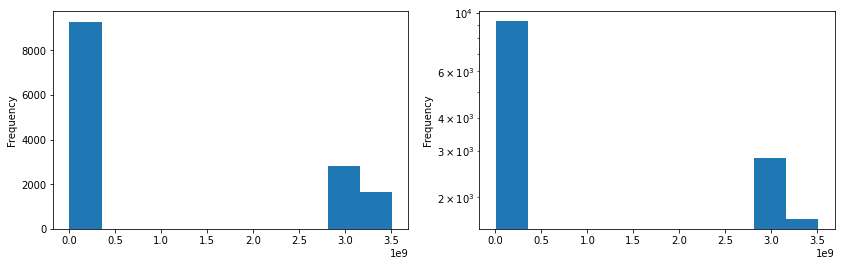

count    2.660000e+02
mean     8.873552e+08
std      1.392827e+09
min      2.000000e+06
5%       2.345000e+06
25%      6.564960e+06
50%      1.834072e+07
75%      3.006113e+09
95%      3.183391e+09
99%      3.206259e+09
max      3.507541e+09
Name: fgs_Telefono_02, dtype: float64

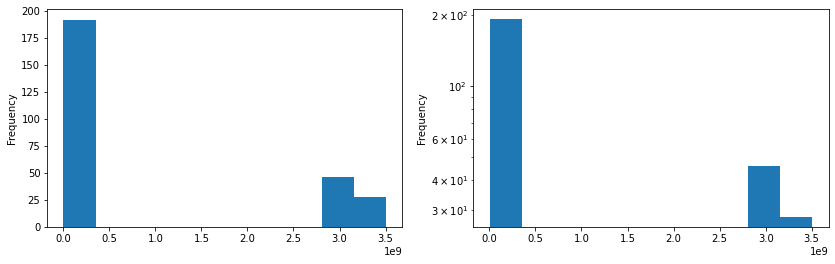

count    1.350000e+02
mean     8.125224e+08
std      1.354936e+09
min      2.345000e+06
5%       2.345000e+06
25%      6.302574e+06
50%      4.333486e+07
75%      1.545971e+09
95%      3.188487e+09
99%      3.218807e+09
max      3.233468e+09
Name: fgs_Telefono_03, dtype: float64

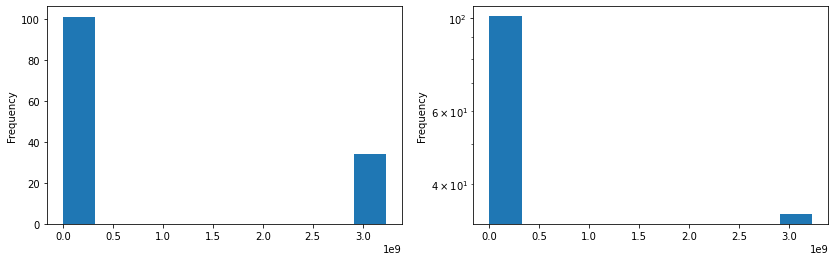

count    4.900000e+01
mean     4.009778e+08
std      1.030939e+09
min      2.291399e+06
5%       2.345000e+06
25%      6.208631e+06
50%      1.234500e+07
75%      5.631044e+07
95%      3.132461e+09
99%      3.150114e+09
max      3.153725e+09
Name: fgs_Telefono_04, dtype: float64

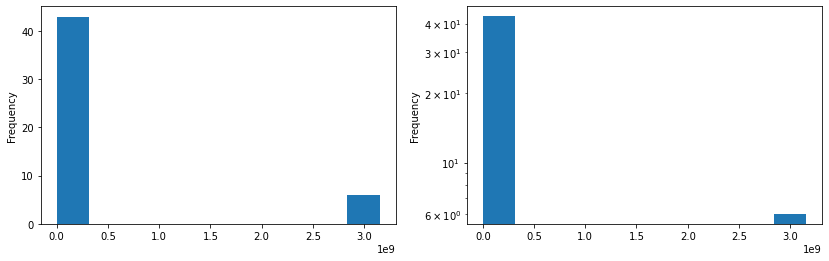

count     13748.00000
mean      37509.84245
std       71467.58521
min           0.00000
5%            0.00000
25%           0.00000
50%           0.00000
75%           0.00000
95%      206732.20000
99%      215327.27000
max      261201.00000
Name: fdp_IdPqr, dtype: float64

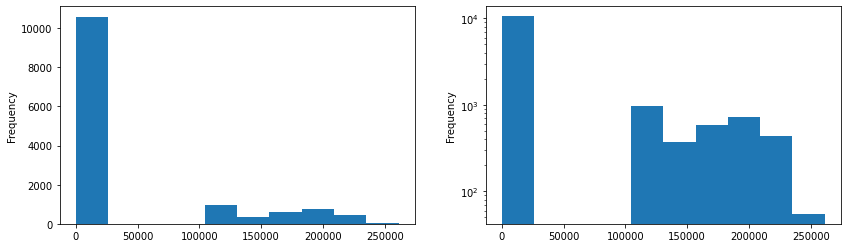

count    13748.000000
mean         1.002764
std          0.070277
min          1.000000
5%           1.000000
25%          1.000000
50%          1.000000
75%          1.000000
95%          1.000000
99%          1.000000
max          5.000000
Name: fdp_IdEstado, dtype: float64

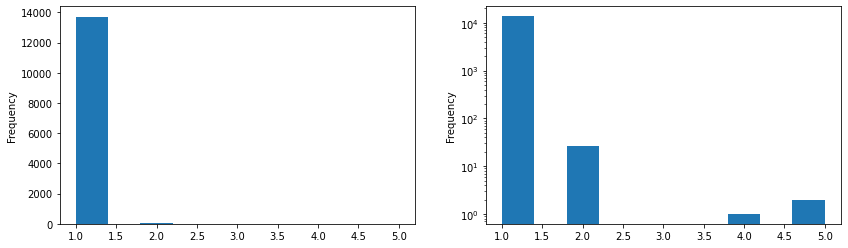

count    3156.000000
mean      150.652725
std        53.134627
min        26.000000
5%         26.000000
25%       137.000000
50%       137.000000
75%       211.000000
95%       216.000000
99%       216.000000
max       217.000000
Name: fdp_IdFlujo, dtype: float64

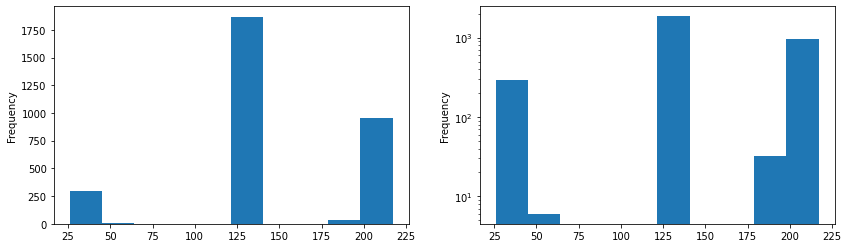

count    13748.000000
mean         2.308918
std          1.263237
min          0.000000
5%           0.000000
25%          3.000000
50%          3.000000
75%          3.000000
95%          3.000000
99%          3.000000
max          3.000000
Name: fdp_IdHistoricoPqrCreacion, dtype: float64

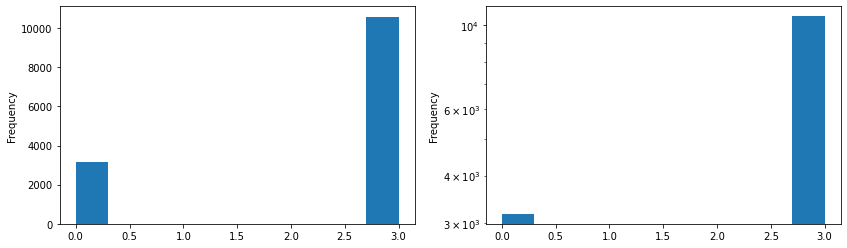

count    13748.000000
mean       741.165624
std       1304.350690
min         45.000000
5%          52.000000
25%        106.000000
50%        153.000000
75%        667.000000
95%       2901.000000
99%       7809.000000
max       8082.000000
Name: fdp_IdUsuarioCreacion, dtype: float64

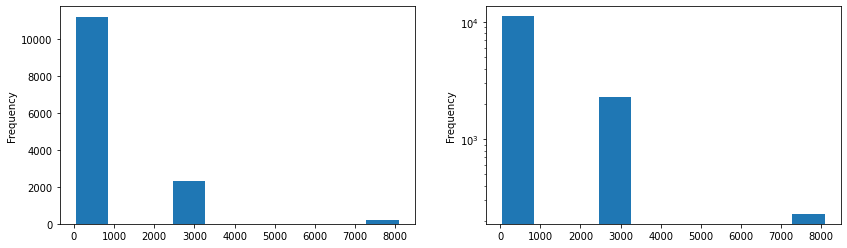

count    1.374800e+04
mean     8.812888e+08
std      1.734778e+09
min      1.388963e+07
5%       3.021085e+07
25%      5.290282e+07
50%      1.002524e+09
75%      1.022981e+09
95%      1.100482e+09
99%      9.128158e+09
max      9.128158e+09
Name: fdp_UsuarioCreacion, dtype: float64

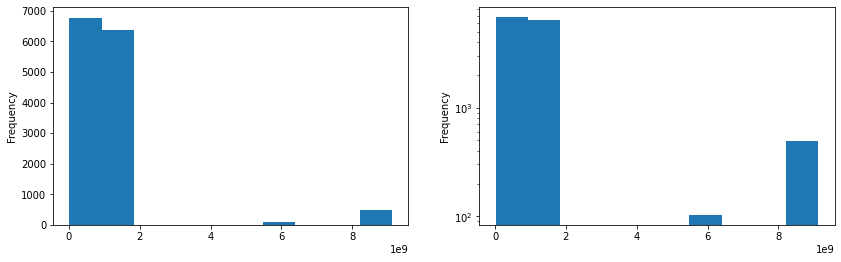

count    13748.000000
mean         1.724469
std          1.242722
min          1.000000
5%           1.000000
25%          1.000000
50%          1.000000
75%          3.000000
95%          4.000000
99%          4.000000
max          4.000000
Name: CodigoGrupoRolCreacion, dtype: float64

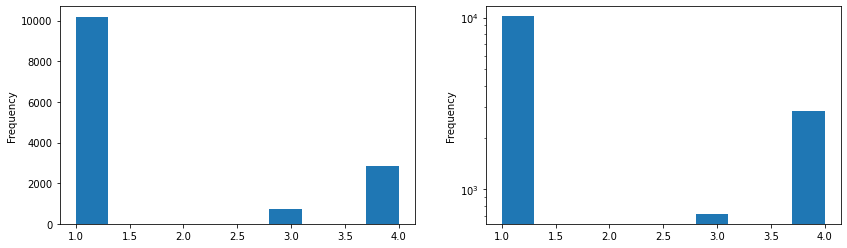

count     6240.000000
mean       296.726923
std        491.990115
min          0.000000
5%           0.000000
25%          4.000000
50%         92.000000
75%        505.000000
95%       1080.000000
99%       2254.300000
max      10610.000000
Name: T_Real_SolicitadoRegistrado, dtype: float64

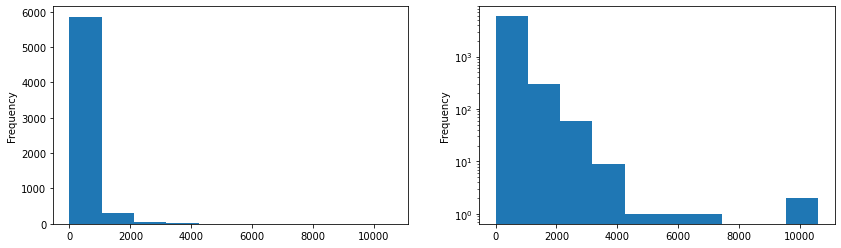

count    13746.000000
mean       139.450022
std       1029.073902
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%          0.000000
99%       5136.250000
max      21475.000000
Name: T_Real_RegistradoEscalado, dtype: float64

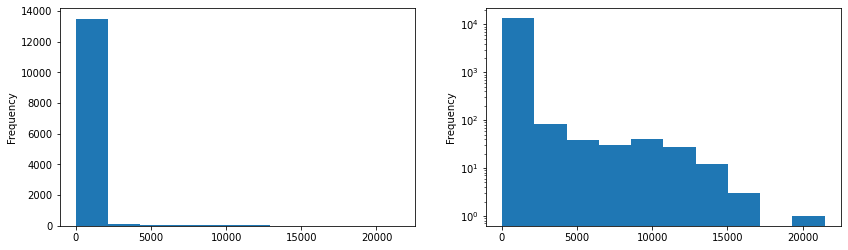

count      2996.000000
mean     463620.505674
std      135107.626033
min      275423.000000
5%       285805.000000
25%      319907.750000
50%      455138.000000
75%      602545.000000
95%      632665.250000
99%      747388.600000
max      806371.000000
Name: fdp_IdHistoricoPqrEscalamientoN2, dtype: float64

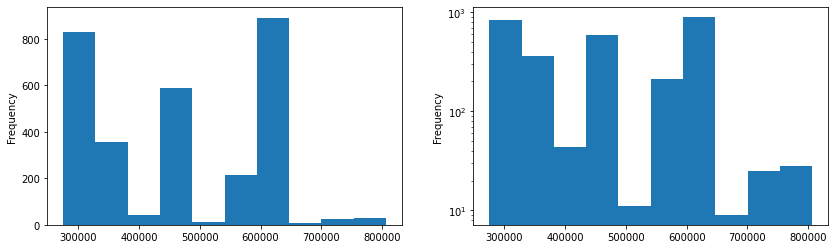

count    2996.000000
mean      196.109813
std        44.486620
min        99.000000
5%         99.000000
25%       181.000000
50%       181.000000
75%       249.000000
95%       253.000000
99%       253.000000
max       253.000000
Name: fdp_IdGrupoEscalamientoN2, dtype: float64

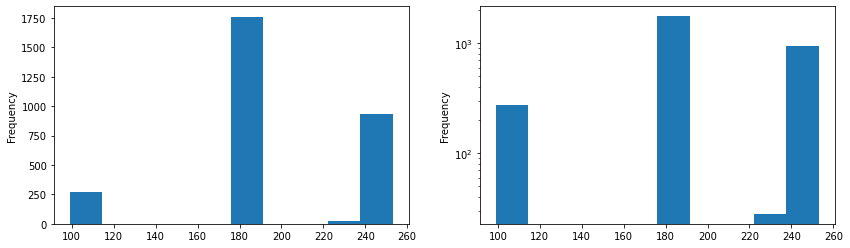

count    2996.000000
mean      184.929239
std        67.541583
min        48.000000
5%         48.000000
25%       166.000000
50%       166.000000
75%       249.000000
95%       254.000000
99%       254.000000
max       831.000000
Name: fdp_IdDetalleFlujoEscalamientoN2, dtype: float64

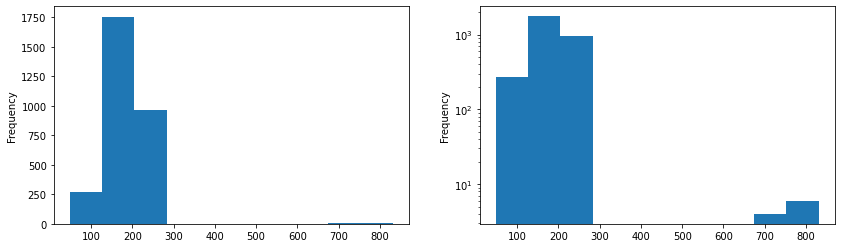

count    2972.000000
mean      318.110363
std        79.501649
min        31.000000
5%        281.000000
25%       281.000000
50%       283.000000
75%       321.000000
95%       533.000000
99%       535.000000
max       535.000000
Name: fdp_IdUsuarioEscalamientoN2, dtype: float64

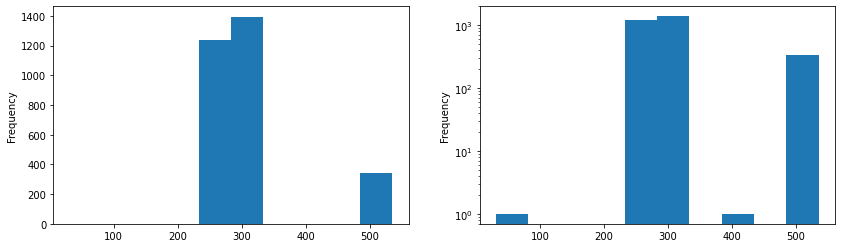

count    2.972000e+03
mean     2.431756e+08
std      3.802506e+08
min      4.032626e+07
5%       5.201427e+07
25%      5.201427e+07
50%      5.983548e+07
75%      6.346556e+07
95%      1.016001e+09
99%      1.016001e+09
max      1.030571e+09
Name: fdp_UsuarioEscalamientoN2, dtype: float64

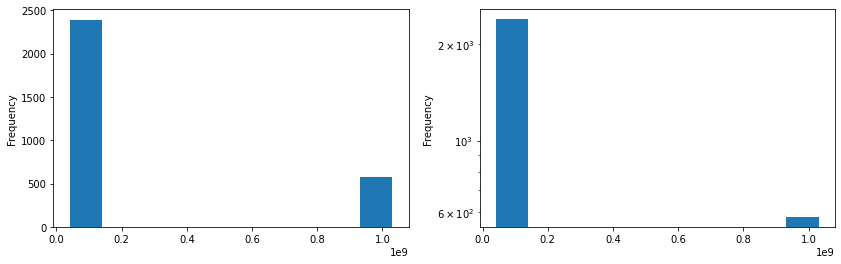

count    2972.000000
mean        5.524226
std         0.851722
min         4.000000
5%          4.000000
25%         6.000000
50%         6.000000
75%         6.000000
95%         6.000000
99%         6.000000
max         6.000000
Name: CodigoGrupoRolEscalamientoN2, dtype: float64

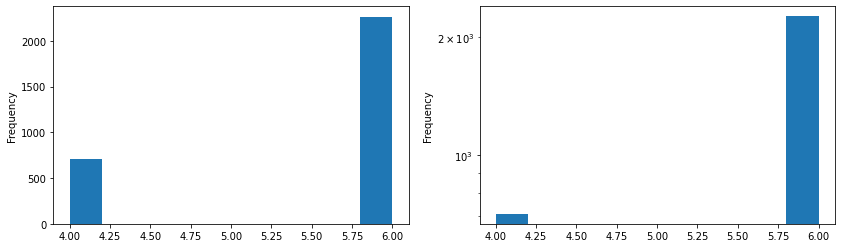

count     2996.000000
mean     11788.618158
std       2524.338124
min       4320.000000
5%        8100.000000
25%       8640.000000
50%      13500.000000
75%      13500.000000
95%      13500.000000
99%      13500.000000
max      13500.000000
Name: T_Objetivo_EnNivel2, dtype: float64

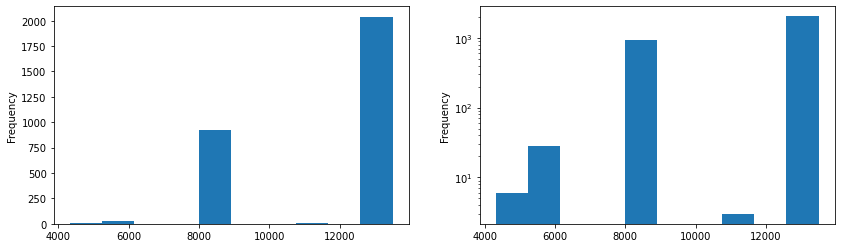

count    13561.000000
mean      1384.678416
std       3291.739678
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%       8446.000000
99%      13159.800000
max      71820.000000
Name: T_Real_EnNivel2, dtype: float64

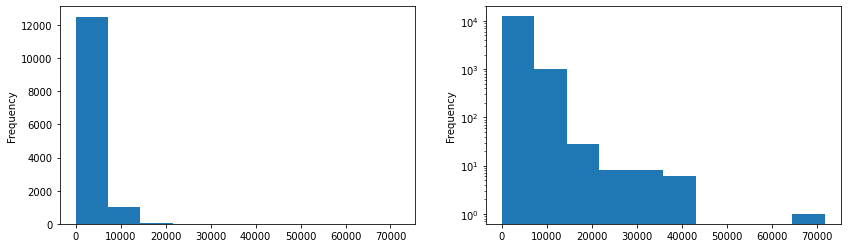

count       221.000000
mean     504559.416290
std      137153.113795
min      288842.000000
5%       315300.000000
25%      351777.000000
50%      486347.000000
75%      630661.000000
95%      688027.000000
99%      734875.400000
max      800727.000000
Name: fdp_IdHistoricoPqrDevolucion, dtype: float64

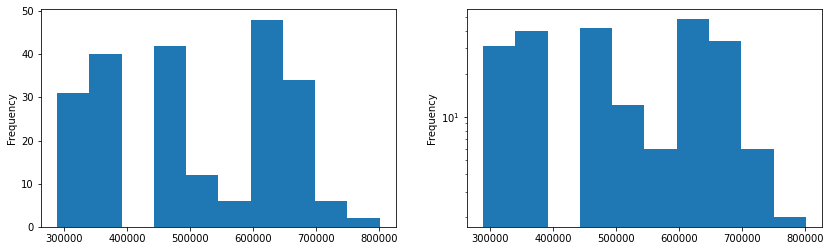

count     221.000000
mean      795.932127
std        52.190820
min       706.000000
5%        706.000000
25%       738.000000
50%       831.000000
75%       831.000000
95%       831.000000
99%       831.000000
max      1022.000000
Name: fdp_IdDetalleFlujoDevolucion, dtype: float64

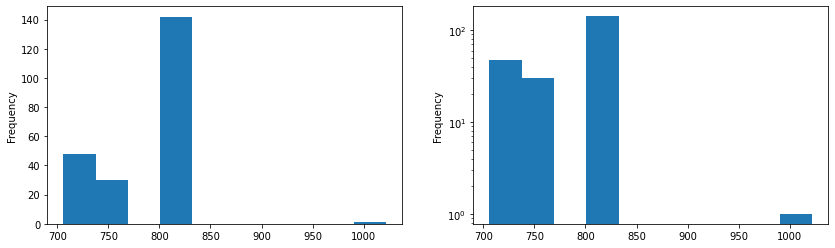

count     221.000000
mean      838.484163
std      1270.541165
min        52.000000
5%         66.000000
25%       115.000000
50%       186.000000
75%       715.000000
95%      2901.000000
99%      6846.000000
max      7809.000000
Name: fdp_IdUsuarioDevolucion, dtype: float64

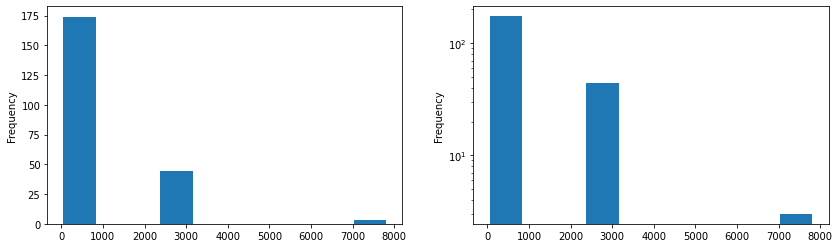

count    2.210000e+02
mean     1.307710e+09
std      2.412470e+09
min      1.388963e+07
5%       3.021085e+07
25%      5.299017e+07
50%      1.015424e+09
75%      1.031165e+09
95%      9.128158e+09
99%      9.128158e+09
max      9.128158e+09
Name: fdp_UsuarioDevolucion, dtype: float64

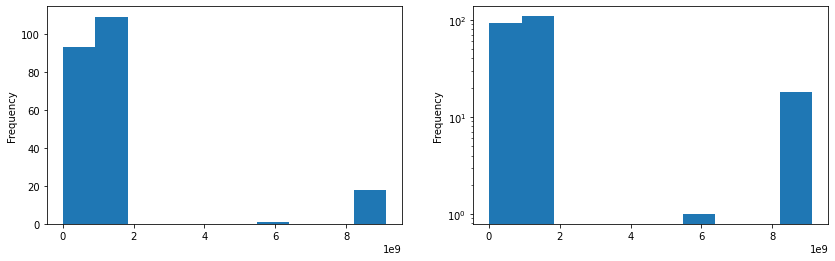

count    221.000000
mean       2.194570
std        1.386024
min        1.000000
5%         1.000000
25%        1.000000
50%        1.000000
75%        4.000000
95%        4.000000
99%        4.000000
max        4.000000
Name: CodigoGrupoRolDevolucion, dtype: float64

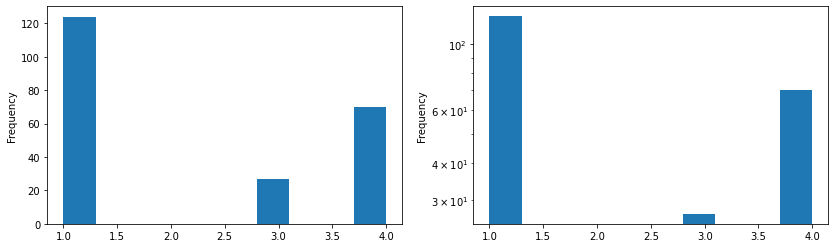

count     13719.000000
mean     113155.980757
std      219043.295102
min           0.000000
5%            4.000000
25%           4.000000
50%           4.000000
75%           4.000000
95%      643885.900000
99%      686093.020000
max      838907.000000
Name: fdp_IdHistoricoPqrSolucion, dtype: float64

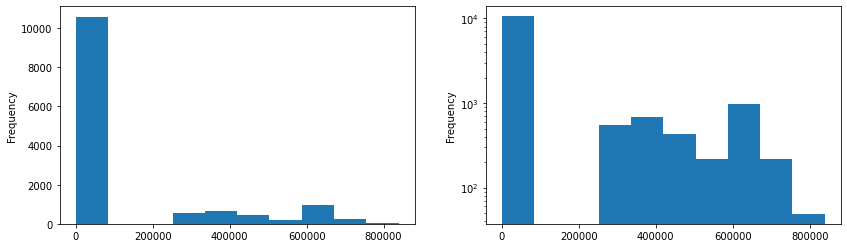

count    13719.000000
mean        47.970406
std         95.330934
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%        253.000000
99%        477.000000
max        477.000000
Name: fdp_IdGrupoSolucion, dtype: float64

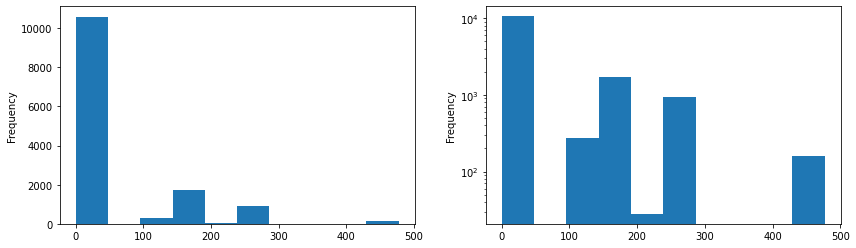

count    3127.000000
mean      216.459866
std       150.567870
min        48.000000
5%         48.000000
25%       166.000000
50%       166.000000
75%       254.000000
95%       706.000000
99%       831.000000
max       831.000000
Name: fdp_IdDetalleFlujoSolucion, dtype: float64

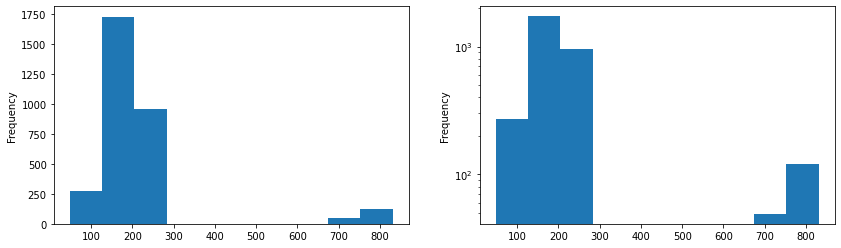

count    13719.000000
mean       686.107296
std       1235.660790
min         45.000000
5%          58.000000
25%        115.000000
50%        186.000000
75%        533.000000
95%       2556.000000
99%       7808.000000
max       8082.000000
Name: fdp_IdUsuarioSolucion, dtype: float64

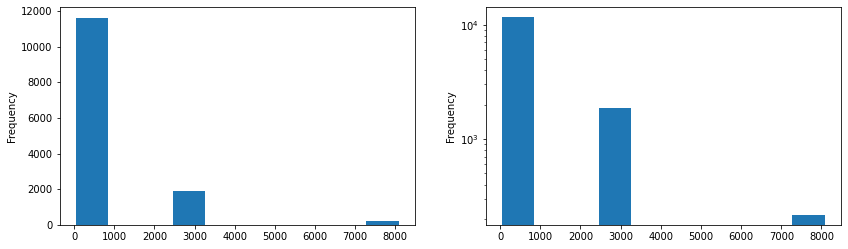

count    1.371900e+04
mean     7.098806e+08
std      1.488151e+09
min      1.388963e+07
5%       3.792905e+07
25%      5.283509e+07
50%      8.001099e+07
75%      1.019061e+09
95%      1.082312e+09
99%      9.128158e+09
max      9.128158e+09
Name: fdp_UsuarioSolucion, dtype: float64

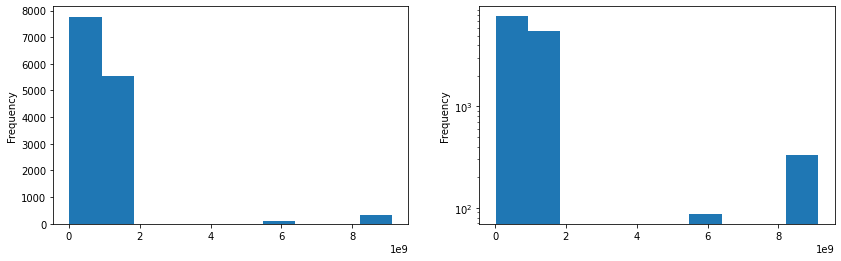

count    13719.000000
mean         2.486406
std          1.959928
min          1.000000
5%           1.000000
25%          1.000000
50%          1.000000
75%          4.000000
95%          6.000000
99%          6.000000
max          6.000000
Name: CodigoGrupoRolSolucion, dtype: float64

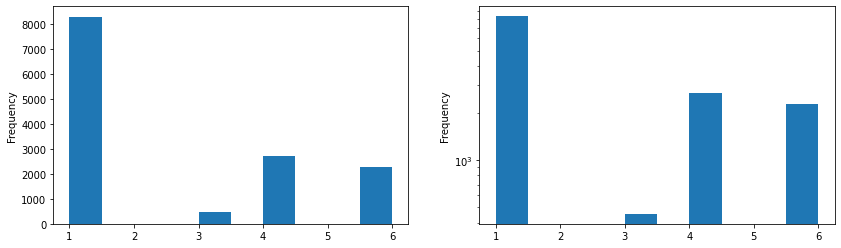

count    13718.000000
mean         1.349030
std         46.007303
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%          0.000000
99%          0.000000
max       3145.000000
Name: T_Real_SolucionadoCerrado, dtype: float64

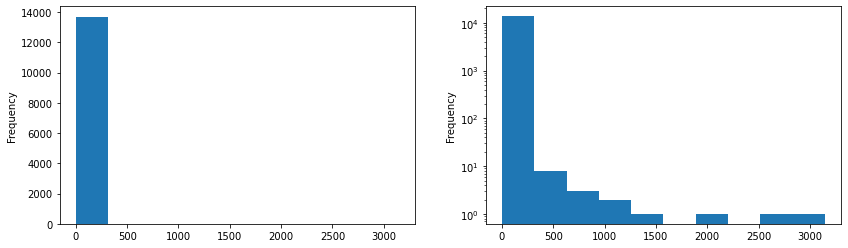

count     13718.000000
mean     113121.553506
std      219011.456128
min           0.000000
5%            4.000000
25%           4.000000
50%           4.000000
75%           4.000000
95%      643891.350000
99%      686083.300000
max      838908.000000
Name: fdp_IdHistoricoPqrCierre, dtype: float64

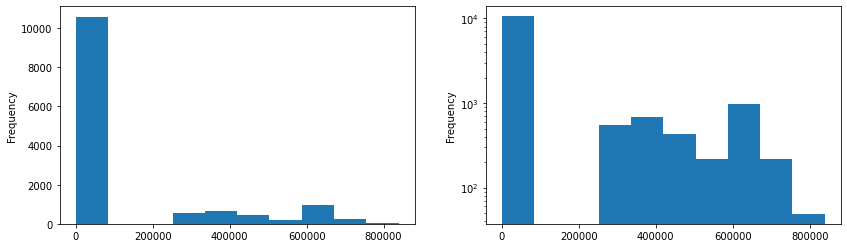

count    13718.000000
mean        47.960709
std         95.327642
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%        253.000000
99%        477.000000
max        477.000000
Name: fdp_IdGrupoCierre, dtype: float64

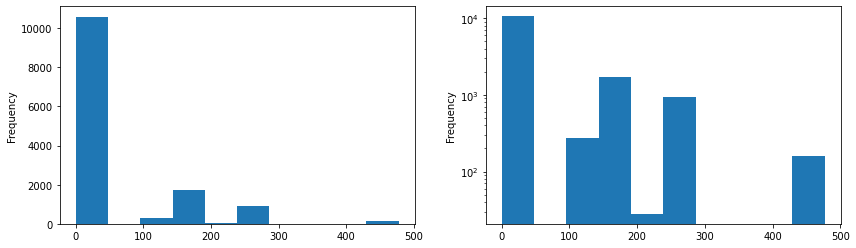

count    3126.000000
mean      216.476008
std       150.589253
min        48.000000
5%         48.000000
25%       166.000000
50%       166.000000
75%       254.000000
95%       706.000000
99%       831.000000
max       831.000000
Name: fdp_IdDetalleFlujoCierre, dtype: float64

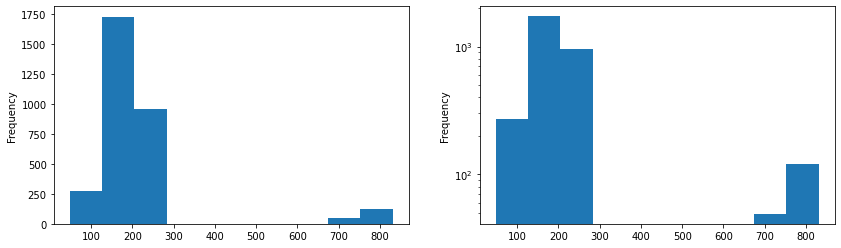

count    13718.000000
mean       686.108179
std       1235.705826
min         45.000000
5%          58.000000
25%        115.000000
50%        186.000000
75%        533.000000
95%       2556.000000
99%       7808.000000
max       8082.000000
Name: fdp_IdUsuarioCierre, dtype: float64

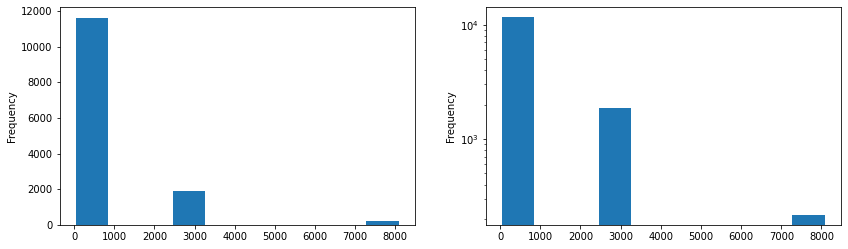

count    1.371800e+04
mean     7.099296e+08
std      1.488194e+09
min      1.388963e+07
5%       3.792905e+07
25%      5.283509e+07
50%      8.001099e+07
75%      1.019061e+09
95%      1.082763e+09
99%      9.128158e+09
max      9.128158e+09
Name: fdp_UsuarioCierre, dtype: float64

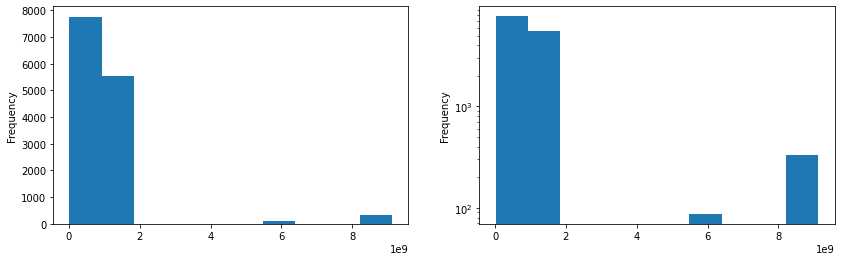

count    13718.000000
mean         2.497959
std          1.965946
min          1.000000
5%           1.000000
25%          1.000000
50%          1.000000
75%          4.000000
95%          6.000000
99%          6.000000
max          6.000000
Name: CodigoGrupoRolCierre, dtype: float64

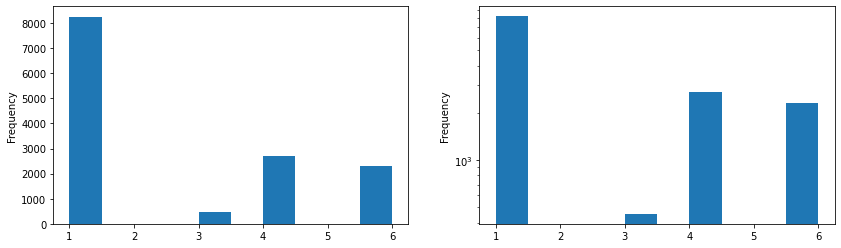

count     2996.000000
mean     11791.682243
std       2520.838555
min       4320.000000
5%        8100.000000
25%       8640.000000
50%      13500.000000
75%      13500.000000
95%      13500.000000
99%      13500.000000
max      13500.000000
Name: T_Objetivo_Total, dtype: float64

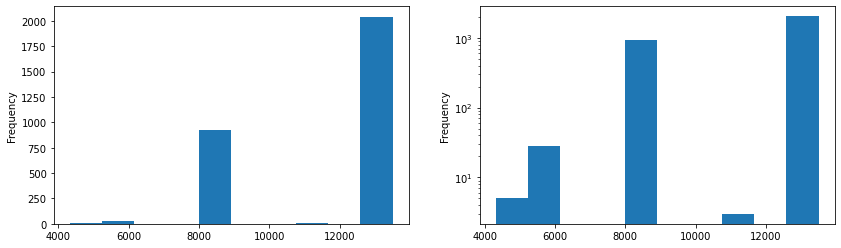

count     13748.000000
mean     113904.194501
std      219463.598737
min           0.000000
5%            4.000000
25%           4.000000
50%           4.000000
75%           4.000000
95%      644333.100000
99%      686104.480000
max      838908.000000
Name: fdp_IdHistoricoPqrGestionActual, dtype: float64

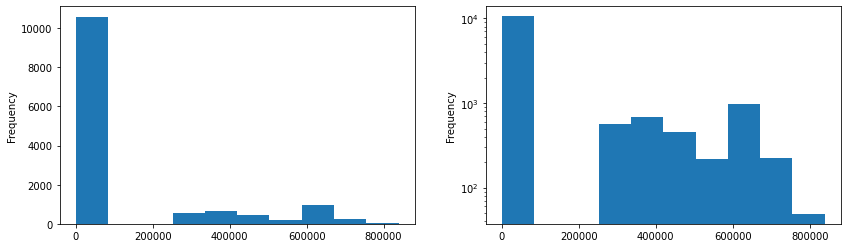

count    13748.000000
mean        48.288115
std         95.546604
min          0.000000
5%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
95%        253.000000
99%        477.000000
max        477.000000
Name: fdp_IdGrupoGestionActual, dtype: float64

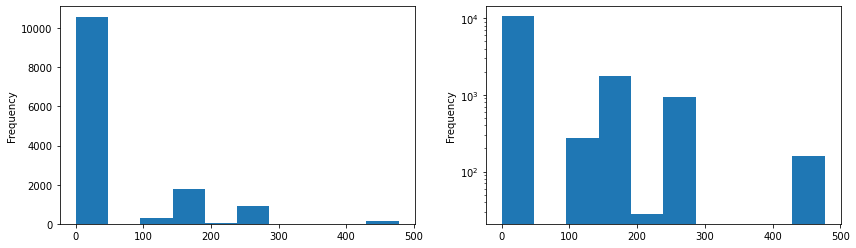

count    3156.000000
mean      216.380228
std       150.770273
min        48.000000
5%         48.000000
25%       166.000000
50%       166.000000
75%       254.000000
95%       706.000000
99%       831.000000
max       831.000000
Name: fdp_IdDetalleFlujoGestionActual, dtype: float64

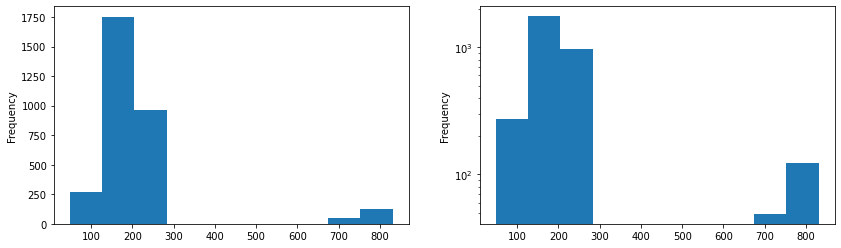

count    13748.00000
mean       685.90515
std       1234.33541
min         45.00000
5%          58.00000
25%        115.00000
50%        186.00000
75%        533.00000
95%       2556.00000
99%       7808.00000
max       8082.00000
Name: fdp_IdUsuarioGestionActual, dtype: float64

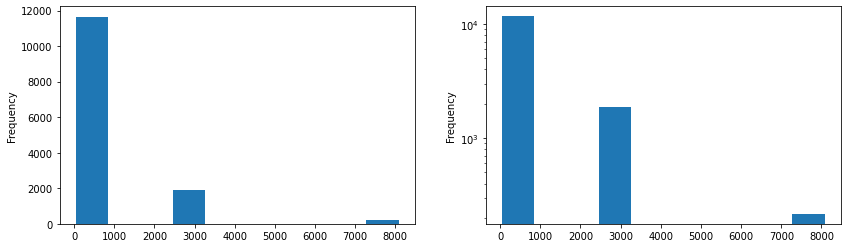

count    1.374800e+04
mean     7.080941e+08
std      1.486923e+09
min      1.388963e+07
5%       3.792905e+07
25%      5.283509e+07
50%      8.001099e+07
75%      1.019061e+09
95%      1.081409e+09
99%      9.128158e+09
max      9.128158e+09
Name: fdp_UsuarioGestionActual, dtype: float64

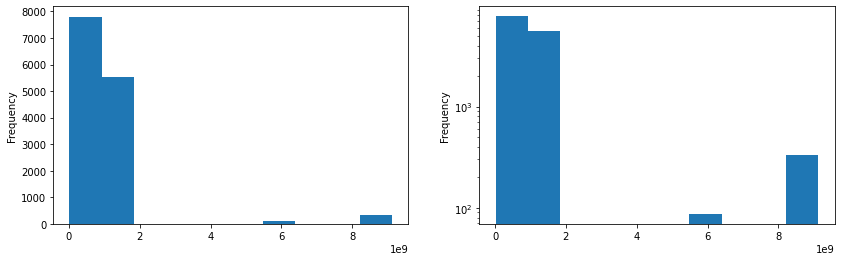

count    13748.000000
mean         2.501018
std          1.965050
min          1.000000
5%           1.000000
25%          1.000000
50%          1.000000
75%          4.000000
95%          6.000000
99%          6.000000
max          6.000000
Name: CodigoGrupoRolGestionActual, dtype: float64

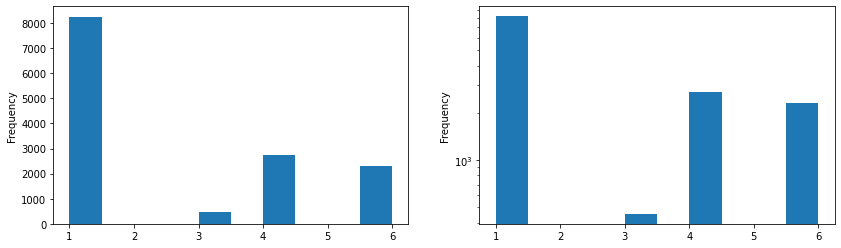

In [43]:


for i in numeros.columns:
  plt.figure(figsize=(14,4))
  display(numeros[i].describe(percentiles=[0.05,0.25,0.5,0.75,0.95,0.99]))
  plt.subplot(1,2,1)
  numeros[i].plot.hist()
  plt.subplot(1,2,2)
  numeros[i].plot.hist()
  plt.yscale('log')
  
  
  plt.show()


# Nuevos analisis

In [44]:
niveles =df_Registros_P[['fgs_Nivel2','fgs_Nivel3','fgs_Nivel4']].copy()
niveles.head(2)

,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4
0,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...
1,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...


In [45]:
niveles['union']  =  niveles['fgs_Nivel2']+'_*_'+niveles['fgs_Nivel3']+'_*_'+niveles['fgs_Nivel4']
niveles['union'].value_counts()

Beneficio Educativo - Regular_*_Legal / Reconocimiento Trabajadores (Incluye Bachiller ECP)_*_Legal / Reconocimiento Trabajadores (Incluye Bachiller ECP)                                             4195
Beneficio Educativo - Regular_*_Legal / Reconocimiento Pensionados (Incluye Sustitutos)_*_Legal / Reconocimiento Pensionados (Incluye Sustitutos)                                                     2415
Beneficio Educativo - Regular_*_Anticipo Trabajadores (Incluye BXC)_*_Anticipo Trabajadores (Incluye BXC)                                                                                             1807
Beneficio Educativo - Regular_*_Anticipo Pensionados (Incluye Sustitutos)_*_Anticipo Pensionados (Incluye Sustitutos)                                                                                 1586
Beneficio Educativo - Regular_*_Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)_*_Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)                     

In [46]:
niveles['union']  =niveles['fgs_Nivel3']+'_*_'+niveles['fgs_Nivel4']
niveles['union'].value_counts()

Legal / Reconocimiento Trabajadores (Incluye Bachiller ECP)_*_Legal / Reconocimiento Trabajadores (Incluye Bachiller ECP)                                  4195
Legal / Reconocimiento Pensionados (Incluye Sustitutos)_*_Legal / Reconocimiento Pensionados (Incluye Sustitutos)                                          2415
Anticipo Trabajadores (Incluye BXC)_*_Anticipo Trabajadores (Incluye BXC)                                                                                  1807
Anticipo Pensionados (Incluye Sustitutos)_*_Anticipo Pensionados (Incluye Sustitutos)                                                                      1586
Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)_*_Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)                    1225
Soporte Plataforma para Instituciones Educativas vía TIB_*_Soporte Plataforma para Instituciones Educativas vía TIB                                        1121
Solicitud de educación inclusiva_*_Solic

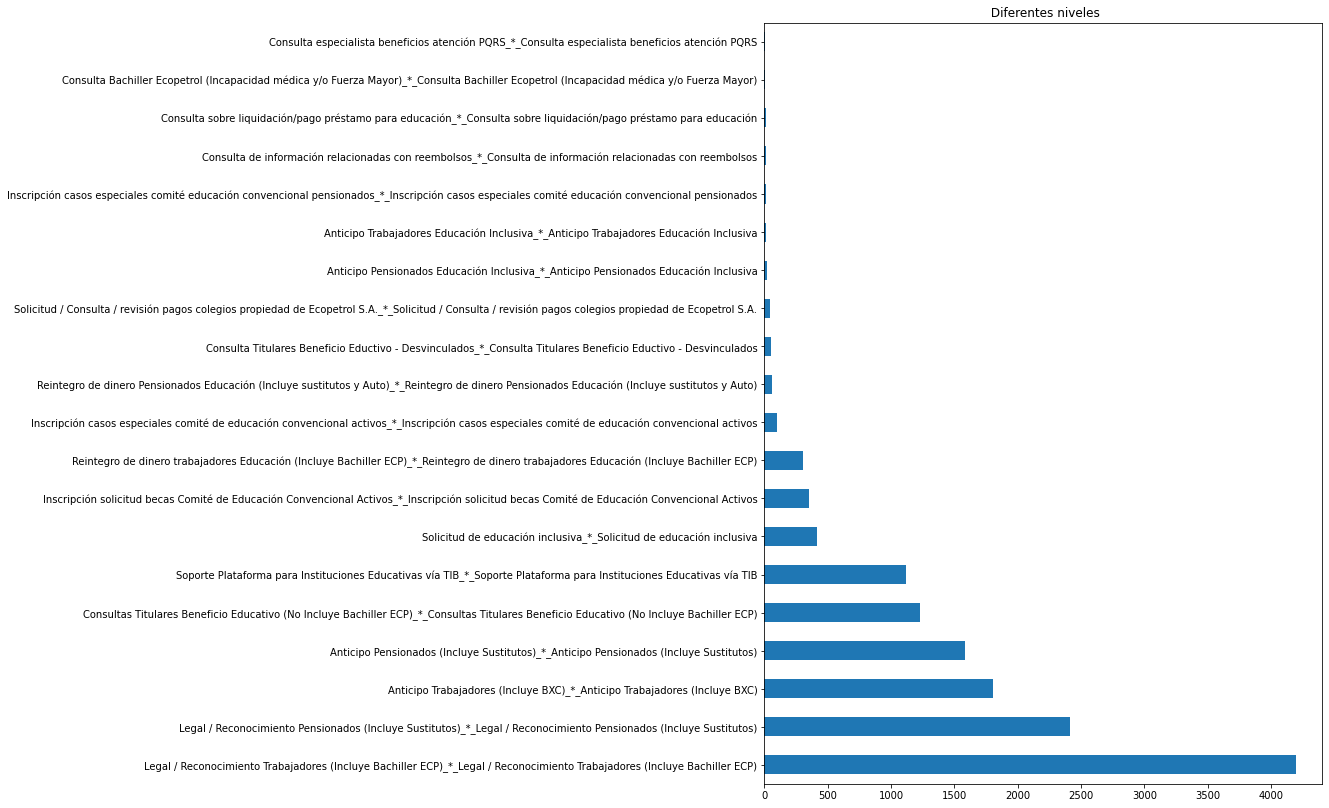

In [47]:

niveles['union'].value_counts().plot.barh(title = ' Diferentes niveles',figsize = (10,14))

In [48]:
niveles['fgs_Nivel3'].value_counts()

Legal / Reconocimiento Trabajadores (Incluye Bachiller ECP)                   4195
Legal / Reconocimiento Pensionados (Incluye Sustitutos)                       2415
Anticipo Trabajadores (Incluye BXC)                                           1807
Anticipo Pensionados (Incluye Sustitutos)                                     1586
Consultas Titulares Beneficio Educativo (No Incluye Bachiller ECP)            1225
Soporte Plataforma para Instituciones Educativas vía TIB                      1121
Solicitud de educación inclusiva                                               414
Inscripción solicitud becas Comité de Educación Convencional Activos           353
Reintegro de dinero trabajadores Educación (Incluye Bachiller ECP)             303
Inscripción casos especiales comité de educación convencional activos           99
Reintegro de dinero Pensionados Educación (Incluye sustitutos y Auto)           58
Consulta Titulares Beneficio Eductivo - Desvinculados                           52
Soli

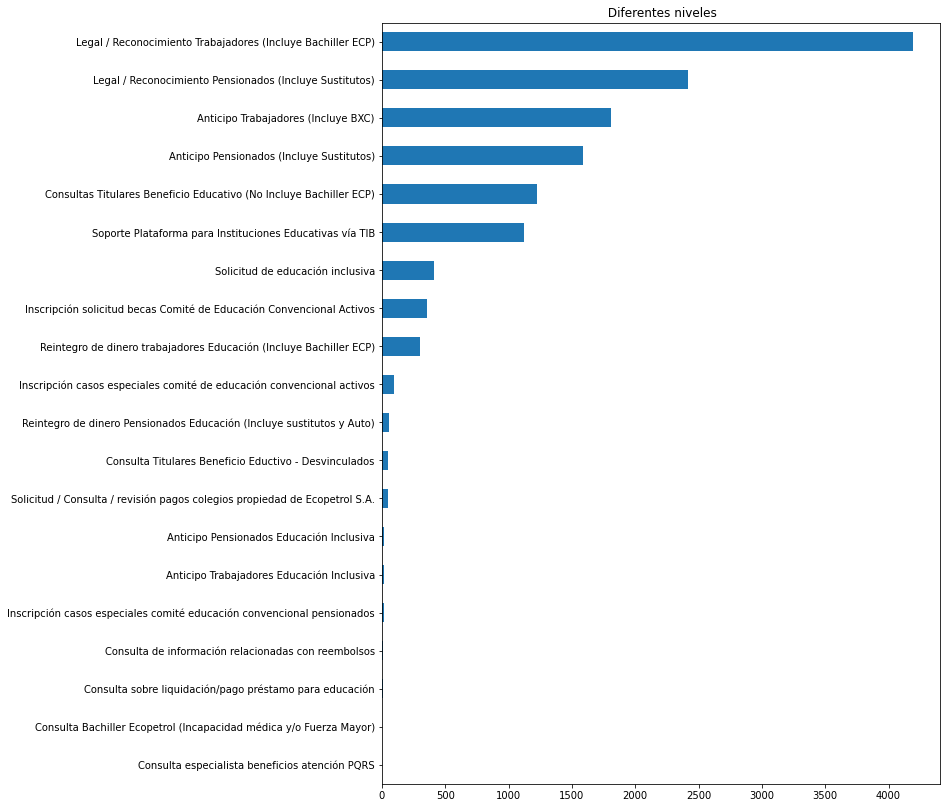

In [49]:
niveles['fgs_Nivel3'].value_counts().sort_values(ascending=True).plot.barh(title = ' Diferentes niveles',figsize = (10,14))

In [50]:
# correlacion


In [51]:
objetos.head(2)

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,fgs_Ip,fgs_FechaInicio,fgs_FechaFin,fgs_Tipificación,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Direccion_01,fgs_BarrioDireccion_01,fgs_LocalidadDireccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_Email_01,fgs_Email_02,fgs_Email_03,fmf_Canal,ude_Regional,ude_CiudadCliente,ude_DepartamentoCliente,ude_PaisCliente,ude_CodUni,ude_UnidadOrganizativa,ude_CECO,ude_CentroDeCostos,ude_EmailCliente,SistemaPago,ServicioPortafolio,fmf_FechaSolicitud,fdp_NombreEstado,fdp_NivelEstado,fdp_NombreUsuarioCreacion,fgs_ObservacionCreacion,fdp_FechaCreacion,GrupoRolCreacion,Cumple_Objetivo_SolicitadoRegistrado,Cumple_Objetivo_RegistradoEscalado,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fgs_ObservacionEscalamientoN2,fdp_FechaEscalamientoN2,fdp_FechaVencimientoEscalamientoN2,GrupoRolEscalamientoN2,Cumple_Objetivo_EnNivel2,fdp_NombreUsuarioDevolucion,fgs_ObservacionDevolucion,fdp_FechaDevolucion,fdp_FechaVencimientoDevolucion,GrupoRolDevolucion,fdp_MotivoDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fgs_ObservacionSolucion,fdp_FechaSolucion,fdp_FechaVencimientoSolucion,GrupoRolSolucion,fdp_NivelSolucion,Cumple_Objetivo_SolucionadoCerrado,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fgs_ObservacionCierre,fdp_FechaCierre,fdp_FechaVencimientoCierre,GrupoRolCierre,fdp_NivelCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,fdp_FechaGestionActual,fdp_FechaVencimientoGestionActual,GrupoRolGestionActual,fdp_MotivoGestionActual,fdp_NivelGestionActual,TipoAjuste,fdp_FechaVencimientoTotal
0,CC,SANCHEZ MORA JOAQUIN ERNESTO,172.27.40.50,2021-02-01 06:40:30.150,2021-02-01 06:47:23.443,Contacto,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,CL 170 53C 27,NaN,NaN,"BOGOTA, D.C.",BOGOTA,JOSAMO_57@HOTMAIL.COM,NaN,NaN,Email BackOffice,CENTRO ORIENTE,BOGOTA,BOGOTA,COLOMBIA,0,NaN,SO0388,GASTOS DE JUBILADOS,JOSAMO_57@HOTMAIL.COM,Puesto de Trabajo,Legal / Reconocimiento Pensionados (Incluye Su...,2021-01-28 20:53:00,Cerrado,Nivel1,AIDA ALEXANDRA RODRIGUEZ AMAYA,Se recibe documentación del señor Joaquin Erne...,2021-02-01 06:47:23.443,Asesor de Servicio Front Contact Center,No Cumple,Cumple,NaN,NaN,NaN,NaN,NaN,NaN,No Aplica,NaN,NaN,NaN,NaN,NaN,NaN,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,"""se informa que su caso no puede ser tramitado...",2021-02-01 06:47:23.443,2020-02-25 16:30:00.000,Asesor de Servicio Front Contact Center,Nivel1,Cumple,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,"""se informa que su caso no puede ser tramitado...",2021-02-01 06:47:23.443,2020-02-25 16:30:00.000,Asesor de Servicio Front Contact Center,Nivel1,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,"""se informa que su caso no puede ser tramitado...",2021-02-01 06:47:23.443,2020-02-25 16:30:00.000,Asesor de Servicio Front Contact Center,NaN,Nivel1,Fecha Superior a la fecha de creación o Fecha ...,2021-02-01 09:45:00.000
1,CC,SANTA GAVIRIA MERY ANGELA,192.168.73.74,2021-02-01 06:55:42.110,2021-02-01 07:01:31.857,Contacto,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,MCCA 21 CONJ PORTAL DE LAS AVENIDAS,NaN,NaN,SANTA MARTA,MAGDALENA,ANGY15_95@HOTMAIL.COM,NaN,NaN,Email BackOffice,NORTE,SANTA MARTA,MAGDALENA,COLOMBIA,0,NaN,SO0388,GASTOS DE JUBILADOS,ANGY15_95@HOTMAIL.COM,Transacciones,Legal / Reconocimiento Pensionados (Incluye Su...,2021-02-01 06:56:00,Cerrado,Nivel1,DIANA MILENA GUERRERO MELLIZO,Solicitó el ajuste de semestre y se encuentra ...,2021-02-01 07:01:31.857,Asesor de Servicio Contact Center,Cumple,Cumple,NaN,NaN,NaN,NaN,NaN,NaN,No Aplica,NaN,NaN,NaN,NaN,NaN,NaN,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Se realizó el ajuste de semestre y se encuentr...,2021-02-01 07:01:31.857,2020-02-25 16:30:00.000,Asesor de Servicio Cont

In [52]:
mapas_nofechas = objetos.columns.str.findall('Fecha').map(lambda x : len(x)==0)# eliminar fecha
objetos_nofechas = objetos[objetos.columns[mapas_nofechas]]

In [53]:
objetos_nofechas.head()

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,fgs_Ip,fgs_Tipificación,fgs_Nivel2,fgs_Nivel3,fgs_Nivel4,fgs_Direccion_01,fgs_BarrioDireccion_01,fgs_LocalidadDireccion_01,fgs_CiudadDireccion_01,fgs_DepartamentoDireccion_01,fgs_Email_01,fgs_Email_02,fgs_Email_03,fmf_Canal,ude_Regional,ude_CiudadCliente,ude_DepartamentoCliente,ude_PaisCliente,ude_CodUni,ude_UnidadOrganizativa,ude_CECO,ude_CentroDeCostos,ude_EmailCliente,SistemaPago,ServicioPortafolio,fdp_NombreEstado,fdp_NivelEstado,fdp_NombreUsuarioCreacion,fgs_ObservacionCreacion,GrupoRolCreacion,Cumple_Objetivo_SolicitadoRegistrado,Cumple_Objetivo_RegistradoEscalado,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fgs_ObservacionEscalamientoN2,GrupoRolEscalamientoN2,Cumple_Objetivo_EnNivel2,fdp_NombreUsuarioDevolucion,fgs_ObservacionDevolucion,GrupoRolDevolucion,fdp_MotivoDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fgs_ObservacionSolucion,GrupoRolSolucion,fdp_NivelSolucion,Cumple_Objetivo_SolucionadoCerrado,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fgs_ObservacionCierre,GrupoRolCierre,fdp_NivelCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fgs_ObservacionGestionActual,GrupoRolGestionActual,fdp_MotivoGestionActual,fdp_NivelGestionActual,TipoAjuste
0,CC,SANCHEZ MORA JOAQUIN ERNESTO,172.27.40.50,Contacto,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,CL 170 53C 27,NaN,NaN,"BOGOTA, D.C.",BOGOTA,JOSAMO_57@HOTMAIL.COM,NaN,NaN,Email BackOffice,CENTRO ORIENTE,BOGOTA,BOGOTA,COLOMBIA,0,NaN,SO0388,GASTOS DE JUBILADOS,JOSAMO_57@HOTMAIL.COM,Puesto de Trabajo,Legal / Reconocimiento Pensionados (Incluye Su...,Cerrado,Nivel1,AIDA ALEXANDRA RODRIGUEZ AMAYA,Se recibe documentación del señor Joaquin Erne...,Asesor de Servicio Front Contact Center,No Cumple,Cumple,NaN,NaN,NaN,NaN,No Aplica,NaN,NaN,NaN,NaN,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,"""se informa que su caso no puede ser tramitado...",Asesor de Servicio Front Contact Center,Nivel1,Cumple,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,"""se informa que su caso no puede ser tramitado...",Asesor de Servicio Front Contact Center,Nivel1,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,"""se informa que su caso no puede ser tramitado...",Asesor de Servicio Front Contact Center,NaN,Nivel1,Fecha Superior a la fecha de creación o Fecha ...
1,CC,SANTA GAVIRIA MERY ANGELA,192.168.73.74,Contacto,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,MCCA 21 CONJ PORTAL DE LAS AVENIDAS,NaN,NaN,SANTA MARTA,MAGDALENA,ANGY15_95@HOTMAIL.COM,NaN,NaN,Email BackOffice,NORTE,SANTA MARTA,MAGDALENA,COLOMBIA,0,NaN,SO0388,GASTOS DE JUBILADOS,ANGY15_95@HOTMAIL.COM,Transacciones,Legal / Reconocimiento Pensionados (Incluye Su...,Cerrado,Nivel1,DIANA MILENA GUERRERO MELLIZO,Solicitó el ajuste de semestre y se encuentra ...,Asesor de Servicio Contact Center,Cumple,Cumple,NaN,NaN,NaN,NaN,No Aplica,NaN,NaN,NaN,NaN,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Se realizó el ajuste de semestre y se encuentr...,Asesor de Servicio Contact Center,Nivel1,Cumple,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Se realizó el ajuste de semestre y se encuentr...,Asesor de Servicio Contact Center,Nivel1,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Se realizó el ajuste de semestre y se encuentr...,Asesor de Servicio Contact Center,NaN,Nivel1,Fecha Superior a la fecha de creación o Fecha ...
2,CC,CONTRERAS GAITAN JOSE DEL CARMEN,172.27.40.50,Contacto,Beneficio Educativo - Regular,Legal / Reconocimiento Pensionados (Incluye Su...,Legal / Reconocimiento Pensionados (Incluye Su...,CL 5 N 3 E 143,NaN,NaN,CUCUTA,N. DE SANTANDER,GLADISMARIA316@OUTLOOK.COM,NaN,NaN,Email BackOffice,CENTRO ORIENTE,SAN JOSE DE CUCUTA,N. DE SANTANDER,COLOMBIA,0,NaN,SO0388,GASTOS DE JUBILADOS,GLADISMARIA316@OUTLOOK.C

In [54]:
objetos_nofechas.columns

Index(['fgs_SiglasDocumentoContacto', 'fgs_NombreCompletoContacto', 'fgs_Ip',
       'fgs_Tipificación', 'fgs_Nivel2', 'fgs_Nivel3', 'fgs_Nivel4',
       'fgs_Direccion_01', 'fgs_BarrioDireccion_01',
       'fgs_LocalidadDireccion_01', 'fgs_CiudadDireccion_01',
       'fgs_DepartamentoDireccion_01', 'fgs_Email_01', 'fgs_Email_02',
       'fgs_Email_03', 'fmf_Canal', 'ude_Regional', 'ude_CiudadCliente',
       'ude_DepartamentoCliente', 'ude_PaisCliente', 'ude_CodUni',
       'ude_UnidadOrganizativa', 'ude_CECO', 'ude_CentroDeCostos',
       'ude_EmailCliente', 'SistemaPago', 'ServicioPortafolio',
       'fdp_NombreEstado', 'fdp_NivelEstado', 'fdp_NombreUsuarioCreacion',
       'fgs_ObservacionCreacion', 'GrupoRolCreacion',
       'Cumple_Objetivo_SolicitadoRegistrado',
       'Cumple_Objetivo_RegistradoEscalado', 'fdp_NombreGrupoEscalamientoN2',
       'fdp_NombreUsuarioEscalamientoN2', 'fgs_ObservacionEscalamientoN2',
       'GrupoRolEscalamientoN2', 'Cumple_Objetivo_EnNivel2',
      

In [55]:
importa =objetos[['fgs_Nivel3','fgs_ObservacionCreacion','fgs_ObservacionSolucion']]

In [56]:
%%time
importa['fgs_ObservacionCreacion'].str.split().str.len()

CPU times: user 52.8 ms, sys: 15.2 ms, total: 67.9 ms
Wall time: 70.2 ms


0         18
1         12
2         20
3         22
4         10
        ... 
13743     77
13744     72
13745    153
13746    128
13747     13
Name: fgs_ObservacionCreacion, Length: 13748, dtype: int64

In [57]:
%%time
importa['1'] = importa['fgs_ObservacionCreacion'].map(lambda x : len(x.split()))

CPU times: user 39.3 ms, sys: 968 µs, total: 40.3 ms
Wall time: 40.9 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [58]:
importa['fgs_ObservacionSolucion'].map(lambda x : type(x)).value_counts()

<class 'str'>      13719
<class 'float'>       29
Name: fgs_ObservacionSolucion, dtype: int64

In [59]:
mapa = importa['fgs_ObservacionSolucion'].map(lambda x : type(x))==float

In [60]:
importa[mapa]## no hay solucion por que puede que se le diera solucion directa al cliente. :( )

,fgs_Nivel3,fgs_ObservacionCreacion,fgs_ObservacionSolucion,1
163,Legal / Reconocimiento Pensionados (Incluye Su...,SD2718839 su caso se escalo con las siguientes...,NaN,131
2075,Legal / Reconocimiento Trabajadores (Incluye B...,Reconocimiento de ingles bachillerato x Jhon A...,NaN,8
4018,Anticipo Pensionados (Incluye Sustitutos),Su caso se escaló al área encargada para su tr...,NaN,54
6314,Reintegro de dinero trabajadores Educación (In...,GESTIÓN: Su caso se escaló al área encargada p...,NaN,79
6356,Reintegro de dinero trabajadores Educación (In...,GESTIÓN: Su caso se escaló al área encargada p...,NaN,68
6370,Reintegro de dinero trabajadores Educación (In...,Amablemente solicito de su acostumbrada gestió...,NaN,52
6402,Reintegro de dinero trabajadores Educación (In...,GESTIÓN: Su caso se escaló al área encargada p...,NaN,48
6438,Reintegro de dinero trabajadores Educación (In...,"Buen día, agradezco su amable gestión revisand...",NaN,108
6512,Reintegro de dinero trabajadores Educación (In...,gestión :su caso se escalo al área correspondi...,NaN,30
6515,Reintegro de dinero trabajadores Educación (In...,Su caso se escaló al área encargada para su tr...,NaN,82


In [61]:
importasina = importa.dropna().copy()

In [62]:
importasina['fgs_ObservacionCreacion_cantidad_palabras'] = importasina['fgs_ObservacionCreacion'].map(lambda x : len(x.split())).copy()

In [63]:
importasina['fgs_ObservacionSolucion_cantidad_palabras'] = importasina['fgs_ObservacionSolucion'].copy().map(lambda x : len(x.split()))

In [64]:
importasina[['fgs_ObservacionCreacion_cantidad_palabras','fgs_ObservacionSolucion_cantidad_palabras']].corr()

,fgs_ObservacionCreacion_cantidad_palabras,fgs_ObservacionSolucion_cantidad_palabras
fgs_ObservacionCreacion_cantidad_palabras,1.0000,0.0681
fgs_ObservacionSolucion_cantidad_palabras,0.0681,1.0000


In [65]:
importasina[['fgs_ObservacionCreacion_cantidad_palabras','fgs_ObservacionSolucion_cantidad_palabras']].corr(method='spearman')

,fgs_ObservacionCreacion_cantidad_palabras,fgs_ObservacionSolucion_cantidad_palabras
fgs_ObservacionCreacion_cantidad_palabras,1.000000,0.203493
fgs_ObservacionSolucion_cantidad_palabras,0.203493,1.000000


In [66]:
# importasina['fgs_ObservacionCreacion_cantidad_palabras'].map(lambda x: x.replace('<br>',' '))

In [67]:
importasina['fgs_ObservacionCreacion'].map(lambda x: x.replace('<br>',' '))

0        Se recibe documentación del señor Joaquin Erne...
1        Solicitó el ajuste de semestre y se encuentra ...
2        SE RECIBE SOLICITUD DE LEGALIZACION 5 SEMESTRE...
3        SOLICITUD DEL USUARIO: Ayer envié este mismo d...
4        SE RECIBE SOLICITUD DE LEGALIZACION DE LUISA F...
                               ...                        
13743    GESTIÓN: Su caso se escaló al área encargada p...
13744    GESTIÓN: Su caso se escaló al área encargada p...
13745    GESTIÓN: Su caso se escaló al área encargada p...
13746    Gestión: Su caso fue escalado con las siguient...
13747    Funcionario solicita creación de un caso por l...
Name: fgs_ObservacionCreacion, Length: 13719, dtype: object

In [68]:
importasina['fgs_ObservacionCreacion'][importasina['fgs_ObservacionCreacion'].str.findall('<br>').map(lambda x: len(x)>0)]

5       Se recibe documentación del señor Carlos Alber...
37      su  caso fue escalado al area encargada con la...
59      Buenas Tardes <br><br><br>Solicitamos de su am...
77      Buenos dias señores de oficina virtual de pers...
90      solicitud OVP/ gestión : "La presente es para ...
                              ...                        
6240    GESTIÓN: Su caso se escaló al área encargada p...
6241    GESTIÓN: Su caso se escaló al área encargada p...
6242    GESTIÓN: Su caso se escaló al área encargada p...
6243    GESTIÓN: Su caso se escaló al área encargada p...
6244    GESTIÓN: Su caso se escaló al área encargada p...
Name: fgs_ObservacionCreacion, Length: 1042, dtype: object

In [69]:
importasina['fgs_ObservacionCreacion'].map(lambda x: x.replace('<br>',' '))[importasina['fgs_ObservacionCreacion'].str.findall('<br>').map(lambda x: len(x)>0)]

5       Se recibe documentación del señor Carlos Alber...
37      su  caso fue escalado al area encargada con la...
59      Buenas Tardes    Solicitamos de su amable cola...
77      Buenos dias señores de oficina virtual de pers...
90      solicitud OVP/ gestión : "La presente es para ...
                              ...                        
6240    GESTIÓN: Su caso se escaló al área encargada p...
6241    GESTIÓN: Su caso se escaló al área encargada p...
6242    GESTIÓN: Su caso se escaló al área encargada p...
6243    GESTIÓN: Su caso se escaló al área encargada p...
6244    GESTIÓN: Su caso se escaló al área encargada p...
Name: fgs_ObservacionCreacion, Length: 1042, dtype: object

In [70]:
importasina['fgs_ObservacionCreacion'].map(lambda x: x.replace('<br>',' ')).value_counts()

solicita información de plan educacional.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        263
solicita información.                                                                                                                                                                                                                                                                                                                              

In [71]:
importasina['fgs_ObservacionSolucion'].map(lambda x: x.replace('<br>',' ')).value_counts()

se procede a dar cierre según correo adjunto.                                                                                                                                                                                                                                                                                                                                            259
se adjunta respuesta enviada                                                                                                                                                                                                                                                                                                                                                             206
Buen día, en atención a su solicitud, nos permitimos informarle que su caso se encuentra radicado para el próximo Comité de Educación,  el cual se llevará a cabo durante el segundo semestre de 2020. Una vez analizado, se procederá a envia

In [72]:
nombres_columnas = pd.Series(df_Registros_P.columns)
columnas_con_nombre = nombres_columnas [nombres_columnas.map(lambda x :x.lower()).str.findall('nombre').map(lambda x : len(x)>0)]


In [73]:
columnas_con_nombre.to_list()

['fgs_NombreCompletoContacto',
 'fdp_NombreEstado',
 'fdp_NombreUsuarioCreacion',
 'fdp_NombreGrupoEscalamientoN2',
 'fdp_NombreUsuarioEscalamientoN2',
 'fdp_NombreUsuarioDevolucion',
 'fdp_NombreGrupoSolucion',
 'fdp_NombreUsuarioSolucion',
 'fdp_NombreGrupoCierre',
 'fdp_NombreUsuarioCierre',
 'fdp_NombreGrupoGestionActual',
 'fdp_NombreUsuarioGestionActual']

In [74]:
nombres_columnas = pd.Series(df_Registros_P.columns)
columnas_con_nombre = nombres_columnas [nombres_columnas.map(lambda x :x.lower()).str.findall('fecha').map(lambda x : len(x)>0)]


In [75]:
columnas_con_nombre.to_list()

['fgs_FechaInicio',
 'fgs_FechaFin',
 'fmf_FechaSolicitud',
 'fdp_FechaCreacion',
 'fdp_FechaEscalamientoN2',
 'fdp_FechaVencimientoEscalamientoN2',
 'fdp_FechaDevolucion',
 'fdp_FechaVencimientoDevolucion',
 'fdp_FechaSolucion',
 'fdp_FechaVencimientoSolucion',
 'fdp_FechaCierre',
 'fdp_FechaVencimientoCierre',
 'fdp_FechaGestionActual',
 'fdp_FechaVencimientoGestionActual',
 'fdp_FechaVencimientoTotal']

In [76]:
info_usuarios = df_Registros_P[['fgs_SiglasDocumentoContacto', 'fgs_NumeroDocumContacto','fgs_FechaInicio',
                'fgs_NombreCompletoContacto',
 'fdp_NombreEstado',
 'fdp_NombreUsuarioCreacion',
 'fdp_NombreGrupoEscalamientoN2',
 'fdp_NombreUsuarioEscalamientoN2',
 'fdp_NombreUsuarioDevolucion',
 'fdp_NombreGrupoSolucion',
 'fdp_NombreUsuarioSolucion',
 'fdp_NombreGrupoCierre',
 'fdp_NombreUsuarioCierre',
 'fdp_NombreGrupoGestionActual',
 'fdp_NombreUsuarioGestionActual',
 'fdp_FechaCreacion']].copy()

In [77]:
info_usuarios.head(2)

,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,fgs_FechaInicio,fgs_NombreCompletoContacto,fdp_NombreEstado,fdp_NombreUsuarioCreacion,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fdp_NombreUsuarioDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fdp_FechaCreacion
0,CC,19322865,2021-02-01 06:40:30.150,SANCHEZ MORA JOAQUIN ERNESTO,Cerrado,AIDA ALEXANDRA RODRIGUEZ AMAYA,NaN,NaN,NaN,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,2021-02-01 06:47:23.443
1,CC,1053843731,2021-02-01 06:55:42.110,SANTA GAVIRIA MERY ANGELA,Cerrado,DIANA MILENA GUERRERO MELLIZO,NaN,NaN,NaN,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,2021-02-01 07:01:31.857


In [144]:
info_clientes = pd.read_csv('Info_clientes.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,6,24,27,29,34,35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [79]:
info_clientes.head(2)

,ID,N_DOCUMENTO,TIPO_DOCUMENTO,IdTipoDoc,NOMBRE_COMPLETO,DIRECCION,DIRECCION_2,CIUDAD,IdCiudad,CIUDAD_SUCURSAL,DEPARTAMENTO,IdDepto,PAIS,IdPais,FECHA_NACIMIENTO,SEXO,CORREO_ELECT,TELEFONO_1,TELEFONO_2,TEL_CELULAR,TEL_FIJO,ECIVIL,REGIONAL_GSC,CDFPR,CECOSTE,CECO,CE_COSTE,CODIGO_POSICION,DESCRIPCIÓN_SUCURSAL,SUCURSAL,POSICION,PS,RAZON_SOCIAL,REGISTRO,RG,UN_ORG
0,1,1006775793,CC,1,QUEVEDO BETANCOURT BRAYAN ALEJANDRO,CL 6 14 09 BRR EL CENTRO,NaN,CASTILLA LA NUEVA,689.0,NaN,META,16.0,COLOMBIA,1.0,03/01/2000,MASCULINO,BRAYAN.QUEVEDO@ECOPETROL.COM.CO,3024614518,3024614518,NaN,NaN,SOLTERO,LLANOS ORIENTALES,50150,NaN,PR6592,ESTACION DE TRATAMIENTO CASTILLA 2,32020197,ACACIAS,20,OPERADORA DE PLANTA,COL,NaN,282708,50,10000196
1,2,1006776140,CC,1,BERMUDEZ SANTA DANIEL SANTIAGO,CL. 27#43A-78 MZ C CS 39 CONJUNTO RINCÓN DEL B...,NaN,"BOGOTA, D.C.",149.0,BOGOTA,BOGOTA,3.0,COLOMBIA,1.0,8-10-2000,MASCULINO,NaN,986688094,NaN,NaN,NaN,NaN,CENTRO ORIENTE,50001,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,104035,NaN,NaN


In [80]:
info_clientes.columns

Index(['ID', 'N_DOCUMENTO', 'TIPO_DOCUMENTO', 'IdTipoDoc', 'NOMBRE_COMPLETO',
       'DIRECCION', 'DIRECCION_2', 'CIUDAD', 'IdCiudad', 'CIUDAD_SUCURSAL',
       'DEPARTAMENTO', 'IdDepto', 'PAIS', 'IdPais', 'FECHA_NACIMIENTO', 'SEXO',
       'CORREO_ELECT', 'TELEFONO_1', 'TELEFONO_2', 'TEL_CELULAR', 'TEL_FIJO',
       'ECIVIL', 'REGIONAL_GSC', 'CDFPR', 'CECOSTE', 'CECO', 'CE_COSTE',
       'CODIGO_POSICION', 'DESCRIPCIÓN_SUCURSAL', 'SUCURSAL', 'POSICION', 'PS',
       'RAZON_SOCIAL', 'REGISTRO', 'RG', 'UN_ORG'],
      dtype='object')

In [81]:
# info_usuarios['fgs_NumeroDocumContacto'] = info_usuarios['fgs_NumeroDocumContacto'].astype('O')

In [82]:
print(info_usuarios.shape)
x = info_usuarios.merge(right=info_clientes,how='left', left_on='fgs_NumeroDocumContacto',right_on='N_DOCUMENTO')
print(info_usuarios.shape, x.shape)

(13748, 16)
(13748, 16) (13748, 52)


In [83]:
x[x['fgs_NumeroDocumContacto'].duplicated(keep=False)].sort_values(by = 'fgs_NumeroDocumContacto')

,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,fgs_FechaInicio,fgs_NombreCompletoContacto,fdp_NombreEstado,fdp_NombreUsuarioCreacion,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fdp_NombreUsuarioDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fdp_FechaCreacion,ID,N_DOCUMENTO,TIPO_DOCUMENTO,IdTipoDoc,NOMBRE_COMPLETO,DIRECCION,DIRECCION_2,CIUDAD,IdCiudad,CIUDAD_SUCURSAL,DEPARTAMENTO,IdDepto,PAIS,IdPais,FECHA_NACIMIENTO,SEXO,CORREO_ELECT,TELEFONO_1,TELEFONO_2,TEL_CELULAR,TEL_FIJO,ECIVIL,REGIONAL_GSC,CDFPR,CECOSTE,CECO,CE_COSTE,CODIGO_POSICION,DESCRIPCIÓN_SUCURSAL,SUCURSAL,POSICION,PS,RAZON_SOCIAL,REGISTRO,RG,UN_ORG
1041,CC,1000,2021-02-23 10:42:22.000,ANÓNIMO,Cerrado,ANGELICA VALENTINA CAMARGO MURCIA,NaN,NaN,NaN,Grupo Primer Nivel Personal,ANGELICA VALENTINA CAMARGO MURCIA,Grupo Primer Nivel Personal,ANGELICA VALENTINA CAMARGO MURCIA,Grupo Primer Nivel Personal,ANGELICA VALENTINA CAMARGO MURCIA,2021-02-23 11:02:10.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5279,CC,1000,2021-02-13 08:12:19.000,CALDERON DE LA HOZ PAOLA MARIA,Cerrado,ANGIE CAROLINA ANGULO DELGADO,NaN,NaN,NaN,Grupo Primer Nivel Personal,ANGIE CAROLINA ANGULO DELGADO,Grupo Primer Nivel Personal,ANGIE CAROLINA ANGULO DELGADO,Grupo Primer Nivel Personal,ANGIE CAROLINA ANGULO DELGADO,2021-02-13 08:17:31.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5276,CC,1000,2021-02-12 16:38:57.000,CALDERON DE LA HOZ PAOLA MARIA,Cerrado,INGRID GERALDIN OBANDO PEÑA,NaN,NaN,NaN,Grupo Primer Nivel Personal,INGRID GERALDIN OBANDO PEÑA,Grupo Primer Nivel Personal,INGRID GERALDIN OBANDO PEÑA,Grupo Primer Nivel Personal,INGRID GERALDIN OBANDO PEÑA,2021-02-12 16:43:39.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12509,CC,1000,2020-11-27 08:03:29.653,CLIENTE ANONIMO ECOPETROL,Cerrado,LEYDI YASMIN CASTRO MORANTES,NaN,NaN,NaN,Grupo Primer Nivel Personal,LEYDI YASMIN CASTRO MORANTES,Grupo Primer Nivel Personal,LEYDI YASMIN CASTRO MORANTES,Grupo Primer Nivel Personal,LEYDI YASMIN CASTRO MORANTES,2020-11-27 08:13:20.413,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3690,CC,1000,2021-02-08 07:05:46.000,CALDERON DE LA HOZ PAOLA MARIA,Cerrado,INGRID GERALDIN OBANDO PEÑA,Profesional Educación Inclusiva,MARTHA IRENE QUINTERO PABON,NaN,Profesional Educación Inclusiva,MARTHA IRENE QUINTERO PABON,Profesional Educación Inclusiva,MARTHA IRENE QUINTERO PABON,Profesional Educación Inclusiva,MARTHA IRENE QUINTERO PABON,2021-02-08 07:08:13.433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11911,CC,1234990667,2020-11-18 15:30:25.000,ALVAREZ BETANCUR SANTIAGO,Cerrado,LEYDA ROCIO MORENO YARA,NaN,NaN,NaN,Grupo Primer Nivel Personal,LEYDA ROCIO MORENO YARA,Grupo Primer Nivel Personal,LEYDA ROCIO MORENO YARA,Grupo Primer Nivel Personal,LEYDA ROCIO MORENO YARA,2020-11-18 15:39:45.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6485,CC,1234990667,2020-11-19 07:09:19.000,ALVAREZ BETANCUR SANTIAGO,Cerrado,DIANA MILENA GUERRERO MELLIZO,Equipo Plan Educacional,NANCY CAICEDO SALINAS,NaN,Equipo Plan Educacional,NANCY CAICEDO SALINAS,Equipo Plan Educacional,NANCY CAICEDO SALINAS,Equipo

In [84]:
info_usuarios['fgs_NumeroDocumContacto'].astype('O')

0          19322865
1        1053843731
2          17043647
3          19105812
4          51659165
            ...    
13743       8288700
13744      79000080
13745      12119794
13746      79238499
13747      12119794
Name: fgs_NumeroDocumContacto, Length: 13748, dtype: object

In [85]:
info_clientes['N_DOCUMENTO'].map(lambda x : type(x))#=='str')

0         <class 'str'>
1         <class 'str'>
2         <class 'str'>
3         <class 'str'>
4         <class 'str'>
              ...      
380251    <class 'int'>
380252    <class 'int'>
380253    <class 'int'>
380254    <class 'int'>
380255    <class 'int'>
Name: N_DOCUMENTO, Length: 380256, dtype: object

In [86]:
# info_clientes['N_DOCUMENTO'].astype('int')

In [87]:
info_clientes[info_clientes['N_DOCUMENTO']== 'EUSA760823R64' ]

,ID,N_DOCUMENTO,TIPO_DOCUMENTO,IdTipoDoc,NOMBRE_COMPLETO,DIRECCION,DIRECCION_2,CIUDAD,IdCiudad,CIUDAD_SUCURSAL,DEPARTAMENTO,IdDepto,PAIS,IdPais,FECHA_NACIMIENTO,SEXO,CORREO_ELECT,TELEFONO_1,TELEFONO_2,TEL_CELULAR,TEL_FIJO,ECIVIL,REGIONAL_GSC,CDFPR,CECOSTE,CECO,CE_COSTE,CODIGO_POSICION,DESCRIPCIÓN_SUCURSAL,SUCURSAL,POSICION,PS,RAZON_SOCIAL,REGISTRO,RG,UN_ORG
1716,1717,EUSA760823R64,CC,1,ESQUIVEL SERRATO MARIA DE LOS ÁNGELES,NaN,NaN,"BOGOTA, D.C.",149.0,NaN,BOGOTA,3.0,COLOMBIA,1.0,NaN,NaN,MARIA.ESQUIVEL@ECOPETROL.COM.CO,NaN,NaN,NaN,NaN,NaN,CENTRO ORIENTE,NaN,NaN,VD4020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
def nonum(x):
 try:
   int(x)
   sal = False
 except:
    sal = True
 return sal 
mapa = info_clientes['N_DOCUMENTO'].map(lambda x: nonum(x))



In [89]:
info_clientes[mapa]# numero de identidad irreconocible

,ID,N_DOCUMENTO,TIPO_DOCUMENTO,IdTipoDoc,NOMBRE_COMPLETO,DIRECCION,DIRECCION_2,CIUDAD,IdCiudad,CIUDAD_SUCURSAL,DEPARTAMENTO,IdDepto,PAIS,IdPais,FECHA_NACIMIENTO,SEXO,CORREO_ELECT,TELEFONO_1,TELEFONO_2,TEL_CELULAR,TEL_FIJO,ECIVIL,REGIONAL_GSC,CDFPR,CECOSTE,CECO,CE_COSTE,CODIGO_POSICION,DESCRIPCIÓN_SUCURSAL,SUCURSAL,POSICION,PS,RAZON_SOCIAL,REGISTRO,RG,UN_ORG
1716,1717,EUSA760823R64,CC,1,ESQUIVEL SERRATO MARIA DE LOS ÁNGELES,NaN,NaN,"BOGOTA, D.C.",149.0,NaN,BOGOTA,3.0,COLOMBIA,1.0,NaN,NaN,MARIA.ESQUIVEL@ECOPETROL.COM.CO,NaN,NaN,NaN,NaN,NaN,CENTRO ORIENTE,NaN,NaN,VD4020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1774,1775,CC101022,CC,1,GARCIA PEREZ JUAN CAMILO,NaN,NaN,"BOGOTA, D.C.",149.0,NaN,BOGOTA,3.0,COLOMBIA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CENTRO ORIENTE,NaN,NaN,41220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1775,1776,CC101903,CC,1,VALENCIA VARGAS LUIS FELIPE,NaN,NaN,"BOGOTA, D.C.",149.0,NaN,BOGOTA,3.0,COLOMBIA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CENTRO ORIENTE,NaN,NaN,41220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1776,1777,C8012516,CC,1,QUINTERO MAURICIO,NaN,NaN,"BOGOTA, D.C.",149.0,NaN,BOGOTA,3.0,COLOMBIA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CENTRO ORIENTE,NaN,NaN,41220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1777,1778,CC113688,CC,1,PÉREZ JULIÁN,NaN,NaN,"BOGOTA, D.C.",149.0,NaN,BOGOTA,3.0,COLOMBIA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CENTRO ORIENTE,NaN,NaN,41220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370839,370840,51095593N,CC,1,MILLÁN MORENO JOSE FRANCISCO,NaN,NaN,"BOGOTA, D.C.",149.0,NaN,BOGOTA,3.0,COLOMBIA,1.0,NaN,NaN,JOSE.MILLAN@ECOPETROL.COM.CO,NaN,NaN,NaN,NaN,NaN,CENTRO ORIENTE,NaN,NaN,VD5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
372998,372999,27046274K,CC,1,HERDEZ BARRIOS ROSANGELA,NaN,NaN,"BOGOTA, D.C.",149.0,NaN,BOGOTA,3.0,COLOMBIA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CENTRO ORIENTE,NaN,NaN,VD2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374431,374432,794E11,CC,1,CHOUGULE ROHAN,NaN,NaN,"BOGOTA, D.C.",149.0,NaN,BOGOTA,3.0,COLOMBIA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CENTRO ORIENTE,NaN,NaN,VD2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374432,374433,763E11,CC,1,HAROON FABIYAN,NaN,NaN,"BOGOTA, D.C.",149.0,NaN,BOGOTA,3.0,COLOMBIA,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CENTRO ORIENTE,NaN,NaN,VD2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
def isnum(x):
 try:
   int(x)
   sal = True
 except:
    sal = False
 return sal 
mapa = info_clientes['N_DOCUMENTO'].map(lambda x: isnum(x))


In [91]:
print(info_clientes.shape,info_clientes[mapa].shape,info_clientes[mapa].shape[0]/info_clientes.shape[0]*100 )# porcentaj no numericos

(380256, 36) (379548, 36) 99.81380964402928


In [92]:
info_clientes = info_clientes[mapa]

In [93]:
info_clientes['N_DOCUMENTO'] = info_clientes['N_DOCUMENTO'].astype('int')

In [94]:
print(info_usuarios.shape)
info_usuarios.merge(right=info_clientes,how='left', left_on='fgs_NumeroDocumContacto',right_on='N_DOCUMENTO')
print(info_usuarios.shape)

(13748, 16)
(13748, 16)


In [95]:
info_usuarios.head()

,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,fgs_FechaInicio,fgs_NombreCompletoContacto,fdp_NombreEstado,fdp_NombreUsuarioCreacion,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fdp_NombreUsuarioDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fdp_FechaCreacion
0,CC,19322865,2021-02-01 06:40:30.150,SANCHEZ MORA JOAQUIN ERNESTO,Cerrado,AIDA ALEXANDRA RODRIGUEZ AMAYA,NaN,NaN,NaN,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,2021-02-01 06:47:23.443
1,CC,1053843731,2021-02-01 06:55:42.110,SANTA GAVIRIA MERY ANGELA,Cerrado,DIANA MILENA GUERRERO MELLIZO,NaN,NaN,NaN,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,2021-02-01 07:01:31.857
2,CC,17043647,2021-02-01 07:03:59.197,CONTRERAS GAITAN JOSE DEL CARMEN,Cerrado,REINALDO HUDGSON GUERRERO,NaN,NaN,NaN,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,2021-02-01 07:09:37.667
3,CC,19105812,2021-02-01 07:04:56.607,MOLANO PINZON HUGO,Cerrado,ELIANA ELIZABETH ESQUIVEL,NaN,NaN,NaN,Grupo Primer Nivel Personal,ELIANA ELIZABETH ESQUIVEL,Grupo Primer Nivel Personal,ELIANA ELIZABETH ESQUIVEL,Grupo Primer Nivel Personal,ELIANA ELIZABETH ESQUIVEL,2021-02-01 07:19:12.327
4,CC,51659165,2021-02-01 07:11:56.000,AMAYA CAMPOS MARIA CRISTINA,Cerrado,REINALDO HUDGSON GUERRERO,NaN,NaN,NaN,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,2021-02-01 07:23:02.490


In [96]:
print(info_usuarios.shape)
info_copilada = info_usuarios.merge(right=info_clientes,how='left', left_on='fgs_NumeroDocumContacto',right_on='N_DOCUMENTO')
print(info_usuarios.shape, info_copilada.shape)

(13748, 16)
(13748, 16) (13748, 52)


In [97]:
info_copilada.head()

,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,fgs_FechaInicio,fgs_NombreCompletoContacto,fdp_NombreEstado,fdp_NombreUsuarioCreacion,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fdp_NombreUsuarioDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fdp_FechaCreacion,ID,N_DOCUMENTO,TIPO_DOCUMENTO,IdTipoDoc,NOMBRE_COMPLETO,DIRECCION,DIRECCION_2,CIUDAD,IdCiudad,CIUDAD_SUCURSAL,DEPARTAMENTO,IdDepto,PAIS,IdPais,FECHA_NACIMIENTO,SEXO,CORREO_ELECT,TELEFONO_1,TELEFONO_2,TEL_CELULAR,TEL_FIJO,ECIVIL,REGIONAL_GSC,CDFPR,CECOSTE,CECO,CE_COSTE,CODIGO_POSICION,DESCRIPCIÓN_SUCURSAL,SUCURSAL,POSICION,PS,RAZON_SOCIAL,REGISTRO,RG,UN_ORG
0,CC,19322865,2021-02-01 06:40:30.150,SANCHEZ MORA JOAQUIN ERNESTO,Cerrado,AIDA ALEXANDRA RODRIGUEZ AMAYA,NaN,NaN,NaN,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,2021-02-01 06:47:23.443,63702.0,1.932286e+07,CC,1.0,SANCHEZ MORA JOAQUIN ERNESTO,CL 13053D27AP 701 TO 1 BRR PRADO VERANIEGO,NaN,"BOGOTA, D.C.",149.0,BOGOTA,BOGOTA,3.0,COLOMBIA,1.0,05/08/1957,MASCULINO,JOSAMO_57@HOTMAIL.COM,12572213,3114168571,NaN,NaN,CASADO,CENTRO ORIENTE,11001,NaN,SO0388,GASTOS DE JUBILADOS,1e+08,NaN,1,PENSIONADOS,COL,NaN,96438,11,1e+08
1,CC,1053843731,2021-02-01 06:55:42.110,SANTA GAVIRIA MERY ANGELA,Cerrado,DIANA MILENA GUERRERO MELLIZO,NaN,NaN,NaN,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,2021-02-01 07:01:31.857,374452.0,1.053844e+09,CC,1.0,SANTA GAVIRIA MERY ANGELA,MCCA 21 CONJ PORTAL DE LAS AVENIDAS,NaN,SANTA MARTA,655.0,SANTA MARTA,MAGDALENA,15.0,COLOMBIA,1.0,23/07/1995,FEMENINO,ANGY15_95@HOTMAIL.COM,3124964423,3234653523,NaN,NaN,SOLTERO,NORTE,47001,NaN,SO0388,GASTOS DE JUBILADOS,1e+08,NaN,57,PENSIONADOS,COL,NaN,15370,47,1e+08
2,CC,17043647,2021-02-01 07:03:59.197,CONTRERAS GAITAN JOSE DEL CARMEN,Cerrado,REINALDO HUDGSON GUERRERO,NaN,NaN,NaN,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,2021-02-01 07:09:37.667,136766.0,1.704365e+07,CC,1.0,CONTRERAS GAITAN JOSE DEL CARMEN,CL 5 N 3 E 143,NaN,CUCUTA,778.0,SAN JOSE DE CUCUTA,N. DE SANTANDER,18.0,COLOMBIA,1.0,17/03/1941,MASCULINO,GLADISMARIA316@OUTLOOK.COM,75924310,3162243130,NaN,NaN,SEPARADO,CENTRO ORIENTE,54001,NaN,SO0388,GASTOS DE JUBILADOS,1e+08,NaN,18,PENSIONADOS,COL,NaN,60681,54,1e+08
3,CC,19105812,2021-02-01 07:04:56.607,MOLANO PINZON HUGO,Cerrado,ELIANA ELIZABETH ESQUIVEL,NaN,NaN,NaN,Grupo Primer Nivel Personal,ELIANA ELIZABETH ESQUIVEL,Grupo Primer Nivel Personal,ELIANA ELIZABETH ESQUIVEL,Grupo Primer Nivel Personal,ELIANA ELIZABETH ESQUIVEL,2021-02-01 07:19:12.327,341178.0,1.910581e+07,CC,1.0,MOLANO PINZON HUGO,MZ DCA 5 BALCONES DEL LIBERTADOR,NaN,SANTA MARTA,655.0,SANTA MARTA,MAGDALENA,15.0,COLOMBIA,1.0,18/04/1950,MASCULINO,HUGO_MOL18@HOTMAIL.COM,54389035,3234829792,NaN,NaN,CASADO,NORTE,47001,NaN,SO0388,GASTOS DE JUBILADOS,1e+08,NaN,57,PENSIONADOS,COL,NaN,30730,47,1e+08
4,CC,51659165,2021-02-01 07:11:56.000,AMAYA CAMPOS MARIA CRISTINA,Cerrado,REINALDO HUDGSON GUERRERO,NaN,NaN,NaN,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,Grupo Primer Nivel Personal,REINALDO HUDGSON GUERRERO,2021-02-01 07:23:02.490,76749.0,5.165916e+07,CC,1.0,AMAYA CAMPOS MARIA CRISTINA,CL 145 7 A 40 CA 19,NaN,"BOGOTA, D.C.",149.0,BOGOTA,BOGOTA,3.0,COLOMBIA,1.0,28/04/1962,FEMENINO,MARIACRIS.AMAYA@HOTMAIL.COM,3157237219,3157237219,NaN,NaN,SOLTERO,CENTRO ORIENTE,11001,NaN,SO0388,GASTOS DE JUBILADOS,1e+08,NaN,1,PENSIONADOS,COL,NaN,99665,11,1e+08


In [98]:
mytable(info_copilada)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.101833,0.000000,object,5,0.036369
fgs_NumeroDocumContacto,0.000000,0.000000,int64,4453,32.390166
fgs_FechaInicio,0.000000,0.000000,object,13727,99.847251
fgs_NombreCompletoContacto,0.000000,0.000000,object,4463,32.462904
fdp_NombreEstado,0.000000,0.000000,object,4,0.029095
fdp_NombreUsuarioCreacion,0.000000,0.000000,object,60,0.436427
fdp_NombreGrupoEscalamientoN2,78.207739,0.000000,object,6,0.043643
fdp_NombreUsuarioEscalamientoN2,78.382310,0.000000,object,13,0.094559
fdp_NombreUsuarioDevolucion,98.392493,0.000000,object,40,0.290951
fdp_NombreGrupoSolucion,0.210940,0.000000,object,7,0.050916


In [99]:
info_copilada.head(2)

,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,fgs_FechaInicio,fgs_NombreCompletoContacto,fdp_NombreEstado,fdp_NombreUsuarioCreacion,fdp_NombreGrupoEscalamientoN2,fdp_NombreUsuarioEscalamientoN2,fdp_NombreUsuarioDevolucion,fdp_NombreGrupoSolucion,fdp_NombreUsuarioSolucion,fdp_NombreGrupoCierre,fdp_NombreUsuarioCierre,fdp_NombreGrupoGestionActual,fdp_NombreUsuarioGestionActual,fdp_FechaCreacion,ID,N_DOCUMENTO,TIPO_DOCUMENTO,IdTipoDoc,NOMBRE_COMPLETO,DIRECCION,DIRECCION_2,CIUDAD,IdCiudad,CIUDAD_SUCURSAL,DEPARTAMENTO,IdDepto,PAIS,IdPais,FECHA_NACIMIENTO,SEXO,CORREO_ELECT,TELEFONO_1,TELEFONO_2,TEL_CELULAR,TEL_FIJO,ECIVIL,REGIONAL_GSC,CDFPR,CECOSTE,CECO,CE_COSTE,CODIGO_POSICION,DESCRIPCIÓN_SUCURSAL,SUCURSAL,POSICION,PS,RAZON_SOCIAL,REGISTRO,RG,UN_ORG
0,CC,19322865,2021-02-01 06:40:30.150,SANCHEZ MORA JOAQUIN ERNESTO,Cerrado,AIDA ALEXANDRA RODRIGUEZ AMAYA,NaN,NaN,NaN,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,Grupo Primer Nivel Personal,AIDA ALEXANDRA RODRIGUEZ AMAYA,2021-02-01 06:47:23.443,63702.0,1.932286e+07,CC,1.0,SANCHEZ MORA JOAQUIN ERNESTO,CL 13053D27AP 701 TO 1 BRR PRADO VERANIEGO,NaN,"BOGOTA, D.C.",149.0,BOGOTA,BOGOTA,3.0,COLOMBIA,1.0,05/08/1957,MASCULINO,JOSAMO_57@HOTMAIL.COM,12572213,3114168571,NaN,NaN,CASADO,CENTRO ORIENTE,11001,NaN,SO0388,GASTOS DE JUBILADOS,1e+08,NaN,1,PENSIONADOS,COL,NaN,96438,11,1e+08
1,CC,1053843731,2021-02-01 06:55:42.110,SANTA GAVIRIA MERY ANGELA,Cerrado,DIANA MILENA GUERRERO MELLIZO,NaN,NaN,NaN,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,Grupo Primer Nivel Personal,DIANA MILENA GUERRERO MELLIZO,2021-02-01 07:01:31.857,374452.0,1.053844e+09,CC,1.0,SANTA GAVIRIA MERY ANGELA,MCCA 21 CONJ PORTAL DE LAS AVENIDAS,NaN,SANTA MARTA,655.0,SANTA MARTA,MAGDALENA,15.0,COLOMBIA,1.0,23/07/1995,FEMENINO,ANGY15_95@HOTMAIL.COM,3124964423,3234653523,NaN,NaN,SOLTERO,NORTE,47001,NaN,SO0388,GASTOS DE JUBILADOS,1e+08,NaN,57,PENSIONADOS,COL,NaN,15370,47,1e+08


In [100]:
info_copilada_filtrada = info_copilada[['fgs_SiglasDocumentoContacto','fgs_NumeroDocumContacto','N_DOCUMENTO','fgs_NombreCompletoContacto','NOMBRE_COMPLETO','CIUDAD',
               'POSICION'	,'PS','RG','FECHA_NACIMIENTO','fdp_FechaCreacion','SEXO']]

In [101]:

info_copilada_filtrada.head()

,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,N_DOCUMENTO,fgs_NombreCompletoContacto,NOMBRE_COMPLETO,CIUDAD,POSICION,PS,RG,FECHA_NACIMIENTO,fdp_FechaCreacion,SEXO
0,CC,19322865,1.932286e+07,SANCHEZ MORA JOAQUIN ERNESTO,SANCHEZ MORA JOAQUIN ERNESTO,"BOGOTA, D.C.",PENSIONADOS,COL,11,05/08/1957,2021-02-01 06:47:23.443,MASCULINO
1,CC,1053843731,1.053844e+09,SANTA GAVIRIA MERY ANGELA,SANTA GAVIRIA MERY ANGELA,SANTA MARTA,PENSIONADOS,COL,47,23/07/1995,2021-02-01 07:01:31.857,FEMENINO
2,CC,17043647,1.704365e+07,CONTRERAS GAITAN JOSE DEL CARMEN,CONTRERAS GAITAN JOSE DEL CARMEN,CUCUTA,PENSIONADOS,COL,54,17/03/1941,2021-02-01 07:09:37.667,MASCULINO
3,CC,19105812,1.910581e+07,MOLANO PINZON HUGO,MOLANO PINZON HUGO,SANTA MARTA,PENSIONADOS,COL,47,18/04/1950,2021-02-01 07:19:12.327,MASCULINO
4,CC,51659165,5.165916e+07,AMAYA CAMPOS MARIA CRISTINA,AMAYA CAMPOS MARIA CRISTINA,"BOGOTA, D.C.",PENSIONADOS,COL,11,28/04/1962,2021-02-01 07:23:02.490,FEMENINO


In [102]:

mytable(info_copilada_filtrada)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.101833,0.0,object,5,0.036369
fgs_NumeroDocumContacto,0.000000,0.0,int64,4453,32.390166
N_DOCUMENTO,4.851615,0.0,float64,4283,31.153622
fgs_NombreCompletoContacto,0.000000,0.0,object,4463,32.462904
NOMBRE_COMPLETO,4.851615,0.0,object,4283,31.153622
CIUDAD,4.851615,0.0,object,137,0.996509
POSICION,5.724469,0.0,object,478,3.476869
PS,5.724469,0.0,object,3,0.021821
RG,5.724469,0.0,object,47,0.341868
FECHA_NACIMIENTO,4.924353,0.0,object,3831,27.865871


In [103]:
print(info_copilada_filtrada.shape)
info_copilada_filtrada = info_copilada_filtrada.dropna()
info_copilada_filtrada['N_DOCUMENTO'] = info_copilada_filtrada['N_DOCUMENTO'].astype(int)
(info_copilada_filtrada.shape)

(13748, 12)


(12943, 12)

In [104]:
df_entrada = info_copilada_filtrada.select_dtypes('O').copy()

CC    12908
CE       19
TI       16
Name: fgs_SiglasDocumentoContacto, dtype: int64

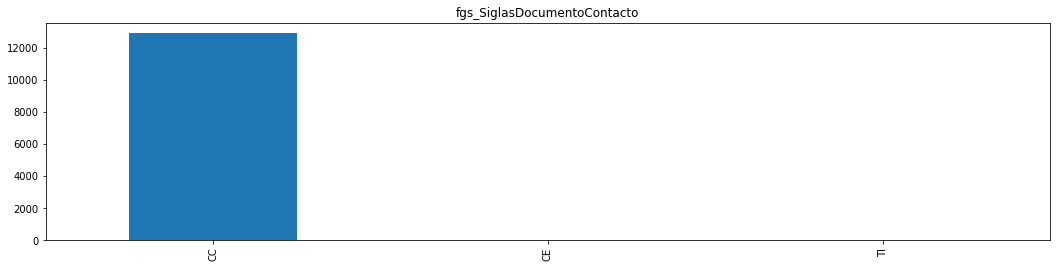

COL    12072
CO       867
ARE        4
Name: PS, dtype: int64

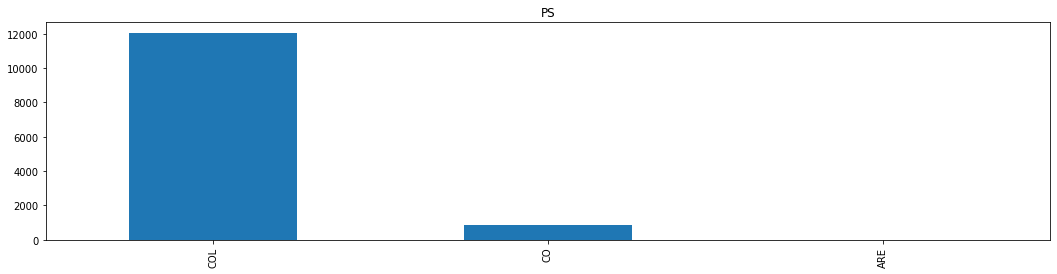

68        2908
68.0      2346
11.0      1549
11        1366
13.0       761
13         626
50         395
50.0       321
25         297
54.0       266
25.0       200
5          181
41.0       169
54         165
5.0        130
76.0        92
76          87
20          81
85.0        81
85          76
41          71
8.0         61
17          59
73          57
17.0        53
86          52
47          51
8           45
20.0        43
86.0        38
70.0        38
66.0        36
47.0        35
15.0        34
70          32
15          25
73.0        22
63          21
23.0        18
23          13
52          11
COLDEF      10
52.0         8
63.0         4
66           4
81           3
11.0         2
Name: RG, dtype: int64

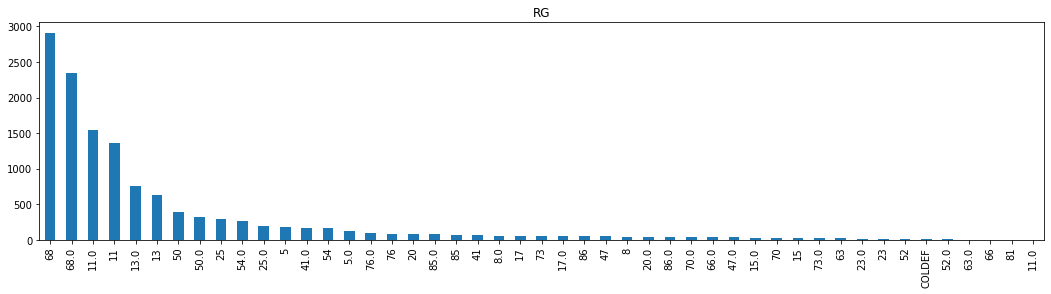

MASCULINO    11091
FEMENINO      1649
M               91
F               48
Masculino       47
Femenino        17
Name: SEXO, dtype: int64

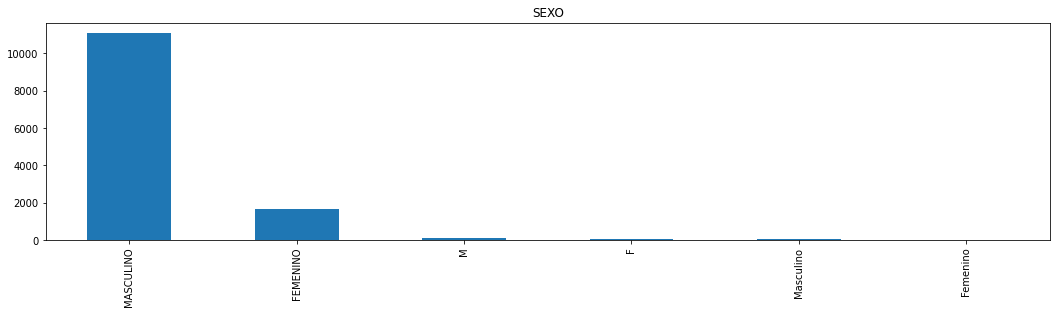

In [105]:

lista_menores = []
lista_mayores = []
for i in df_entrada.columns:
  
  if df_entrada[i].nunique()<=100:
    display(df_entrada[i].value_counts())
    df_entrada[i].value_counts().plot.bar(title=i,figsize=(18,4))
    plt.show()
    lista_menores.append(i)
  else:
    lista_mayores.append(i)

In [106]:


for i in df_entrada.columns:
  print(i)
  try:
   df_entrada[i]=df_entrada[i].map(lambda x: x.lower())
  except:
    print('{} no se puedo pponer en minuscula'.format(i))

lista ={'f':'femenino','m':'masculino'}
df_entrada['SEXO'] = df_entrada['SEXO'].replace(lista)#.map(lambda x : x.replace())


def solo_num(x):
  try:
    sal = float(x)
  except:
    sal = np.nan
  return sal 


df_entrada['RG'] = df_entrada['RG'].map(lambda x : solo_num(x))

fgs_SiglasDocumentoContacto
fgs_NombreCompletoContacto
NOMBRE_COMPLETO
CIUDAD
POSICION
PS
RG
RG no se puedo pponer en minuscula
FECHA_NACIMIENTO
fdp_FechaCreacion
SEXO


cc    12908
ce       19
ti       16
Name: fgs_SiglasDocumentoContacto, dtype: int64

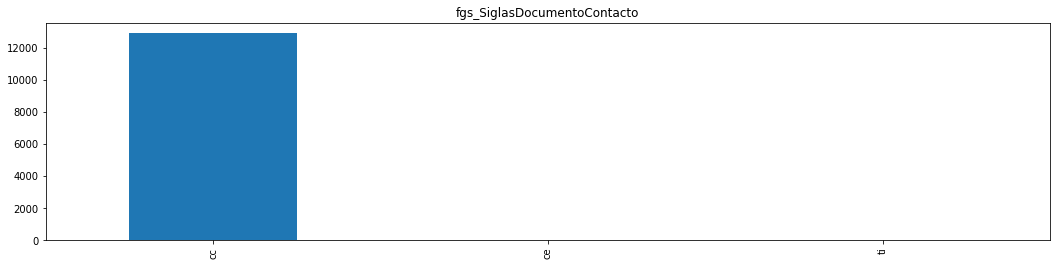

col    12072
co       867
are        4
Name: PS, dtype: int64

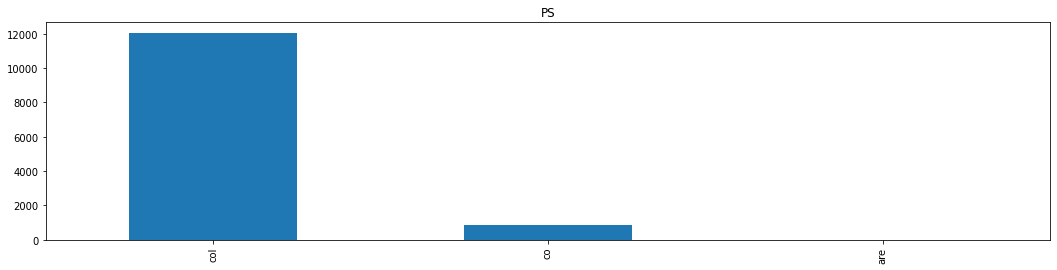

68.0    5254
11.0    2917
13.0    1387
50.0     716
25.0     497
54.0     431
5.0      311
41.0     240
76.0     179
85.0     157
20.0     124
17.0     112
8.0      106
86.0      90
47.0      86
73.0      79
70.0      70
15.0      59
66.0      40
23.0      31
63.0      25
52.0      19
81.0       3
Name: RG, dtype: int64

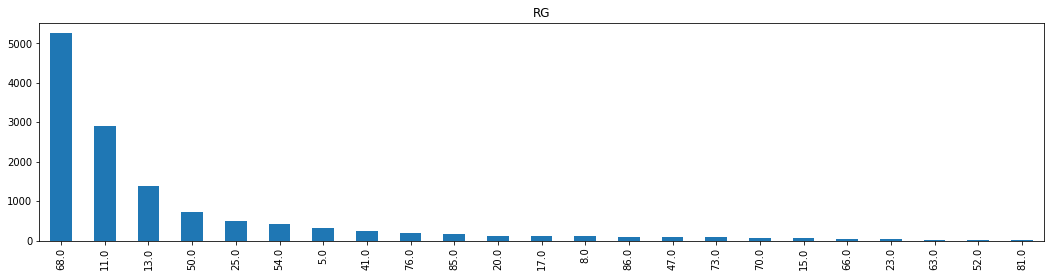

masculino    11229
femenino      1714
Name: SEXO, dtype: int64

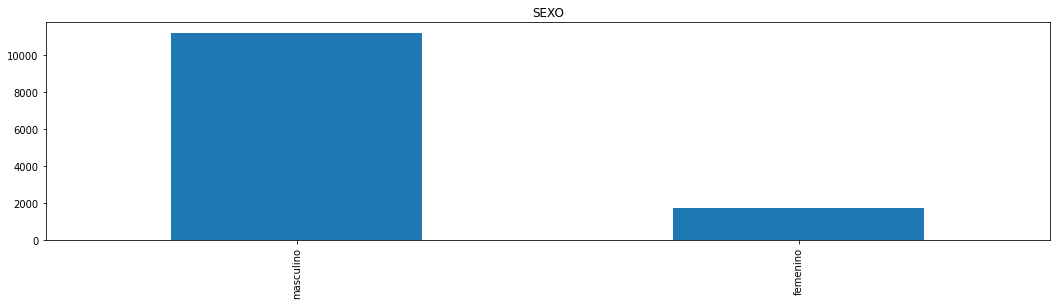

In [107]:

lista_menores = []
lista_mayores = []
for i in df_entrada.columns:
  
  if df_entrada[i].nunique()<=100:
    display(df_entrada[i].value_counts())
    df_entrada[i].value_counts().plot.bar(title=i,figsize=(18,4))
    plt.show()
    lista_menores.append(i)
  else:
    lista_mayores.append(i)

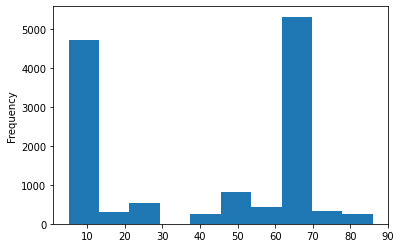

In [108]:
df_entrada['RG'].plot.hist()

In [109]:
pd.to_datetime(df_entrada['FECHA_NACIMIENTO'],errors='coerce')

0       1957-05-08
1       1995-07-23
2       1941-03-17
3       1950-04-18
4       1962-04-28
           ...    
13743   1948-11-08
13744   1958-08-16
13745   1962-02-18
13746   1965-02-28
13747   1962-02-18
Name: FECHA_NACIMIENTO, Length: 12943, dtype: datetime64[ns]

In [110]:
from datetime import datetime

print(datetime.today())

2021-06-09 20:45:07.670615


In [111]:
edad = datetime.today().year - pd.to_datetime(df_entrada['FECHA_NACIMIENTO'],errors='coerce').dt.year

In [112]:
df_entrada['edad']= edad

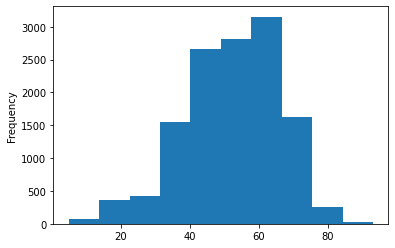

In [113]:
df_entrada['edad'].plot.hist()

In [114]:
# df_entrada['edad'].plot.bar()

In [115]:
df_entrada['edad'].describe(percentiles=[0.05,0.15,0.25,0.5,0.75,0.85,0.9,0.95,0.99])

count    12939.000000
mean        52.166860
std         13.566856
min          5.000000
5%          26.000000
15%         39.000000
25%         43.000000
50%         53.000000
75%         62.000000
85%         66.000000
90%         69.000000
95%         72.000000
99%         79.000000
max         93.000000
Name: edad, dtype: float64

In [116]:
df_entrada[df_entrada['edad']==93]

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,NOMBRE_COMPLETO,CIUDAD,POSICION,PS,RG,FECHA_NACIMIENTO,fdp_FechaCreacion,SEXO,edad
9159,cc,feria miranda cipriano,feria miranda cipriano,barrancabermeja,integración: posición por defecto,co,68.0,28-11-1928,2020-08-18 12:11:07.000,masculino,93.0


In [117]:
df_entrada[df_entrada['edad']==5]

,fgs_SiglasDocumentoContacto,fgs_NombreCompletoContacto,NOMBRE_COMPLETO,CIUDAD,POSICION,PS,RG,FECHA_NACIMIENTO,fdp_FechaCreacion,SEXO,edad
3550,cc,badillo prieto badirick damian,badillo prieto badirick damian,yopal,pensionados,col,85.0,05/12/2016,2021-02-01 16:35:23.000,masculino,5.0
3555,cc,badillo prieto badirick damian,badillo prieto badirick damian,yopal,pensionados,col,85.0,05/12/2016,2021-02-01 21:48:32.000,masculino,5.0
3606,cc,badillo prieto badirick damian,badillo prieto badirick damian,yopal,pensionados,col,85.0,05/12/2016,2021-02-03 14:55:51.000,masculino,5.0
3813,cc,badillo prieto badirick damian,badillo prieto badirick damian,yopal,pensionados,col,85.0,05/12/2016,2021-02-15 16:15:29.000,masculino,5.0
10180,cc,badillo prieto badirick damian,badillo prieto badirick damian,yopal,pensionados,col,85.0,05/12/2016,2020-11-03 12:07:20.000,masculino,5.0
10181,cc,badillo prieto badirick damian,badillo prieto badirick damian,yopal,pensionados,col,85.0,05/12/2016,2020-11-03 12:17:34.000,masculino,5.0


In [118]:

df_entrada['POSICION'].value_counts()

pensionados                                         5074
operadora de planta mayor                            483
operadora de planta                                  428
técnicoa de operaciones a                            313
supervisora a                                        284
                                                    ... 
jefe departamento de balance con transportadores       1
desarrollador de negocios gas  power                   1
ingenieroa integral aseguramiento de proy              1
business partner talento humano a                      1
técnicoa de mantenimiento a                            1
Name: POSICION, Length: 478, dtype: int64

In [119]:
df_entrada['POSICION'].value_counts().index.tolist()

['pensionados',
 'operadora de planta mayor',
 'operadora de planta',
 'técnicoa de operaciones a',
 'supervisora a',
 'operadora de planta senior',
 'técnicoa de operaciones b',
 'supervisora de centro de control remoto',
 'técnicoa de mantenimiento y confiabilidad a',
 'operador de planta',
 'ingenieroa integral de mantto y confiab',
 'ingenieroa de perf y compl a',
 'auxiliar de salud',
 'operadora de subsuelo mayor',
 'administradora de contratos a',
 'metalmecánico senior',
 'mecánicoa senior',
 'operadora de subsuelo senior',
 'ingenieroa de producción a',
 'profesional hse a',
 'operador de planta mayor',
 'operador de planta senior',
 'integración posición por defecto',
 'ingenieroa senior de perf y compl',
 'ingenieroa de confiabilidad e integridad',
 'analista de laboratorio a',
 'asistente administrativoa',
 'planeadora y programadora de mantenimiento',
 'planeadora y programadora integ de mantto',
 'instrumentista senior',
 'supervisora b',
 'ingenieroa integral de operacio

#Nuevos datos

In [120]:
contratista = pd.read_csv('Contratistas.csv')
empleados = pd.read_csv('Empleados.csv')
beneficiarios =pd.read_csv('Beneficiarios.csv')
pension =pd.read_csv('Pensionados.csv')

In [121]:
df_entrada = info_copilada_filtrada

for i in df_entrada.columns:
  print(i)
  try:
   df_entrada[i]=df_entrada[i].map(lambda x: x.lower())
  except:
    print('{} no se puedo pponer en minuscula'.format(i))

lista ={'f':'femenino','m':'masculino'}
df_entrada['SEXO'] = df_entrada['SEXO'].replace(lista)#.map(lambda x : x.replace())


def solo_num(x):
  try:
    sal = float(x)
  except:
    sal = np.nan
  return sal 


df_entrada['RG'] = df_entrada['RG'].map(lambda x : solo_num(x))

fgs_SiglasDocumentoContacto
fgs_NumeroDocumContacto
fgs_NumeroDocumContacto no se puedo pponer en minuscula
N_DOCUMENTO
N_DOCUMENTO no se puedo pponer en minuscula
fgs_NombreCompletoContacto
NOMBRE_COMPLETO
CIUDAD
POSICION
PS
RG
RG no se puedo pponer en minuscula
FECHA_NACIMIENTO
fdp_FechaCreacion
SEXO


In [122]:
df_entrada.columns

Index(['fgs_SiglasDocumentoContacto', 'fgs_NumeroDocumContacto', 'N_DOCUMENTO',
       'fgs_NombreCompletoContacto', 'NOMBRE_COMPLETO', 'CIUDAD', 'POSICION',
       'PS', 'RG', 'FECHA_NACIMIENTO', 'fdp_FechaCreacion', 'SEXO'],
      dtype='object')

In [123]:
def creacion_tabla(x):
  tabla_x = mytable(x)
  print(x.shape)
  return tabla_x

tablas ={}
contratista_tabla = creacion_tabla(contratista)

contratista_tabla

(10971, 18)


,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
ID,0.009115,0.0,object,10970,99.990885
AREA,0.082034,0.0,object,1782,16.242822
AREAORGANIZATIVA_UNIDADNEGOCIO,98.833288,0.0,object,20,0.182299
CARGO,0.191414,0.0,object,3776,34.418011
DESCRIPCION,0.537781,0.0,object,116,1.057333
DIRECCION_CONTRATO,15.695926,0.0,object,5239,47.753167
DIRECCION_OFICINA,0.227873,0.0,object,4659,42.466503
DN,0.100264,0.0,object,10933,99.653632
EMPRESA,0.145839,0.0,object,1147,10.454835
FAX,99.289035,0.0,object,36,0.328138


In [124]:

mapa = contratista['ID'].map(lambda x: isnum(x))
print(contratista.shape,contratista[mapa].shape,contratista[mapa].shape[0]/contratista.shape[0]*100 )
contratista = contratista[mapa].copy()
contratista['ID'] = contratista['ID'].astype('int')
tablas['contratista_tabla']=[contratista_tabla,contratista]

(10971, 18) (10780, 18) 98.25904657734026


In [125]:

empleados_tabla = creacion_tabla(empleados)
tablas['empleados_tabla']=[empleados_tabla,empleados]
empleados_tabla

(9812, 13)


,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
ID,0.0,0.0,int64,9812,100.000000
ID_EMPLEADO,100.0,0.0,float64,0,0.000000
USUARIO,0.0,0.0,object,9812,100.000000
APERS,0.0,0.0,object,10,0.101916
AREA_DE_PERSONAL,0.0,0.0,object,8,0.081533
CENTRO_COSTE,0.0,0.0,object,806,8.214431
CLASE DE FECHA,100.0,0.0,float64,0,0.000000
DTYPE,100.0,0.0,float64,0,0.000000
FECHA_LABORAL,0.0,0.0,object,1865,19.007338
GRPER,0.0,0.0,int64,3,0.030575


In [126]:
beneficiarios_tabla = creacion_tabla(beneficiarios)

beneficiarios_tabla

(76607, 6)


,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
ID,0.001305,0.0,object,75864,99.030115
CODIGO_FISCAL_PROVINCIA,0.039161,0.0,object,440,0.574360
HISTORIA_CLINICA,0.169697,0.0,object,98,0.127926
NO_PERS,0.001305,0.0,float64,20113,26.254781
NUMPER_HIS_FAM,64.713407,0.0,object,26476,34.560810
SUBTIPO,0.001305,0.0,object,15,0.019580


In [127]:
mapa = beneficiarios['ID'].map(lambda x: isnum(x))
print(beneficiarios.shape,beneficiarios[mapa].shape,beneficiarios[mapa].shape[0]/beneficiarios.shape[0]*100 )
beneficiarios = beneficiarios[mapa].copy()
beneficiarios['ID'] = beneficiarios['ID'].astype('int')
tablas['beneficiarios_tabla']=[beneficiarios_tabla,beneficiarios]

(76607, 6) (68487, 6) 89.40044643439894


In [128]:
pension_tabla = creacion_tabla(pension)
tablas['pension_tabla']=[pension_tabla,pension]
pension_tabla

(12997, 13)


,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
ID,0.000000,0.0,int64,12997,100.000000
ID_PENSIONADO,96.045241,0.0,object,2,0.015388
APERS,96.637686,0.0,object,6,0.046164
AREA_DE_PERSONAL,0.000000,0.0,object,9,0.069247
CENTRO_COSTE,99.992306,0.0,float64,1,0.007694
CLASE DE FECHA,96.045241,0.0,object,4,0.030776
DTYPE,96.045241,0.0,object,3,0.023082
FECHA_PENSIONADO,0.000000,0.0,object,5239,40.309302
GRPER,0.000000,0.0,object,2,0.015388
GRUPO DE PERSONAL,0.000000,0.0,object,2,0.015388


In [129]:
def eliminacion_columnas(tabla):
  cardinalidad100 = tabla[tabla['% de valores diferentes']==100]
  cardinalidad1 = tabla[tabla['# de valores diferentes']==1]
  vacios = tabla[tabla['% de datos nulos']==100]
  variables_eliminar=vacios.index.tolist()+cardinalidad1.index.tolist()+cardinalidad100.index.tolist()# no aportan informacion
  print('numero de variables a eliminar : {}'.format(len(variables_eliminar)))
  return variables_eliminar

In [130]:
try:
 variables_eliminar.remove('ID')
except Exception as e: 
  print(e)

list.remove(x): x not in list


In [131]:
variables_eliminar

['fgs_NombreDocumentoContacto',
 'fgs_FechaNacimientoContacto',
 'fgs_HabeasContacto',
 'fgs_NombreGeneroContacto',
 'fgs_RoutingPointOrVdn',
 'fgs_Extension',
 'fgs_CallId',
 'fgs_Skill',
 'fgs_Ani',
 'fgs_OpcionesIVR',
 'fgs_Nivel5',
 'fgs_Nivel6',
 'fgs_Nivel7',
 'fgs_Nivel8',
 'fgs_Nivel9',
 'fgs_Nivel10',
 'fdp_IdDetalleFlujoCreacion',
 'fdp_FechaVencimientoCreacion',
 'fdp_MotivoCreacion',
 'fdp_MotivoEscalamientoN2',
 'fdp_IdHistoricoPqrEscalamientoN3',
 'fdp_IdGrupoEscalamientoN3',
 'fdp_NombreGrupoEscalamientoN3',
 'fdp_IdDetalleFlujoEscalamientoN3',
 'fdp_IdUsuarioEscalamientoN3',
 'fdp_UsuarioEscalamientoN3',
 'fdp_NombreUsuarioEscalamientoN3',
 'fgs_ObservacionEscalamientoN3',
 'fdp_FechaEscalamientoN3',
 'fdp_FechaVencimientoEscalamientoN3',
 'CodigoGrupoRolEscalamientoN3',
 'GrupoRolEscalamientoN3',
 'fdp_MotivoEscalamientoN3',
 'fdp_NivelEscalamientoN3',
 'T_Objetivo_EnNivel3',
 'fdp_MotivoSolucion',
 'fdp_MotivoReapertura',
 'fdp_MotivoCierre',
 'T_Real_Total',
 'Cumple

In [132]:
df_filtradas={}
for i in tablas.keys():
  print(i)
  df_tablas = tablas[i][0]
  df =tablas[i][1]
  variables_eliminar = eliminacion_columnas(df_tablas)
  try:
    variables_eliminar.remove('ID')
  except Exception as e: 
    print(e)
  mapa_columnas = [i not in variables_eliminar for i in df.columns]  
  nuevas_columnas = df.columns[mapa_columnas]
  df_filtradas['{}_filtrada'.format(i)] =df[nuevas_columnas] 




contratista_tabla
numero de variables a eliminar : 0
list.remove(x): x not in list
empleados_tabla
numero de variables a eliminar : 6
beneficiarios_tabla
numero de variables a eliminar : 0
list.remove(x): x not in list
pension_tabla
numero de variables a eliminar : 4


In [133]:
df_filtradas.keys()

dict_keys(['contratista_tabla_filtrada', 'empleados_tabla_filtrada', 'beneficiarios_tabla_filtrada', 'pension_tabla_filtrada'])

In [134]:
mytable(df_filtradas['empleados_tabla_filtrada'])

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
ID,0.0,0.0,int64,9812,100.000000
APERS,0.0,0.0,object,10,0.101916
AREA_DE_PERSONAL,0.0,0.0,object,8,0.081533
CENTRO_COSTE,0.0,0.0,object,806,8.214431
FECHA_LABORAL,0.0,0.0,object,1865,19.007338
GRPER,0.0,0.0,int64,3,0.030575
GRUPO_PERSONAL,0.0,0.0,object,3,0.030575
UNIDAD_ORGANIZATIVA,0.0,0.0,object,558,5.686914


In [135]:
mytable(df_entrada)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.000000,0.0,object,3,0.023179
fgs_NumeroDocumContacto,0.000000,0.0,int64,4185,32.334080
N_DOCUMENTO,0.000000,0.0,int64,4185,32.334080
fgs_NombreCompletoContacto,0.000000,0.0,object,4190,32.372711
NOMBRE_COMPLETO,0.000000,0.0,object,4185,32.334080
CIUDAD,0.000000,0.0,object,137,1.058487
POSICION,0.000000,0.0,object,478,3.693116
PS,0.000000,0.0,object,3,0.023179
RG,0.077262,0.0,float64,23,0.177702
FECHA_NACIMIENTO,0.000000,0.0,object,3744,28.926833


In [136]:
mapa = beneficiarios['ID'].map(lambda x: isnum(x))
print(beneficiarios.shape,beneficiarios[mapa].shape,beneficiarios[mapa].shape[0]/beneficiarios.shape[0]*100 )
beneficiarios = beneficiarios[mapa].copy()
beneficiarios['ID'] = beneficiarios['ID'].astype('int')

(68487, 6) (68487, 6) 100.0


In [137]:
# df_filtradas[i].columns

In [138]:
for i in df_filtradas.keys():
  tam = df_entrada.shape
  print(i)
  df_entrada = df_entrada.merge(how='left', right=df_filtradas[i],left_on='fgs_NumeroDocumContacto',right_on='ID')
  print(tam,df_entrada.shape)

contratista_tabla_filtrada
(12943, 12) (12943, 30)
empleados_tabla_filtrada
(12943, 30) (12943, 38)
beneficiarios_tabla_filtrada
(12943, 38) (12943, 44)
pension_tabla_filtrada
(12943, 44) (12943, 54)


In [139]:
df_entrada


,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,N_DOCUMENTO,fgs_NombreCompletoContacto,NOMBRE_COMPLETO,CIUDAD,POSICION,PS,RG,FECHA_NACIMIENTO,fdp_FechaCreacion,SEXO,ID_x,AREA,AREAORGANIZATIVA_UNIDADNEGOCIO,CARGO,DESCRIPCION,DIRECCION_CONTRATO,DIRECCION_OFICINA,DN,EMPRESA,FAX,FECHA_EXPIRACION,HOME,LOGIN,MANAGER,NOMBRE_A_MOSTRAR,NOTAS,PAGER,WEB,ID_y,APERS_x,AREA_DE_PERSONAL_x,CENTRO_COSTE,FECHA_LABORAL,GRPER_x,GRUPO_PERSONAL,UNIDAD_ORGANIZATIVA_x,ID_x,CODIGO_FISCAL_PROVINCIA,HISTORIA_CLINICA,NO_PERS,NUMPER_HIS_FAM,SUBTIPO,ID_y,ID_PENSIONADO,APERS_y,AREA_DE_PERSONAL_y,CLASE DE FECHA,DTYPE,FECHA_PENSIONADO,GRPER_y,GRUPO DE PERSONAL,UNIDAD_ORGANIZATIVA_y
0,cc,19322865,19322865,sanchez mora joaquin ernesto,sanchez mora joaquin ernesto,"bogota, d.c.",pensionados,col,11.0,05/08/1957,2021-02-01 06:47:23.443,masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.932286e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,03/03/1987,3,PENSIONADOS,99999999.0
1,cc,1053843731,1053843731,santa gaviria mery angela,santa gaviria mery angela,santa marta,pensionados,col,47.0,23/07/1995,2021-02-01 07:01:31.857,femenino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.053844e+09,NaN,NaN,SUSTITUTO CONVENCION,NaN,NaN,15/09/2009,3,PENSIONADOS,99999999.0
2,cc,17043647,17043647,contreras gaitan jose del carmen,contreras gaitan jose del carmen,cucuta,pensionados,col,54.0,17/03/1941,2021-02-01 07:09:37.667,masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.704365e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,30/05/1999,3,PENSIONADOS,99999999.0
3,cc,19105812,19105812,molano pinzon hugo,molano pinzon hugo,santa marta,pensionados,col,47.0,18/04/1950,2021-02-01 07:19:12.327,masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.910581e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,19/05/2005,3,PENSIONADOS,99999999.0
4,cc,51659165,51659165,amaya campos maria cristina,amaya campos maria cristina,"bogota, d.c.",pensionados,col,11.0,28/04/1962,2021-02-01 07:23:02.490,femenino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.165916e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,27/03/1989,3,PENSIONADOS,99999999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12938,cc,8288700,8288700,casallas gomez luis carlos,casallas gomez luis carlos,"bogota, d.c.",pensionados,col,11.0,11/08/1948,2020-08-31 16:06:32.450,masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.288700e+06,NaN,NaN,ADHERIDO ACUERDO 01,NaN,NaN,30/11/2000,3,PENSIONADOS,99999999.0
12939,cc,79000080,79000080,garces gaitan julio alberto,garces gaitan julio alberto,puerto salgar,pensionados,col,25.0,16/08/1958,2020-08-31 16:11:25.650,masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.900008e+07,NaN,NaN,ADHERIDO ACUERDO 01,NaN,NaN,28/11/1977,3,PENSIONADOS,99999999.0
12940,cc,12119794,12119794,santos solano edgar,santos solano edgar,neiva,ingenieroa de perf y compl a,col,41.0,18/02/1962,2020-08-31 16:20:04.000,masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12119794.0,2/Z4,DIRECTIVO SINDICALIZADO,COORD. DE SUBSUELO HUILA,24/09/1990,2.0,TRABAJADOR SALARIO MENSUAL,Coord. de Subsuelo Huila -Tolima,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12941,cc,79238499,79238499,plazas aguilar jaime,plazas aguilar jaime,"bogota, d.c.",profesional 

In [140]:
df_entrada.merge(how='left', right=df_filtradas[i],left_on='N_DOCUMENTO',right_on='ID')

,fgs_SiglasDocumentoContacto,fgs_NumeroDocumContacto,N_DOCUMENTO,fgs_NombreCompletoContacto,NOMBRE_COMPLETO,CIUDAD,POSICION,PS,RG,FECHA_NACIMIENTO,fdp_FechaCreacion,SEXO,ID_x,AREA,AREAORGANIZATIVA_UNIDADNEGOCIO,CARGO,DESCRIPCION,DIRECCION_CONTRATO,DIRECCION_OFICINA,DN,EMPRESA,FAX,FECHA_EXPIRACION,HOME,LOGIN,MANAGER,NOMBRE_A_MOSTRAR,NOTAS,PAGER,WEB,ID_y,APERS_x,AREA_DE_PERSONAL_x,CENTRO_COSTE,FECHA_LABORAL,GRPER_x,GRUPO_PERSONAL,UNIDAD_ORGANIZATIVA_x,ID_x,CODIGO_FISCAL_PROVINCIA,HISTORIA_CLINICA,NO_PERS,NUMPER_HIS_FAM,SUBTIPO,ID_y,ID_PENSIONADO_x,APERS_y,AREA_DE_PERSONAL_y,CLASE DE FECHA_x,DTYPE_x,FECHA_PENSIONADO_x,GRPER_y,GRUPO DE PERSONAL_x,UNIDAD_ORGANIZATIVA_y,ID,ID_PENSIONADO_y,APERS,AREA_DE_PERSONAL,CLASE DE FECHA_y,DTYPE_y,FECHA_PENSIONADO_y,GRPER,GRUPO DE PERSONAL_y,UNIDAD_ORGANIZATIVA
0,cc,19322865,19322865,sanchez mora joaquin ernesto,sanchez mora joaquin ernesto,"bogota, d.c.",pensionados,col,11.0,05/08/1957,2021-02-01 06:47:23.443,masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.932286e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,03/03/1987,3,PENSIONADOS,99999999.0,1.932286e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,03/03/1987,3,PENSIONADOS,99999999.0
1,cc,1053843731,1053843731,santa gaviria mery angela,santa gaviria mery angela,santa marta,pensionados,col,47.0,23/07/1995,2021-02-01 07:01:31.857,femenino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.053844e+09,NaN,NaN,SUSTITUTO CONVENCION,NaN,NaN,15/09/2009,3,PENSIONADOS,99999999.0,1.053844e+09,NaN,NaN,SUSTITUTO CONVENCION,NaN,NaN,15/09/2009,3,PENSIONADOS,99999999.0
2,cc,17043647,17043647,contreras gaitan jose del carmen,contreras gaitan jose del carmen,cucuta,pensionados,col,54.0,17/03/1941,2021-02-01 07:09:37.667,masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.704365e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,30/05/1999,3,PENSIONADOS,99999999.0,1.704365e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,30/05/1999,3,PENSIONADOS,99999999.0
3,cc,19105812,19105812,molano pinzon hugo,molano pinzon hugo,santa marta,pensionados,col,47.0,18/04/1950,2021-02-01 07:19:12.327,masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.910581e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,19/05/2005,3,PENSIONADOS,99999999.0,1.910581e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,19/05/2005,3,PENSIONADOS,99999999.0
4,cc,51659165,51659165,amaya campos maria cristina,amaya campos maria cristina,"bogota, d.c.",pensionados,col,11.0,28/04/1962,2021-02-01 07:23:02.490,femenino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.165916e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,27/03/1989,3,PENSIONADOS,99999999.0,5.165916e+07,NaN,NaN,ESCALAF BENEF CCTV,NaN,NaN,27/03/1989,3,PENSIONADOS,99999999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12938,cc,8288700,8288700,casallas gomez luis carlos,casallas gomez luis carlos,"bogota, d.c.",pensionados,col,11.0,11/08/1948,2020-08-31 16:06:32.450,masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.288700e+06,NaN,NaN,ADHERIDO ACUERDO 01,NaN,NaN,30/11/2000,3,PENSIONADOS,99999999.0,8.288700e+06,NaN,NaN,ADHERIDO ACUERDO 01,NaN,NaN,30/11/2000,3,PENSIONADOS,99999999.0
12939,cc,79000080,79000080,garces gaitan julio alberto,garces gaitan julio alberto,puerto salgar,pensionados,col,25.0,16/08/1958,2020-08-31 16:11:25.650,masculino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [141]:
mytable(df_entrada)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.000000,0.0,object,3,0.023179
fgs_NumeroDocumContacto,0.000000,0.0,int64,4185,32.334080
N_DOCUMENTO,0.000000,0.0,int64,4185,32.334080
fgs_NombreCompletoContacto,0.000000,0.0,object,4190,32.372711
NOMBRE_COMPLETO,0.000000,0.0,object,4185,32.334080
CIUDAD,0.000000,0.0,object,137,1.058487
POSICION,0.000000,0.0,object,478,3.693116
PS,0.000000,0.0,object,3,0.023179
RG,0.077262,0.0,float64,23,0.177702
FECHA_NACIMIENTO,0.000000,0.0,object,3744,28.926833


In [142]:

df_tablas = mytable(df_entrada)
df =df_entrada
variables_eliminar = eliminacion_columnas(df_tablas)
try:
  variables_eliminar.remove('ID')
except Exception as e: 
  print(e)
mapa_columnas = [i not in variables_eliminar for i in df.columns]  
nuevas_columnas = df.columns[mapa_columnas]
df_entrada=df[nuevas_columnas] 


numero de variables a eliminar : 12
list.remove(x): x not in list


In [143]:
mytable(df_entrada)

,% de datos nulos,% de ceros,Tipo de datos,# de valores diferentes,% de valores diferentes
fgs_SiglasDocumentoContacto,0.000000,0.0,object,3,0.023179
fgs_NumeroDocumContacto,0.000000,0.0,int64,4185,32.334080
N_DOCUMENTO,0.000000,0.0,int64,4185,32.334080
fgs_NombreCompletoContacto,0.000000,0.0,object,4190,32.372711
NOMBRE_COMPLETO,0.000000,0.0,object,4185,32.334080
CIUDAD,0.000000,0.0,object,137,1.058487
POSICION,0.000000,0.0,object,478,3.693116
PS,0.000000,0.0,object,3,0.023179
RG,0.077262,0.0,float64,23,0.177702
FECHA_NACIMIENTO,0.000000,0.0,object,3744,28.926833
